In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cable-termination-dataset/cable_termination_dataset_1000.mat


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from timeit import default_timer
import wandb
from typing import Dict, Tuple,List
import os
from tqdm import tqdm
import time
from datetime import datetime, timedelta
from scipy.io import loadmat
import seaborn as sns


In [3]:
def format_time(seconds):
    """
    Convert seconds into a human-readable format (HH:MM:SS).
    """
    return str(timedelta(seconds=int(seconds)))

In [4]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        # Initialize weights with float32 precision
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                   self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                   self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        # Ensure input is float32
        x = x.to(torch.float32)
        batchsize = x.shape[0]
        size1 = x.shape[-2]
        size2 = x.shape[-1]

        # Calculate padding size to reach next power of 2
        def next_power_of_2(n):
            return 2**int(np.ceil(np.log2(n)))
        
        pad_size1 = next_power_of_2(size1) - size1
        pad_size2 = next_power_of_2(size2) - size2
        
        # Pad the input
        x_padded = F.pad(x, (0, pad_size2, 0, pad_size1))
        
        # Explicitly cast to float32 before FFT
        x_padded = x_padded.to(torch.float32)
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x_padded)

        # Initialize output Fourier coefficients with explicit float32 precision
        pad_size1_out = next_power_of_2(size1)
        pad_size2_out = next_power_of_2(size2)
        out_ft = torch.zeros(batchsize, self.out_channels, pad_size1_out, 
                           pad_size2_out//2 + 1, device=x.device, 
                           dtype=torch.cfloat)

        # Ensure consistent precision in einsum operations
        x_ft = x_ft.to(torch.cfloat)
        # Multiply relevant Fourier modes
        out_ft[:, :, :self.modes1, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", 
                        x_ft[:, :, :self.modes1, :self.modes2], 
                        self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", 
                        x_ft[:, :, -self.modes1:, :self.modes2], 
                        self.weights2)

        # Return to physical space (keeping float32 precision)
        x = torch.fft.irfft2(out_ft, s=(pad_size1_out, pad_size2_out))
        
        # Remove padding to get back original size
        x = x[:, :, :size1, :size2]
        
        return x

In [5]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width

        self.fc0 = nn.Linear(1, self.width)  # Input channel is 1: epsilon(x,y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Add shape transformation
        batch_size = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        
        # Reshape input to (batch_size * size_x * size_y, 1)
        x = x.view(batch_size, size_x, size_y, 1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [6]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [7]:
class ModelCheckpoint:
    def __init__(self, filepath, save_best_only=True):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.best_loss = float('inf')

    def __call__(self, model, val_loss):
        if self.save_best_only:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(model.state_dict(), self.filepath)
        else:
            torch.save(model.state_dict(), self.filepath)


In [8]:
class CableTerminationMetrics:
    def __init__(self, dx: float, dy: float, device: torch.device):
        """
        Initialize metrics calculator with grid spacing parameters and device.
        The device parameter ensures computations happen on the same device as the model.
        """
        self.dx = dx
        self.dy = dy
        self.device = device

    def get_boundary_mask(self, shape):
        """
        Create a boundary mask dynamically based on input shape.
        This allows handling of different batch sizes.
        
        Args:
            shape: Shape of the input tensor (batch_size, height, width, channels)
            
        Returns:
            torch.Tensor: Boolean mask identifying boundary elements
        """
        boundary_mask = torch.zeros(shape, dtype=torch.bool, device=self.device)
        boundary_mask[:, 0, :] = 1  # Top boundary
        boundary_mask[:, -1, :] = 1  # Bottom boundary
        boundary_mask[:, :, 0] = 1  # Left boundary
        boundary_mask[:, :, -1] = 1  # Right boundary
        return boundary_mask

    @torch.amp.autocast('cuda')
    def compute_error_metrics(self, pred: torch.Tensor, true: torch.Tensor) -> Dict[str, float]:
        """
        Compute error metrics efficiently on GPU using mixed precision.
        """
        mse = F.mse_loss(pred, true).item()
        mae = F.l1_loss(pred, true).item()
        relative_l2 = torch.norm(pred - true) / torch.norm(true)
        max_error = torch.max(torch.abs(pred - true)).item()
        
        return {
            'mse': mse,
            'rmse': np.sqrt(mse),
            'mae': mae,
            'relative_l2': relative_l2.item(),
            'max_pointwise_error': max_error
        }

    @torch.amp.autocast('cuda')
    def compute_electric_field(self, potential: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute electric field components efficiently on GPU.
        """
        potential = potential.squeeze(-1)
        
        # Compute gradients using pre-allocated tensors on GPU
        Ex = torch.zeros_like(potential, device=self.device)
        Ey = torch.zeros_like(potential, device=self.device)
        
        # Interior points
        Ex[:, :, 1:-1] = -(potential[:, :, 2:] - potential[:, :, :-2]) / (2 * self.dx)
        Ey[:, 1:-1, :] = -(potential[:, 2:, :] - potential[:, :-2, :]) / (2 * self.dy)
        
        # Boundaries
        Ex[:, :, 0] = -(potential[:, :, 1] - potential[:, :, 0]) / self.dx
        Ex[:, :, -1] = -(potential[:, :, -1] - potential[:, :, -2]) / self.dx
        Ey[:, 0, :] = -(potential[:, 1, :] - potential[:, 0, :]) / self.dy
        Ey[:, -1, :] = -(potential[:, -1, :] - potential[:, -2, :]) / self.dy
        
        return Ex.unsqueeze(-1), Ey.unsqueeze(-1)

    @torch.amp.autocast('cuda')
    def compute_physics_metrics(self, pred: torch.Tensor, true: torch.Tensor, 
                              epsilon: torch.Tensor, stress_mask: torch.Tensor) -> Dict[str, float]:
        """
        Compute physics-based metrics efficiently on GPU using mixed precision.
        """
        # Get boundary mask for current batch size
        boundary_mask = self.get_boundary_mask(pred.shape)
        
        Ex_pred, Ey_pred = self.compute_electric_field(pred)
        Ex_true, Ey_true = self.compute_electric_field(true)
    
        E_pred = torch.sqrt(Ex_pred**2 + Ey_pred**2)
        E_true = torch.sqrt(Ex_true**2 + Ey_true**2)
    
        max_field_error = torch.max(torch.abs(E_pred - E_true)).item()
    
        # Convert stress_mask to boolean if it isn't already
        stress_mask = stress_mask.bool()
        # Remove extra dimensions if present
        stress_mask = stress_mask.squeeze()
    
        # Make sure the mask has the same shape as E_pred
        if stress_mask.shape != E_pred.shape:
            stress_mask = stress_mask.unsqueeze(-1)
        
        # Compute the stress field error with proper boolean indexing
        stress_field_error = torch.mean(torch.abs(E_pred[stress_mask] - E_true[stress_mask])).item()
    
        Dx_pred = epsilon * Ex_pred
        Dy_pred = epsilon * Ey_pred
    
        # Compute divergence using pre-allocated tensors
        div_D = torch.zeros_like(Dx_pred, device=self.device)
        div_D[:, :, 1:-1] = (Dx_pred[:, :, 2:] - Dx_pred[:, :, :-2]) / (2 * self.dx)
        div_D[:, 1:-1, :] += (Dy_pred[:, 2:, :] - Dy_pred[:, :-2, :]) / (2 * self.dy)
    
        div_error = torch.mean(torch.abs(div_D)).item()
        bc_error = torch.mean(torch.abs(pred[boundary_mask] - true[boundary_mask])).item()
    
        return {
            'max_field_error': max_field_error,
            'stress_region_error': stress_field_error,
            'divergence_error': div_error,
            'boundary_condition_error': bc_error
        }

    def compute_all_metrics(self, pred: torch.Tensor, true: torch.Tensor, 
                          epsilon: torch.Tensor, stress_mask: torch.Tensor) -> Dict[str, float]:
        """
        Compute all metrics at once.
        """
        error_metrics = self.compute_error_metrics(pred, true)
        physics_metrics = self.compute_physics_metrics(pred, true, epsilon, stress_mask)
        
        return {**error_metrics, **physics_metrics}

In [9]:
def enhance_train_model(model, train_loader, val_loader, optimizer, scheduler, device, 
                       metrics_calculator, num_epochs=400, wandb_log=True):
    """
    Modified training loop with reduced logging frequency.
    """
    if wandb_log:
        wandb.init(project="cable-termination-fno")
    
    torch.backends.cudnn.benchmark = True
    
    early_stopping = EarlyStopping(patience=20)
    checkpoint = ModelCheckpoint('best_model.pth')
    
    history = {metric: [] for metric in ['train_loss', 'val_loss', 'max_field_error', 
                                     'stress_region_error', 'relative_l2']}
    
    batch_metrics = []
    start_time = time.time()
    best_val_loss = float('inf')
    
    # Calculate logging frequency (show approximately 4 updates per epoch)
    train_log_interval = max(len(train_loader) // 4, 1)
    val_log_interval = max(len(val_loader) // 4, 1)
    
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")
    
    for epoch in epoch_pbar:
        epoch_start_time = time.time()
        
        # Training loop
        model.train()
        train_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            x, y, epsilon, stress_mask = [b.to(device) for b in batch]
            
            optimizer.zero_grad(set_to_none=True)
            pred = model(x)
            loss = F.mse_loss(pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Log only at specified intervals
            if (batch_idx + 1) % train_log_interval == 0 or (batch_idx + 1) == len(train_loader):
                avg_loss = train_loss / (batch_idx + 1)
                print(f"Epoch [{epoch+1}/{num_epochs}] Training Batch [{batch_idx+1}/{len(train_loader)}] "
                      f"Loss: {avg_loss:.6f} LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        batch_metrics.clear()
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                x, y, epsilon, stress_mask = [b.to(device) for b in batch]
                
                pred = model(x)
                val_loss += F.mse_loss(pred, y).item()
                
                metrics = metrics_calculator.compute_all_metrics(pred, y, epsilon, stress_mask)
                batch_metrics.append(metrics)
                
                # Log only at specified intervals
                if (batch_idx + 1) % val_log_interval == 0 or (batch_idx + 1) == len(val_loader):
                    avg_val_loss = val_loss / (batch_idx + 1)
                    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Batch [{batch_idx+1}/{len(val_loader)}] "
                          f"Val Loss: {avg_val_loss:.6f}")
        
        # Average metrics over batches
        avg_metrics = {key: np.mean([m[key] for m in batch_metrics]) 
                      for key in batch_metrics[0].keys()}
        
        # Update history
        for metric in history:
            if metric == 'train_loss':
                history[metric].append(train_loss / len(train_loader))
            elif metric == 'val_loss':
                history[metric].append(val_loss / len(val_loader))
            else:
                history[metric].append(avg_metrics[metric])
        
        if wandb_log:
            wandb.log({
                'train_loss': history['train_loss'][-1],
                'val_loss': history['val_loss'][-1],
                **avg_metrics
            })
        
        # Calculate time statistics
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        avg_epoch_time = total_time / (epoch + 1)
        remaining_epochs = num_epochs - (epoch + 1)
        estimated_time_remaining = remaining_epochs * avg_epoch_time
        
        # Track best model
        current_val_loss = history['val_loss'][-1]
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {history['train_loss'][-1]:.6f}")
        print(f"Val Loss: {history['val_loss'][-1]:.6f}")
        print(f"Best Val Loss: {best_val_loss:.6f}")
        print(f"Time: {format_time(epoch_time)} (Remaining: {format_time(estimated_time_remaining)})\n")
        
        # Early stopping check
        early_stopping(history['val_loss'][-1])
        checkpoint(model, history['val_loss'][-1])
        scheduler.step()
        
        if early_stopping.early_stop:
            print("\nEarly stopping triggered!")
            break
    
    # Final training summary
    total_training_time = time.time() - start_time
    print("\nTraining Summary:")
    print(f"Total training time: {format_time(total_training_time)}")
    print(f"Average epoch time: {format_time(total_training_time/num_epochs)}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return history

In [10]:
def evaluate_model(model, test_loader, metrics_calculator, device):
    """
    Evaluate the final trained model on the test set.
    This function should only be used once after training is complete.
    
    Args:
        model: The trained FNO model
        test_loader: DataLoader containing the test dataset
        metrics_calculator: Instance of CableTerminationMetrics
        device: Device to run the evaluation on (CPU/GPU)
    
    Returns:
        Dictionary containing averaged test metrics
    """
    model.eval()
    test_metrics = []
    
    # Create progress bar for test evaluation
    test_pbar = tqdm(test_loader, desc="Evaluating on Test Set", unit="batch")
    
    # Specify 'cuda' for GPU or 'cpu' for CPU device type
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    
    with torch.no_grad(), autocast(device_type=device_type):
        for batch in test_pbar:
            x, y, epsilon, stress_mask = [b.to(device) for b in batch]
            pred = model(x)
            metrics = metrics_calculator.compute_all_metrics(pred, y, epsilon, stress_mask)
            test_metrics.append(metrics)
            
            # Update progress bar with current metrics
            test_pbar.set_postfix({
                'test_loss': f"{metrics['mse']:.6f}",
                'max_field_error': f"{metrics['max_field_error']:.6f}"
            })
    
    # Average metrics over all batches
    avg_metrics = {key: np.mean([m[key] for m in test_metrics]) 
                  for key in test_metrics[0].keys()}
    
    # Print detailed evaluation results
    print("\nTest Set Evaluation Results:")
    for metric_name, value in avg_metrics.items():
        print(f"{metric_name}: {value:.6f}")
    
    return avg_metrics

In [11]:
def plot_learning_curves(history: Dict[str, List[float]], save_path: str = 'learning_curves.png'):
    """
    Plot training and validation loss curves with proper styling and annotations.
    
    Args:
        history: Dictionary containing 'train_loss' and 'val_loss' lists
        save_path: Path to save the resulting plot
    """
    plt.figure(figsize=(12, 8))
    plt.plot(history['train_loss'], label='Training Loss', color='#2ecc71', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
    
    plt.title('Learning Curves', fontsize=16, pad=20)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss (MSE)', fontsize=14)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize legend
    plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    # Add annotations for minimum losses
    min_train_loss = min(history['train_loss'])
    min_val_loss = min(history['val_loss'])
    min_train_epoch = history['train_loss'].index(min_train_loss)
    min_val_epoch = history['val_loss'].index(min_val_loss)
    
    plt.annotate(f'Min Training Loss: {min_train_loss:.6f}',
                xy=(min_train_epoch, min_train_loss),
                xytext=(10, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle='->'))
    
    plt.annotate(f'Min Validation Loss: {min_val_loss:.6f}',
                xy=(min_val_epoch, min_val_loss),
                xytext=(10, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # plt.close()

def find_representative_samples(model, test_loader, device, n_samples=3):
    """
    Find the best, worst, and average performing test samples based on MSE.
    
    Args:
        model: Trained model
        test_loader: DataLoader containing test dataset
        device: Device to run inference on
        n_samples: Number of samples to return (default 3)
    
    Returns:
        List of tuples containing (input, ground truth, prediction, mse)
    """
    model.eval()
    all_samples = []
    
    with torch.no_grad():
        for batch in test_loader:
            x, y, epsilon, _ = [b.to(device) for b in batch]
            pred = model(x)
            
            # Calculate MSE for each sample in batch
            mse = torch.mean((pred - y) ** 2, dim=(1, 2, 3))
            
            for i in range(len(x)):
                all_samples.append((
                    x[i].cpu().numpy(),
                    y[i].cpu().numpy(),
                    pred[i].cpu().numpy(),
                    mse[i].item()
                ))
    
    # Sort by MSE
    all_samples.sort(key=lambda x: x[3])
    
    # Select best, worst, and middle samples
    best_idx = 0
    worst_idx = -1
    middle_idx = len(all_samples) // 2
    
    return [all_samples[i] for i in [best_idx, middle_idx, worst_idx]]

def plot_comparison(input_data, ground_truth, prediction, mse, case_type, save_path):
    """
    Create a comparison plot for a single sample showing input, ground truth, and prediction using pcolor.
    
    Args:
        input_data: Input sample
        ground_truth: Ground truth output
        prediction: Model prediction
        mse: Mean squared error for this sample
        case_type: String indicating if this is 'Best', 'Average', or 'Worst' case
        save_path: Path to save the plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create coordinate meshgrid for pcolor
    ny, nx = input_data.squeeze().shape
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    
    # Set a consistent colormap
    cmap = 'viridis'
    
    # Plot input
    im0 = axes[0].pcolor(X, Y, input_data.squeeze(), cmap=cmap, shading='auto')
    axes[0].set_title('Input', fontsize=14)
    axes[0].set_aspect('equal')
    axes[0].set_xlabel('x', fontsize=12)
    axes[0].set_ylabel('y', fontsize=12)
    plt.colorbar(im0, ax=axes[0])
    
    # Plot ground truth
    im1 = axes[1].pcolor(X, Y, ground_truth.squeeze(), cmap=cmap, shading='auto')
    axes[1].set_title('Ground Truth', fontsize=14)
    axes[1].set_aspect('equal')
    axes[1].set_xlabel('x', fontsize=12)
    axes[1].set_ylabel('y', fontsize=12)
    plt.colorbar(im1, ax=axes[1])
    
    # Plot prediction
    im2 = axes[2].pcolor(X, Y, prediction.squeeze(), cmap=cmap, shading='auto')
    axes[2].set_title('Prediction', fontsize=14)
    axes[2].set_aspect('equal')
    axes[2].set_xlabel('x', fontsize=12)
    axes[2].set_ylabel('y', fontsize=12)
    plt.colorbar(im2, ax=axes[2])
    
    # Add super title
    plt.suptitle(f'{case_type} Case (MSE: {mse:.6f})', fontsize=16, y=1.05)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # plt.close()
    
def save_sample_data(sample_data, case_type, save_dir='sample_data'):
    """
    Save sample data to text files.
    
    Args:
        sample_data: Tuple of (input, ground_truth, prediction, mse)
        case_type: String indicating if this is 'Best', 'Average', or 'Worst' case
        save_dir: Directory to save the files
    """
    os.makedirs(save_dir, exist_ok=True)
    
    input_data, ground_truth, prediction, mse = sample_data
    
    # Save input
    np.savetxt(
        f'{save_dir}/{case_type.lower()}_case_input.txt',
        input_data.squeeze(),
        fmt='%.6f',
        header=f'{case_type} Case Input Data (MSE: {mse:.6f})'
    )
    
    # Save ground truth
    np.savetxt(
        f'{save_dir}/{case_type.lower()}_case_ground_truth.txt',
        ground_truth.squeeze(),
        fmt='%.6f',
        header=f'{case_type} Case Ground Truth Data'
    )
    
    # Save prediction
    np.savetxt(
        f'{save_dir}/{case_type.lower()}_case_prediction.txt',
        prediction.squeeze(),
        fmt='%.6f',
        header=f'{case_type} Case Model Prediction'
    )

def generate_analysis(model, test_loader, history, device, output_dir='results'):
    """
    Generate all visualizations and save sample data.
    
    Args:
        model: Trained model
        test_loader: DataLoader containing test dataset
        history: Dictionary containing training history
        device: Device to run inference on
        output_dir: Directory to save all outputs
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot learning curves
    plot_learning_curves(history, f'{output_dir}/learning_curves.png')
    
    # Find representative samples
    samples = find_representative_samples(model, test_loader, device)
    
    # Create visualizations and save data for each case
    case_types = ['Best', 'Average', 'Worst']
    for sample, case_type in zip(samples, case_types):
        # Create visualization
        plot_comparison(
            sample[0], sample[1], sample[2], sample[3],
            case_type,
            f'{output_dir}/{case_type.lower()}_case_comparison.png'
        )
        
        # Save sample data
        save_sample_data(sample, case_type, f'{output_dir}/sample_data')
    
    print(f"\nAnalysis complete! Results saved in '{output_dir}' directory.")

Input data shape: torch.Size([1000, 141, 141, 1])
Output data shape: torch.Size([1000, 141, 141, 1])
Stress mask shape: torch.Size([1000, 141, 141, 1])


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nima-k700 (nima-k700-university-of-calgary-in-alberta). Use `wandb login --relogin` to force relogin


Training Progress:   0%|          | 0/400 [00:00<?, ?epoch/s]

Epoch [1/400] Training Batch [2/11] Loss: 0.310948 LR: 0.001000
Epoch [1/400] Training Batch [4/11] Loss: 0.290758 LR: 0.001000
Epoch [1/400] Training Batch [6/11] Loss: 0.268108 LR: 0.001000
Epoch [1/400] Training Batch [8/11] Loss: 0.243818 LR: 0.001000
Epoch [1/400] Training Batch [10/11] Loss: 0.216261 LR: 0.001000
Epoch [1/400] Training Batch [11/11] Loss: 0.201671 LR: 0.001000
Epoch [1/400] Validation Batch [1/3] Val Loss: 0.039519
Epoch [1/400] Validation Batch [2/3] Val Loss: 0.039603
Epoch [1/400] Validation Batch [3/3] Val Loss: 0.041019


Training Progress:   0%|          | 1/400 [00:13<1:32:41, 13.94s/epoch]


Epoch 1 Summary:
Train Loss: 0.201671
Val Loss: 0.041019
Best Val Loss: 0.041019
Time: 0:00:13 (Remaining: 1:32:32)

Epoch [2/400] Training Batch [2/11] Loss: 0.041090 LR: 0.001000
Epoch [2/400] Training Batch [4/11] Loss: 0.048342 LR: 0.001000
Epoch [2/400] Training Batch [6/11] Loss: 0.045170 LR: 0.001000
Epoch [2/400] Training Batch [8/11] Loss: 0.037942 LR: 0.001000
Epoch [2/400] Training Batch [10/11] Loss: 0.033802 LR: 0.001000
Epoch [2/400] Training Batch [11/11] Loss: 0.032633 LR: 0.001000
Epoch [2/400] Validation Batch [1/3] Val Loss: 0.021710


Training Progress:   0%|          | 2/400 [00:24<1:19:44, 12.02s/epoch]

Epoch [2/400] Validation Batch [2/3] Val Loss: 0.022679
Epoch [2/400] Validation Batch [3/3] Val Loss: 0.023457

Epoch 2 Summary:
Train Loss: 0.032633
Val Loss: 0.023457
Best Val Loss: 0.023457
Time: 0:00:10 (Remaining: 1:21:34)

Epoch [3/400] Training Batch [2/11] Loss: 0.022107 LR: 0.001000
Epoch [3/400] Training Batch [4/11] Loss: 0.021088 LR: 0.001000
Epoch [3/400] Training Batch [6/11] Loss: 0.018591 LR: 0.001000
Epoch [3/400] Training Batch [8/11] Loss: 0.016621 LR: 0.001000
Epoch [3/400] Training Batch [10/11] Loss: 0.015385 LR: 0.001000
Epoch [3/400] Training Batch [11/11] Loss: 0.014948 LR: 0.001000
Epoch [3/400] Validation Batch [1/3] Val Loss: 0.009937


Training Progress:   1%|          | 3/400 [00:35<1:15:32, 11.42s/epoch]

Epoch [3/400] Validation Batch [2/3] Val Loss: 0.009798
Epoch [3/400] Validation Batch [3/3] Val Loss: 0.010273

Epoch 3 Summary:
Train Loss: 0.014948
Val Loss: 0.010273
Best Val Loss: 0.010273
Time: 0:00:10 (Remaining: 1:17:50)

Epoch [4/400] Training Batch [2/11] Loss: 0.009168 LR: 0.001000
Epoch [4/400] Training Batch [4/11] Loss: 0.008852 LR: 0.001000
Epoch [4/400] Training Batch [6/11] Loss: 0.008555 LR: 0.001000
Epoch [4/400] Training Batch [8/11] Loss: 0.008167 LR: 0.001000
Epoch [4/400] Training Batch [10/11] Loss: 0.007913 LR: 0.001000
Epoch [4/400] Training Batch [11/11] Loss: 0.007724 LR: 0.001000
Epoch [4/400] Validation Batch [1/3] Val Loss: 0.005709


Training Progress:   1%|          | 4/400 [00:46<1:13:35, 11.15s/epoch]

Epoch [4/400] Validation Batch [2/3] Val Loss: 0.005859
Epoch [4/400] Validation Batch [3/3] Val Loss: 0.006387

Epoch 4 Summary:
Train Loss: 0.007724
Val Loss: 0.006387
Best Val Loss: 0.006387
Time: 0:00:10 (Remaining: 1:15:57)

Epoch [5/400] Training Batch [2/11] Loss: 0.006119 LR: 0.001000
Epoch [5/400] Training Batch [4/11] Loss: 0.006162 LR: 0.001000
Epoch [5/400] Training Batch [6/11] Loss: 0.005937 LR: 0.001000
Epoch [5/400] Training Batch [8/11] Loss: 0.005572 LR: 0.001000
Epoch [5/400] Training Batch [10/11] Loss: 0.005331 LR: 0.001000
Epoch [5/400] Training Batch [11/11] Loss: 0.005273 LR: 0.001000
Epoch [5/400] Validation Batch [1/3] Val Loss: 0.004381


Training Progress:   1%|▏         | 5/400 [00:56<1:12:24, 11.00s/epoch]

Epoch [5/400] Validation Batch [2/3] Val Loss: 0.004590
Epoch [5/400] Validation Batch [3/3] Val Loss: 0.005086

Epoch 5 Summary:
Train Loss: 0.005273
Val Loss: 0.005086
Best Val Loss: 0.005086
Time: 0:00:10 (Remaining: 1:14:44)

Epoch [6/400] Training Batch [2/11] Loss: 0.004403 LR: 0.001000
Epoch [6/400] Training Batch [4/11] Loss: 0.004312 LR: 0.001000
Epoch [6/400] Training Batch [6/11] Loss: 0.004032 LR: 0.001000
Epoch [6/400] Training Batch [8/11] Loss: 0.003858 LR: 0.001000
Epoch [6/400] Training Batch [10/11] Loss: 0.003807 LR: 0.001000
Epoch [6/400] Training Batch [11/11] Loss: 0.003775 LR: 0.001000
Epoch [6/400] Validation Batch [1/3] Val Loss: 0.002948


Training Progress:   2%|▏         | 6/400 [01:07<1:11:27, 10.88s/epoch]

Epoch [6/400] Validation Batch [2/3] Val Loss: 0.003060
Epoch [6/400] Validation Batch [3/3] Val Loss: 0.003405

Epoch 6 Summary:
Train Loss: 0.003775
Val Loss: 0.003405
Best Val Loss: 0.003405
Time: 0:00:10 (Remaining: 1:13:47)

Epoch [7/400] Training Batch [2/11] Loss: 0.002742 LR: 0.001000
Epoch [7/400] Training Batch [4/11] Loss: 0.002784 LR: 0.001000
Epoch [7/400] Training Batch [6/11] Loss: 0.002797 LR: 0.001000
Epoch [7/400] Training Batch [8/11] Loss: 0.002775 LR: 0.001000
Epoch [7/400] Training Batch [10/11] Loss: 0.002646 LR: 0.001000
Epoch [7/400] Training Batch [11/11] Loss: 0.002612 LR: 0.001000
Epoch [7/400] Validation Batch [1/3] Val Loss: 0.002108


Training Progress:   2%|▏         | 7/400 [01:18<1:10:47, 10.81s/epoch]

Epoch [7/400] Validation Batch [2/3] Val Loss: 0.002180
Epoch [7/400] Validation Batch [3/3] Val Loss: 0.002477

Epoch 7 Summary:
Train Loss: 0.002612
Val Loss: 0.002477
Best Val Loss: 0.002477
Time: 0:00:10 (Remaining: 1:13:03)

Epoch [8/400] Training Batch [2/11] Loss: 0.001877 LR: 0.001000
Epoch [8/400] Training Batch [4/11] Loss: 0.001971 LR: 0.001000
Epoch [8/400] Training Batch [6/11] Loss: 0.001902 LR: 0.001000
Epoch [8/400] Training Batch [8/11] Loss: 0.001874 LR: 0.001000
Epoch [8/400] Training Batch [10/11] Loss: 0.001837 LR: 0.001000
Epoch [8/400] Training Batch [11/11] Loss: 0.001824 LR: 0.001000
Epoch [8/400] Validation Batch [1/3] Val Loss: 0.001478


Training Progress:   2%|▏         | 8/400 [01:28<1:10:25, 10.78s/epoch]

Epoch [8/400] Validation Batch [2/3] Val Loss: 0.001550
Epoch [8/400] Validation Batch [3/3] Val Loss: 0.001770

Epoch 8 Summary:
Train Loss: 0.001824
Val Loss: 0.001770
Best Val Loss: 0.001770
Time: 0:00:10 (Remaining: 1:12:31)

Epoch [9/400] Training Batch [2/11] Loss: 0.001378 LR: 0.001000
Epoch [9/400] Training Batch [4/11] Loss: 0.001329 LR: 0.001000
Epoch [9/400] Training Batch [6/11] Loss: 0.001418 LR: 0.001000
Epoch [9/400] Training Batch [8/11] Loss: 0.001374 LR: 0.001000
Epoch [9/400] Training Batch [10/11] Loss: 0.001338 LR: 0.001000
Epoch [9/400] Training Batch [11/11] Loss: 0.001321 LR: 0.001000
Epoch [9/400] Validation Batch [1/3] Val Loss: 0.001087


Training Progress:   2%|▏         | 9/400 [01:39<1:10:03, 10.75s/epoch]

Epoch [9/400] Validation Batch [2/3] Val Loss: 0.001142
Epoch [9/400] Validation Batch [3/3] Val Loss: 0.001291

Epoch 9 Summary:
Train Loss: 0.001321
Val Loss: 0.001291
Best Val Loss: 0.001291
Time: 0:00:10 (Remaining: 1:12:01)

Epoch [10/400] Training Batch [2/11] Loss: 0.001130 LR: 0.001000
Epoch [10/400] Training Batch [4/11] Loss: 0.001124 LR: 0.001000
Epoch [10/400] Training Batch [6/11] Loss: 0.001066 LR: 0.001000
Epoch [10/400] Training Batch [8/11] Loss: 0.001029 LR: 0.001000
Epoch [10/400] Training Batch [10/11] Loss: 0.001007 LR: 0.001000
Epoch [10/400] Training Batch [11/11] Loss: 0.000990 LR: 0.001000
Epoch [10/400] Validation Batch [1/3] Val Loss: 0.000817


Training Progress:   2%|▎         | 10/400 [01:50<1:09:45, 10.73s/epoch]

Epoch [10/400] Validation Batch [2/3] Val Loss: 0.000866
Epoch [10/400] Validation Batch [3/3] Val Loss: 0.000970

Epoch 10 Summary:
Train Loss: 0.000990
Val Loss: 0.000970
Best Val Loss: 0.000970
Time: 0:00:10 (Remaining: 1:11:36)

Epoch [11/400] Training Batch [2/11] Loss: 0.000926 LR: 0.001000
Epoch [11/400] Training Batch [4/11] Loss: 0.000871 LR: 0.001000
Epoch [11/400] Training Batch [6/11] Loss: 0.000830 LR: 0.001000
Epoch [11/400] Training Batch [8/11] Loss: 0.000803 LR: 0.001000
Epoch [11/400] Training Batch [10/11] Loss: 0.000784 LR: 0.001000
Epoch [11/400] Training Batch [11/11] Loss: 0.000771 LR: 0.001000
Epoch [11/400] Validation Batch [1/3] Val Loss: 0.000645


Training Progress:   3%|▎         | 11/400 [02:00<1:09:31, 10.72s/epoch]

Epoch [11/400] Validation Batch [2/3] Val Loss: 0.000680
Epoch [11/400] Validation Batch [3/3] Val Loss: 0.000757

Epoch 11 Summary:
Train Loss: 0.000771
Val Loss: 0.000757
Best Val Loss: 0.000757
Time: 0:00:10 (Remaining: 1:11:14)

Epoch [12/400] Training Batch [2/11] Loss: 0.000749 LR: 0.001000
Epoch [12/400] Training Batch [4/11] Loss: 0.000670 LR: 0.001000
Epoch [12/400] Training Batch [6/11] Loss: 0.000662 LR: 0.001000
Epoch [12/400] Training Batch [8/11] Loss: 0.000648 LR: 0.001000
Epoch [12/400] Training Batch [10/11] Loss: 0.000628 LR: 0.001000
Epoch [12/400] Training Batch [11/11] Loss: 0.000620 LR: 0.001000
Epoch [12/400] Validation Batch [1/3] Val Loss: 0.000528


Training Progress:   3%|▎         | 12/400 [02:11<1:09:12, 10.70s/epoch]

Epoch [12/400] Validation Batch [2/3] Val Loss: 0.000559
Epoch [12/400] Validation Batch [3/3] Val Loss: 0.000617

Epoch 12 Summary:
Train Loss: 0.000620
Val Loss: 0.000617
Best Val Loss: 0.000617
Time: 0:00:10 (Remaining: 1:10:52)

Epoch [13/400] Training Batch [2/11] Loss: 0.000590 LR: 0.001000
Epoch [13/400] Training Batch [4/11] Loss: 0.000538 LR: 0.001000
Epoch [13/400] Training Batch [6/11] Loss: 0.000538 LR: 0.001000
Epoch [13/400] Training Batch [8/11] Loss: 0.000541 LR: 0.001000
Epoch [13/400] Training Batch [10/11] Loss: 0.000533 LR: 0.001000
Epoch [13/400] Training Batch [11/11] Loss: 0.000519 LR: 0.001000
Epoch [13/400] Validation Batch [1/3] Val Loss: 0.000448


Training Progress:   3%|▎         | 13/400 [02:22<1:08:55, 10.69s/epoch]

Epoch [13/400] Validation Batch [2/3] Val Loss: 0.000475
Epoch [13/400] Validation Batch [3/3] Val Loss: 0.000522

Epoch 13 Summary:
Train Loss: 0.000519
Val Loss: 0.000522
Best Val Loss: 0.000522
Time: 0:00:10 (Remaining: 1:10:32)

Epoch [14/400] Training Batch [2/11] Loss: 0.000490 LR: 0.001000
Epoch [14/400] Training Batch [4/11] Loss: 0.000472 LR: 0.001000
Epoch [14/400] Training Batch [6/11] Loss: 0.000486 LR: 0.001000
Epoch [14/400] Training Batch [8/11] Loss: 0.000465 LR: 0.001000
Epoch [14/400] Training Batch [10/11] Loss: 0.000462 LR: 0.001000
Epoch [14/400] Training Batch [11/11] Loss: 0.000451 LR: 0.001000
Epoch [14/400] Validation Batch [1/3] Val Loss: 0.000395


Training Progress:   4%|▎         | 14/400 [02:32<1:08:46, 10.69s/epoch]

Epoch [14/400] Validation Batch [2/3] Val Loss: 0.000419
Epoch [14/400] Validation Batch [3/3] Val Loss: 0.000454

Epoch 14 Summary:
Train Loss: 0.000451
Val Loss: 0.000454
Best Val Loss: 0.000454
Time: 0:00:10 (Remaining: 1:10:15)

Epoch [15/400] Training Batch [2/11] Loss: 0.000481 LR: 0.001000
Epoch [15/400] Training Batch [4/11] Loss: 0.000446 LR: 0.001000
Epoch [15/400] Training Batch [6/11] Loss: 0.000418 LR: 0.001000
Epoch [15/400] Training Batch [8/11] Loss: 0.000409 LR: 0.001000
Epoch [15/400] Training Batch [10/11] Loss: 0.000403 LR: 0.001000
Epoch [15/400] Training Batch [11/11] Loss: 0.000400 LR: 0.001000
Epoch [15/400] Validation Batch [1/3] Val Loss: 0.000354


Training Progress:   4%|▍         | 15/400 [02:43<1:08:35, 10.69s/epoch]

Epoch [15/400] Validation Batch [2/3] Val Loss: 0.000377
Epoch [15/400] Validation Batch [3/3] Val Loss: 0.000408

Epoch 15 Summary:
Train Loss: 0.000400
Val Loss: 0.000408
Best Val Loss: 0.000408
Time: 0:00:10 (Remaining: 1:09:58)

Epoch [16/400] Training Batch [2/11] Loss: 0.000423 LR: 0.001000
Epoch [16/400] Training Batch [4/11] Loss: 0.000404 LR: 0.001000
Epoch [16/400] Training Batch [6/11] Loss: 0.000378 LR: 0.001000
Epoch [16/400] Training Batch [8/11] Loss: 0.000365 LR: 0.001000
Epoch [16/400] Training Batch [10/11] Loss: 0.000356 LR: 0.001000
Epoch [16/400] Training Batch [11/11] Loss: 0.000357 LR: 0.001000
Epoch [16/400] Validation Batch [1/3] Val Loss: 0.000314


Training Progress:   4%|▍         | 16/400 [02:54<1:08:23, 10.69s/epoch]

Epoch [16/400] Validation Batch [2/3] Val Loss: 0.000337
Epoch [16/400] Validation Batch [3/3] Val Loss: 0.000363

Epoch 16 Summary:
Train Loss: 0.000357
Val Loss: 0.000363
Best Val Loss: 0.000363
Time: 0:00:10 (Remaining: 1:09:41)

Epoch [17/400] Training Batch [2/11] Loss: 0.000311 LR: 0.001000
Epoch [17/400] Training Batch [4/11] Loss: 0.000323 LR: 0.001000
Epoch [17/400] Training Batch [6/11] Loss: 0.000326 LR: 0.001000
Epoch [17/400] Training Batch [8/11] Loss: 0.000329 LR: 0.001000
Epoch [17/400] Training Batch [10/11] Loss: 0.000323 LR: 0.001000
Epoch [17/400] Training Batch [11/11] Loss: 0.000325 LR: 0.001000
Epoch [17/400] Validation Batch [1/3] Val Loss: 0.000289


Training Progress:   4%|▍         | 17/400 [03:04<1:08:13, 10.69s/epoch]

Epoch [17/400] Validation Batch [2/3] Val Loss: 0.000309
Epoch [17/400] Validation Batch [3/3] Val Loss: 0.000329

Epoch 17 Summary:
Train Loss: 0.000325
Val Loss: 0.000329
Best Val Loss: 0.000329
Time: 0:00:10 (Remaining: 1:09:26)

Epoch [18/400] Training Batch [2/11] Loss: 0.000319 LR: 0.001000
Epoch [18/400] Training Batch [4/11] Loss: 0.000311 LR: 0.001000
Epoch [18/400] Training Batch [6/11] Loss: 0.000315 LR: 0.001000
Epoch [18/400] Training Batch [8/11] Loss: 0.000307 LR: 0.001000
Epoch [18/400] Training Batch [10/11] Loss: 0.000302 LR: 0.001000
Epoch [18/400] Training Batch [11/11] Loss: 0.000297 LR: 0.001000
Epoch [18/400] Validation Batch [1/3] Val Loss: 0.000265


Training Progress:   4%|▍         | 18/400 [03:15<1:08:03, 10.69s/epoch]

Epoch [18/400] Validation Batch [2/3] Val Loss: 0.000283
Epoch [18/400] Validation Batch [3/3] Val Loss: 0.000302

Epoch 18 Summary:
Train Loss: 0.000297
Val Loss: 0.000302
Best Val Loss: 0.000302
Time: 0:00:10 (Remaining: 1:09:11)

Epoch [19/400] Training Batch [2/11] Loss: 0.000278 LR: 0.001000
Epoch [19/400] Training Batch [4/11] Loss: 0.000282 LR: 0.001000
Epoch [19/400] Training Batch [6/11] Loss: 0.000280 LR: 0.001000
Epoch [19/400] Training Batch [8/11] Loss: 0.000273 LR: 0.001000
Epoch [19/400] Training Batch [10/11] Loss: 0.000273 LR: 0.001000
Epoch [19/400] Training Batch [11/11] Loss: 0.000276 LR: 0.001000
Epoch [19/400] Validation Batch [1/3] Val Loss: 0.000246


Training Progress:   5%|▍         | 19/400 [03:26<1:07:48, 10.68s/epoch]

Epoch [19/400] Validation Batch [2/3] Val Loss: 0.000265
Epoch [19/400] Validation Batch [3/3] Val Loss: 0.000282

Epoch 19 Summary:
Train Loss: 0.000276
Val Loss: 0.000282
Best Val Loss: 0.000282
Time: 0:00:10 (Remaining: 1:08:56)

Epoch [20/400] Training Batch [2/11] Loss: 0.000264 LR: 0.001000
Epoch [20/400] Training Batch [4/11] Loss: 0.000256 LR: 0.001000
Epoch [20/400] Training Batch [6/11] Loss: 0.000246 LR: 0.001000
Epoch [20/400] Training Batch [8/11] Loss: 0.000249 LR: 0.001000
Epoch [20/400] Training Batch [10/11] Loss: 0.000257 LR: 0.001000
Epoch [20/400] Training Batch [11/11] Loss: 0.000257 LR: 0.001000
Epoch [20/400] Validation Batch [1/3] Val Loss: 0.000233


Training Progress:   5%|▌         | 20/400 [03:36<1:07:37, 10.68s/epoch]

Epoch [20/400] Validation Batch [2/3] Val Loss: 0.000248
Epoch [20/400] Validation Batch [3/3] Val Loss: 0.000262

Epoch 20 Summary:
Train Loss: 0.000257
Val Loss: 0.000262
Best Val Loss: 0.000262
Time: 0:00:10 (Remaining: 1:08:42)

Epoch [21/400] Training Batch [2/11] Loss: 0.000261 LR: 0.001000
Epoch [21/400] Training Batch [4/11] Loss: 0.000247 LR: 0.001000
Epoch [21/400] Training Batch [6/11] Loss: 0.000250 LR: 0.001000
Epoch [21/400] Training Batch [8/11] Loss: 0.000251 LR: 0.001000
Epoch [21/400] Training Batch [10/11] Loss: 0.000251 LR: 0.001000
Epoch [21/400] Training Batch [11/11] Loss: 0.000248 LR: 0.001000
Epoch [21/400] Validation Batch [1/3] Val Loss: 0.000220


Training Progress:   5%|▌         | 21/400 [03:47<1:07:26, 10.68s/epoch]

Epoch [21/400] Validation Batch [2/3] Val Loss: 0.000236
Epoch [21/400] Validation Batch [3/3] Val Loss: 0.000249

Epoch 21 Summary:
Train Loss: 0.000248
Val Loss: 0.000249
Best Val Loss: 0.000249
Time: 0:00:10 (Remaining: 1:08:28)

Epoch [22/400] Training Batch [2/11] Loss: 0.000228 LR: 0.001000
Epoch [22/400] Training Batch [4/11] Loss: 0.000218 LR: 0.001000
Epoch [22/400] Training Batch [6/11] Loss: 0.000221 LR: 0.001000
Epoch [22/400] Training Batch [8/11] Loss: 0.000234 LR: 0.001000
Epoch [22/400] Training Batch [10/11] Loss: 0.000238 LR: 0.001000
Epoch [22/400] Training Batch [11/11] Loss: 0.000235 LR: 0.001000
Epoch [22/400] Validation Batch [1/3] Val Loss: 0.000212


Training Progress:   6%|▌         | 22/400 [03:58<1:07:13, 10.67s/epoch]

Epoch [22/400] Validation Batch [2/3] Val Loss: 0.000227
Epoch [22/400] Validation Batch [3/3] Val Loss: 0.000238

Epoch 22 Summary:
Train Loss: 0.000235
Val Loss: 0.000238
Best Val Loss: 0.000238
Time: 0:00:10 (Remaining: 1:08:14)

Epoch [23/400] Training Batch [2/11] Loss: 0.000218 LR: 0.001000
Epoch [23/400] Training Batch [4/11] Loss: 0.000233 LR: 0.001000
Epoch [23/400] Training Batch [6/11] Loss: 0.000222 LR: 0.001000
Epoch [23/400] Training Batch [8/11] Loss: 0.000221 LR: 0.001000
Epoch [23/400] Training Batch [10/11] Loss: 0.000222 LR: 0.001000
Epoch [23/400] Training Batch [11/11] Loss: 0.000219 LR: 0.001000
Epoch [23/400] Validation Batch [1/3] Val Loss: 0.000205


Training Progress:   6%|▌         | 23/400 [04:08<1:07:02, 10.67s/epoch]

Epoch [23/400] Validation Batch [2/3] Val Loss: 0.000221
Epoch [23/400] Validation Batch [3/3] Val Loss: 0.000234

Epoch 23 Summary:
Train Loss: 0.000219
Val Loss: 0.000234
Best Val Loss: 0.000234
Time: 0:00:10 (Remaining: 1:08:00)

Epoch [24/400] Training Batch [2/11] Loss: 0.000223 LR: 0.001000
Epoch [24/400] Training Batch [4/11] Loss: 0.000212 LR: 0.001000
Epoch [24/400] Training Batch [6/11] Loss: 0.000199 LR: 0.001000
Epoch [24/400] Training Batch [8/11] Loss: 0.000203 LR: 0.001000
Epoch [24/400] Training Batch [10/11] Loss: 0.000210 LR: 0.001000
Epoch [24/400] Training Batch [11/11] Loss: 0.000211 LR: 0.001000
Epoch [24/400] Validation Batch [1/3] Val Loss: 0.000187


Training Progress:   6%|▌         | 24/400 [04:19<1:06:49, 10.66s/epoch]

Epoch [24/400] Validation Batch [2/3] Val Loss: 0.000199
Epoch [24/400] Validation Batch [3/3] Val Loss: 0.000208

Epoch 24 Summary:
Train Loss: 0.000211
Val Loss: 0.000208
Best Val Loss: 0.000208
Time: 0:00:10 (Remaining: 1:07:47)

Epoch [25/400] Training Batch [2/11] Loss: 0.000191 LR: 0.001000
Epoch [25/400] Training Batch [4/11] Loss: 0.000184 LR: 0.001000
Epoch [25/400] Training Batch [6/11] Loss: 0.000192 LR: 0.001000
Epoch [25/400] Training Batch [8/11] Loss: 0.000192 LR: 0.001000
Epoch [25/400] Training Batch [10/11] Loss: 0.000194 LR: 0.001000
Epoch [25/400] Training Batch [11/11] Loss: 0.000198 LR: 0.001000
Epoch [25/400] Validation Batch [1/3] Val Loss: 0.000184


Training Progress:   6%|▋         | 25/400 [04:30<1:06:35, 10.65s/epoch]

Epoch [25/400] Validation Batch [2/3] Val Loss: 0.000195
Epoch [25/400] Validation Batch [3/3] Val Loss: 0.000203

Epoch 25 Summary:
Train Loss: 0.000198
Val Loss: 0.000203
Best Val Loss: 0.000203
Time: 0:00:10 (Remaining: 1:07:33)

Epoch [26/400] Training Batch [2/11] Loss: 0.000181 LR: 0.001000
Epoch [26/400] Training Batch [4/11] Loss: 0.000192 LR: 0.001000
Epoch [26/400] Training Batch [6/11] Loss: 0.000190 LR: 0.001000
Epoch [26/400] Training Batch [8/11] Loss: 0.000187 LR: 0.001000
Epoch [26/400] Training Batch [10/11] Loss: 0.000188 LR: 0.001000
Epoch [26/400] Training Batch [11/11] Loss: 0.000190 LR: 0.001000
Epoch [26/400] Validation Batch [1/3] Val Loss: 0.000170


Training Progress:   6%|▋         | 26/400 [04:40<1:06:26, 10.66s/epoch]

Epoch [26/400] Validation Batch [2/3] Val Loss: 0.000182
Epoch [26/400] Validation Batch [3/3] Val Loss: 0.000189

Epoch 26 Summary:
Train Loss: 0.000190
Val Loss: 0.000189
Best Val Loss: 0.000189
Time: 0:00:10 (Remaining: 1:07:20)

Epoch [27/400] Training Batch [2/11] Loss: 0.000199 LR: 0.001000
Epoch [27/400] Training Batch [4/11] Loss: 0.000192 LR: 0.001000
Epoch [27/400] Training Batch [6/11] Loss: 0.000184 LR: 0.001000
Epoch [27/400] Training Batch [8/11] Loss: 0.000181 LR: 0.001000
Epoch [27/400] Training Batch [10/11] Loss: 0.000180 LR: 0.001000
Epoch [27/400] Training Batch [11/11] Loss: 0.000179 LR: 0.001000
Epoch [27/400] Validation Batch [1/3] Val Loss: 0.000162


Training Progress:   7%|▋         | 27/400 [04:51<1:06:19, 10.67s/epoch]

Epoch [27/400] Validation Batch [2/3] Val Loss: 0.000174
Epoch [27/400] Validation Batch [3/3] Val Loss: 0.000182

Epoch 27 Summary:
Train Loss: 0.000179
Val Loss: 0.000182
Best Val Loss: 0.000182
Time: 0:00:10 (Remaining: 1:07:08)

Epoch [28/400] Training Batch [2/11] Loss: 0.000166 LR: 0.001000
Epoch [28/400] Training Batch [4/11] Loss: 0.000163 LR: 0.001000
Epoch [28/400] Training Batch [6/11] Loss: 0.000172 LR: 0.001000
Epoch [28/400] Training Batch [8/11] Loss: 0.000171 LR: 0.001000
Epoch [28/400] Training Batch [10/11] Loss: 0.000172 LR: 0.001000
Epoch [28/400] Training Batch [11/11] Loss: 0.000171 LR: 0.001000
Epoch [28/400] Validation Batch [1/3] Val Loss: 0.000157


Training Progress:   7%|▋         | 28/400 [05:02<1:06:09, 10.67s/epoch]

Epoch [28/400] Validation Batch [2/3] Val Loss: 0.000168
Epoch [28/400] Validation Batch [3/3] Val Loss: 0.000175

Epoch 28 Summary:
Train Loss: 0.000171
Val Loss: 0.000175
Best Val Loss: 0.000175
Time: 0:00:10 (Remaining: 1:06:56)

Epoch [29/400] Training Batch [2/11] Loss: 0.000160 LR: 0.001000
Epoch [29/400] Training Batch [4/11] Loss: 0.000154 LR: 0.001000
Epoch [29/400] Training Batch [6/11] Loss: 0.000160 LR: 0.001000
Epoch [29/400] Training Batch [8/11] Loss: 0.000161 LR: 0.001000
Epoch [29/400] Training Batch [10/11] Loss: 0.000162 LR: 0.001000
Epoch [29/400] Training Batch [11/11] Loss: 0.000165 LR: 0.001000
Epoch [29/400] Validation Batch [1/3] Val Loss: 0.000153


Training Progress:   7%|▋         | 29/400 [05:13<1:06:16, 10.72s/epoch]

Epoch [29/400] Validation Batch [2/3] Val Loss: 0.000162
Epoch [29/400] Validation Batch [3/3] Val Loss: 0.000168

Epoch 29 Summary:
Train Loss: 0.000165
Val Loss: 0.000168
Best Val Loss: 0.000168
Time: 0:00:10 (Remaining: 1:06:45)

Epoch [30/400] Training Batch [2/11] Loss: 0.000183 LR: 0.001000
Epoch [30/400] Training Batch [4/11] Loss: 0.000169 LR: 0.001000
Epoch [30/400] Training Batch [6/11] Loss: 0.000164 LR: 0.001000
Epoch [30/400] Training Batch [8/11] Loss: 0.000163 LR: 0.001000
Epoch [30/400] Training Batch [10/11] Loss: 0.000161 LR: 0.001000
Epoch [30/400] Training Batch [11/11] Loss: 0.000160 LR: 0.001000
Epoch [30/400] Validation Batch [1/3] Val Loss: 0.000149


Training Progress:   8%|▊         | 30/400 [05:23<1:06:03, 10.71s/epoch]

Epoch [30/400] Validation Batch [2/3] Val Loss: 0.000160
Epoch [30/400] Validation Batch [3/3] Val Loss: 0.000168

Epoch 30 Summary:
Train Loss: 0.000160
Val Loss: 0.000168
Best Val Loss: 0.000168
Time: 0:00:10 (Remaining: 1:06:33)

Epoch [31/400] Training Batch [2/11] Loss: 0.000146 LR: 0.001000
Epoch [31/400] Training Batch [4/11] Loss: 0.000151 LR: 0.001000
Epoch [31/400] Training Batch [6/11] Loss: 0.000155 LR: 0.001000
Epoch [31/400] Training Batch [8/11] Loss: 0.000155 LR: 0.001000
Epoch [31/400] Training Batch [10/11] Loss: 0.000154 LR: 0.001000
Epoch [31/400] Training Batch [11/11] Loss: 0.000153 LR: 0.001000
Epoch [31/400] Validation Batch [1/3] Val Loss: 0.000141


Training Progress:   8%|▊         | 31/400 [05:34<1:05:51, 10.71s/epoch]

Epoch [31/400] Validation Batch [2/3] Val Loss: 0.000151
Epoch [31/400] Validation Batch [3/3] Val Loss: 0.000157

Epoch 31 Summary:
Train Loss: 0.000153
Val Loss: 0.000157
Best Val Loss: 0.000157
Time: 0:00:10 (Remaining: 1:06:21)

Epoch [32/400] Training Batch [2/11] Loss: 0.000154 LR: 0.001000
Epoch [32/400] Training Batch [4/11] Loss: 0.000150 LR: 0.001000
Epoch [32/400] Training Batch [6/11] Loss: 0.000147 LR: 0.001000
Epoch [32/400] Training Batch [8/11] Loss: 0.000146 LR: 0.001000
Epoch [32/400] Training Batch [10/11] Loss: 0.000149 LR: 0.001000
Epoch [32/400] Training Batch [11/11] Loss: 0.000148 LR: 0.001000
Epoch [32/400] Validation Batch [1/3] Val Loss: 0.000138


Training Progress:   8%|▊         | 32/400 [05:45<1:05:47, 10.73s/epoch]

Epoch [32/400] Validation Batch [2/3] Val Loss: 0.000148
Epoch [32/400] Validation Batch [3/3] Val Loss: 0.000156

Epoch 32 Summary:
Train Loss: 0.000148
Val Loss: 0.000156
Best Val Loss: 0.000156
Time: 0:00:10 (Remaining: 1:06:10)

Epoch [33/400] Training Batch [2/11] Loss: 0.000152 LR: 0.001000
Epoch [33/400] Training Batch [4/11] Loss: 0.000151 LR: 0.001000
Epoch [33/400] Training Batch [6/11] Loss: 0.000150 LR: 0.001000
Epoch [33/400] Training Batch [8/11] Loss: 0.000145 LR: 0.001000
Epoch [33/400] Training Batch [10/11] Loss: 0.000144 LR: 0.001000
Epoch [33/400] Training Batch [11/11] Loss: 0.000143 LR: 0.001000
Epoch [33/400] Validation Batch [1/3] Val Loss: 0.000136


Training Progress:   8%|▊         | 33/400 [05:55<1:05:32, 10.71s/epoch]

Epoch [33/400] Validation Batch [2/3] Val Loss: 0.000143
Epoch [33/400] Validation Batch [3/3] Val Loss: 0.000148

Epoch 33 Summary:
Train Loss: 0.000143
Val Loss: 0.000148
Best Val Loss: 0.000148
Time: 0:00:10 (Remaining: 1:05:58)

Epoch [34/400] Training Batch [2/11] Loss: 0.000134 LR: 0.001000
Epoch [34/400] Training Batch [4/11] Loss: 0.000136 LR: 0.001000
Epoch [34/400] Training Batch [6/11] Loss: 0.000137 LR: 0.001000
Epoch [34/400] Training Batch [8/11] Loss: 0.000137 LR: 0.001000
Epoch [34/400] Training Batch [10/11] Loss: 0.000141 LR: 0.001000
Epoch [34/400] Training Batch [11/11] Loss: 0.000140 LR: 0.001000
Epoch [34/400] Validation Batch [1/3] Val Loss: 0.000132


Training Progress:   8%|▊         | 34/400 [06:06<1:05:21, 10.72s/epoch]

Epoch [34/400] Validation Batch [2/3] Val Loss: 0.000138
Epoch [34/400] Validation Batch [3/3] Val Loss: 0.000142

Epoch 34 Summary:
Train Loss: 0.000140
Val Loss: 0.000142
Best Val Loss: 0.000142
Time: 0:00:10 (Remaining: 1:05:47)

Epoch [35/400] Training Batch [2/11] Loss: 0.000131 LR: 0.001000
Epoch [35/400] Training Batch [4/11] Loss: 0.000126 LR: 0.001000
Epoch [35/400] Training Batch [6/11] Loss: 0.000131 LR: 0.001000
Epoch [35/400] Training Batch [8/11] Loss: 0.000134 LR: 0.001000
Epoch [35/400] Training Batch [10/11] Loss: 0.000136 LR: 0.001000
Epoch [35/400] Training Batch [11/11] Loss: 0.000136 LR: 0.001000
Epoch [35/400] Validation Batch [1/3] Val Loss: 0.000128


Training Progress:   9%|▉         | 35/400 [06:17<1:04:58, 10.68s/epoch]

Epoch [35/400] Validation Batch [2/3] Val Loss: 0.000137
Epoch [35/400] Validation Batch [3/3] Val Loss: 0.000142

Epoch 35 Summary:
Train Loss: 0.000136
Val Loss: 0.000142
Best Val Loss: 0.000142
Time: 0:00:10 (Remaining: 1:05:34)

Epoch [36/400] Training Batch [2/11] Loss: 0.000136 LR: 0.001000
Epoch [36/400] Training Batch [4/11] Loss: 0.000141 LR: 0.001000
Epoch [36/400] Training Batch [6/11] Loss: 0.000137 LR: 0.001000
Epoch [36/400] Training Batch [8/11] Loss: 0.000138 LR: 0.001000
Epoch [36/400] Training Batch [10/11] Loss: 0.000135 LR: 0.001000
Epoch [36/400] Training Batch [11/11] Loss: 0.000133 LR: 0.001000
Epoch [36/400] Validation Batch [1/3] Val Loss: 0.000124


Training Progress:   9%|▉         | 36/400 [06:28<1:04:53, 10.70s/epoch]

Epoch [36/400] Validation Batch [2/3] Val Loss: 0.000131
Epoch [36/400] Validation Batch [3/3] Val Loss: 0.000135

Epoch 36 Summary:
Train Loss: 0.000133
Val Loss: 0.000135
Best Val Loss: 0.000135
Time: 0:00:10 (Remaining: 1:05:23)

Epoch [37/400] Training Batch [2/11] Loss: 0.000129 LR: 0.001000
Epoch [37/400] Training Batch [4/11] Loss: 0.000126 LR: 0.001000
Epoch [37/400] Training Batch [6/11] Loss: 0.000126 LR: 0.001000
Epoch [37/400] Training Batch [8/11] Loss: 0.000126 LR: 0.001000
Epoch [37/400] Training Batch [10/11] Loss: 0.000129 LR: 0.001000
Epoch [37/400] Training Batch [11/11] Loss: 0.000127 LR: 0.001000
Epoch [37/400] Validation Batch [1/3] Val Loss: 0.000118


Training Progress:   9%|▉         | 37/400 [06:38<1:04:48, 10.71s/epoch]

Epoch [37/400] Validation Batch [2/3] Val Loss: 0.000126
Epoch [37/400] Validation Batch [3/3] Val Loss: 0.000130

Epoch 37 Summary:
Train Loss: 0.000127
Val Loss: 0.000130
Best Val Loss: 0.000130
Time: 0:00:10 (Remaining: 1:05:12)

Epoch [38/400] Training Batch [2/11] Loss: 0.000111 LR: 0.001000
Epoch [38/400] Training Batch [4/11] Loss: 0.000118 LR: 0.001000
Epoch [38/400] Training Batch [6/11] Loss: 0.000122 LR: 0.001000
Epoch [38/400] Training Batch [8/11] Loss: 0.000121 LR: 0.001000
Epoch [38/400] Training Batch [10/11] Loss: 0.000124 LR: 0.001000
Epoch [38/400] Training Batch [11/11] Loss: 0.000123 LR: 0.001000
Epoch [38/400] Validation Batch [1/3] Val Loss: 0.000117


Training Progress:  10%|▉         | 38/400 [06:49<1:04:31, 10.69s/epoch]

Epoch [38/400] Validation Batch [2/3] Val Loss: 0.000124
Epoch [38/400] Validation Batch [3/3] Val Loss: 0.000128

Epoch 38 Summary:
Train Loss: 0.000123
Val Loss: 0.000128
Best Val Loss: 0.000128
Time: 0:00:10 (Remaining: 1:05:00)

Epoch [39/400] Training Batch [2/11] Loss: 0.000123 LR: 0.001000
Epoch [39/400] Training Batch [4/11] Loss: 0.000122 LR: 0.001000
Epoch [39/400] Training Batch [6/11] Loss: 0.000118 LR: 0.001000
Epoch [39/400] Training Batch [8/11] Loss: 0.000118 LR: 0.001000
Epoch [39/400] Training Batch [10/11] Loss: 0.000118 LR: 0.001000
Epoch [39/400] Training Batch [11/11] Loss: 0.000119 LR: 0.001000
Epoch [39/400] Validation Batch [1/3] Val Loss: 0.000114


Training Progress:  10%|▉         | 39/400 [07:00<1:04:18, 10.69s/epoch]

Epoch [39/400] Validation Batch [2/3] Val Loss: 0.000121
Epoch [39/400] Validation Batch [3/3] Val Loss: 0.000124

Epoch 39 Summary:
Train Loss: 0.000119
Val Loss: 0.000124
Best Val Loss: 0.000124
Time: 0:00:10 (Remaining: 1:04:48)

Epoch [40/400] Training Batch [2/11] Loss: 0.000113 LR: 0.001000
Epoch [40/400] Training Batch [4/11] Loss: 0.000115 LR: 0.001000
Epoch [40/400] Training Batch [6/11] Loss: 0.000122 LR: 0.001000
Epoch [40/400] Training Batch [8/11] Loss: 0.000122 LR: 0.001000
Epoch [40/400] Training Batch [10/11] Loss: 0.000121 LR: 0.001000
Epoch [40/400] Training Batch [11/11] Loss: 0.000120 LR: 0.001000
Epoch [40/400] Validation Batch [1/3] Val Loss: 0.000112


Training Progress:  10%|█         | 40/400 [07:10<1:04:05, 10.68s/epoch]

Epoch [40/400] Validation Batch [2/3] Val Loss: 0.000120
Epoch [40/400] Validation Batch [3/3] Val Loss: 0.000124

Epoch 40 Summary:
Train Loss: 0.000120
Val Loss: 0.000124
Best Val Loss: 0.000124
Time: 0:00:10 (Remaining: 1:04:36)

Epoch [41/400] Training Batch [2/11] Loss: 0.000118 LR: 0.001000
Epoch [41/400] Training Batch [4/11] Loss: 0.000122 LR: 0.001000
Epoch [41/400] Training Batch [6/11] Loss: 0.000117 LR: 0.001000
Epoch [41/400] Training Batch [8/11] Loss: 0.000114 LR: 0.001000
Epoch [41/400] Training Batch [10/11] Loss: 0.000113 LR: 0.001000
Epoch [41/400] Training Batch [11/11] Loss: 0.000114 LR: 0.001000
Epoch [41/400] Validation Batch [1/3] Val Loss: 0.000107


Training Progress:  10%|█         | 41/400 [07:21<1:04:03, 10.71s/epoch]

Epoch [41/400] Validation Batch [2/3] Val Loss: 0.000113
Epoch [41/400] Validation Batch [3/3] Val Loss: 0.000117

Epoch 41 Summary:
Train Loss: 0.000114
Val Loss: 0.000117
Best Val Loss: 0.000117
Time: 0:00:10 (Remaining: 1:04:25)

Epoch [42/400] Training Batch [2/11] Loss: 0.000114 LR: 0.001000
Epoch [42/400] Training Batch [4/11] Loss: 0.000114 LR: 0.001000
Epoch [42/400] Training Batch [6/11] Loss: 0.000115 LR: 0.001000
Epoch [42/400] Training Batch [8/11] Loss: 0.000114 LR: 0.001000
Epoch [42/400] Training Batch [10/11] Loss: 0.000113 LR: 0.001000
Epoch [42/400] Training Batch [11/11] Loss: 0.000112 LR: 0.001000
Epoch [42/400] Validation Batch [1/3] Val Loss: 0.000108


Training Progress:  10%|█         | 42/400 [07:32<1:03:49, 10.70s/epoch]

Epoch [42/400] Validation Batch [2/3] Val Loss: 0.000114
Epoch [42/400] Validation Batch [3/3] Val Loss: 0.000117

Epoch 42 Summary:
Train Loss: 0.000112
Val Loss: 0.000117
Best Val Loss: 0.000117
Time: 0:00:10 (Remaining: 1:04:14)

Epoch [43/400] Training Batch [2/11] Loss: 0.000114 LR: 0.001000
Epoch [43/400] Training Batch [4/11] Loss: 0.000109 LR: 0.001000
Epoch [43/400] Training Batch [6/11] Loss: 0.000111 LR: 0.001000
Epoch [43/400] Training Batch [8/11] Loss: 0.000111 LR: 0.001000
Epoch [43/400] Training Batch [10/11] Loss: 0.000111 LR: 0.001000
Epoch [43/400] Training Batch [11/11] Loss: 0.000111 LR: 0.001000
Epoch [43/400] Validation Batch [1/3] Val Loss: 0.000109


Training Progress:  11%|█         | 43/400 [07:42<1:03:31, 10.68s/epoch]

Epoch [43/400] Validation Batch [2/3] Val Loss: 0.000113
Epoch [43/400] Validation Batch [3/3] Val Loss: 0.000115

Epoch 43 Summary:
Train Loss: 0.000111
Val Loss: 0.000115
Best Val Loss: 0.000115
Time: 0:00:10 (Remaining: 1:04:02)

Epoch [44/400] Training Batch [2/11] Loss: 0.000107 LR: 0.001000
Epoch [44/400] Training Batch [4/11] Loss: 0.000112 LR: 0.001000
Epoch [44/400] Training Batch [6/11] Loss: 0.000110 LR: 0.001000
Epoch [44/400] Training Batch [8/11] Loss: 0.000111 LR: 0.001000
Epoch [44/400] Training Batch [10/11] Loss: 0.000109 LR: 0.001000
Epoch [44/400] Training Batch [11/11] Loss: 0.000108 LR: 0.001000
Epoch [44/400] Validation Batch [1/3] Val Loss: 0.000100


Training Progress:  11%|█         | 44/400 [07:53<1:03:20, 10.67s/epoch]

Epoch [44/400] Validation Batch [2/3] Val Loss: 0.000106
Epoch [44/400] Validation Batch [3/3] Val Loss: 0.000110

Epoch 44 Summary:
Train Loss: 0.000108
Val Loss: 0.000110
Best Val Loss: 0.000110
Time: 0:00:10 (Remaining: 1:03:51)

Epoch [45/400] Training Batch [2/11] Loss: 0.000100 LR: 0.001000
Epoch [45/400] Training Batch [4/11] Loss: 0.000105 LR: 0.001000
Epoch [45/400] Training Batch [6/11] Loss: 0.000107 LR: 0.001000
Epoch [45/400] Training Batch [8/11] Loss: 0.000104 LR: 0.001000
Epoch [45/400] Training Batch [10/11] Loss: 0.000103 LR: 0.001000
Epoch [45/400] Training Batch [11/11] Loss: 0.000102 LR: 0.001000
Epoch [45/400] Validation Batch [1/3] Val Loss: 0.000096


Training Progress:  11%|█▏        | 45/400 [08:04<1:03:11, 10.68s/epoch]

Epoch [45/400] Validation Batch [2/3] Val Loss: 0.000102
Epoch [45/400] Validation Batch [3/3] Val Loss: 0.000105

Epoch 45 Summary:
Train Loss: 0.000102
Val Loss: 0.000105
Best Val Loss: 0.000105
Time: 0:00:10 (Remaining: 1:03:39)

Epoch [46/400] Training Batch [2/11] Loss: 0.000093 LR: 0.001000
Epoch [46/400] Training Batch [4/11] Loss: 0.000097 LR: 0.001000
Epoch [46/400] Training Batch [6/11] Loss: 0.000098 LR: 0.001000
Epoch [46/400] Training Batch [8/11] Loss: 0.000099 LR: 0.001000
Epoch [46/400] Training Batch [10/11] Loss: 0.000100 LR: 0.001000
Epoch [46/400] Training Batch [11/11] Loss: 0.000099 LR: 0.001000
Epoch [46/400] Validation Batch [1/3] Val Loss: 0.000097


Training Progress:  12%|█▏        | 46/400 [08:14<1:02:58, 10.67s/epoch]

Epoch [46/400] Validation Batch [2/3] Val Loss: 0.000103
Epoch [46/400] Validation Batch [3/3] Val Loss: 0.000106

Epoch 46 Summary:
Train Loss: 0.000099
Val Loss: 0.000106
Best Val Loss: 0.000105
Time: 0:00:10 (Remaining: 1:03:28)

Epoch [47/400] Training Batch [2/11] Loss: 0.000107 LR: 0.001000
Epoch [47/400] Training Batch [4/11] Loss: 0.000102 LR: 0.001000
Epoch [47/400] Training Batch [6/11] Loss: 0.000100 LR: 0.001000
Epoch [47/400] Training Batch [8/11] Loss: 0.000098 LR: 0.001000
Epoch [47/400] Training Batch [10/11] Loss: 0.000098 LR: 0.001000
Epoch [47/400] Training Batch [11/11] Loss: 0.000098 LR: 0.001000
Epoch [47/400] Validation Batch [1/3] Val Loss: 0.000092


Training Progress:  12%|█▏        | 47/400 [08:25<1:02:48, 10.67s/epoch]

Epoch [47/400] Validation Batch [2/3] Val Loss: 0.000097
Epoch [47/400] Validation Batch [3/3] Val Loss: 0.000099

Epoch 47 Summary:
Train Loss: 0.000098
Val Loss: 0.000099
Best Val Loss: 0.000099
Time: 0:00:10 (Remaining: 1:03:16)

Epoch [48/400] Training Batch [2/11] Loss: 0.000095 LR: 0.001000
Epoch [48/400] Training Batch [4/11] Loss: 0.000095 LR: 0.001000
Epoch [48/400] Training Batch [6/11] Loss: 0.000094 LR: 0.001000
Epoch [48/400] Training Batch [8/11] Loss: 0.000092 LR: 0.001000
Epoch [48/400] Training Batch [10/11] Loss: 0.000094 LR: 0.001000
Epoch [48/400] Training Batch [11/11] Loss: 0.000096 LR: 0.001000
Epoch [48/400] Validation Batch [1/3] Val Loss: 0.000092


Training Progress:  12%|█▏        | 48/400 [08:36<1:02:32, 10.66s/epoch]

Epoch [48/400] Validation Batch [2/3] Val Loss: 0.000098
Epoch [48/400] Validation Batch [3/3] Val Loss: 0.000101

Epoch 48 Summary:
Train Loss: 0.000096
Val Loss: 0.000101
Best Val Loss: 0.000099
Time: 0:00:10 (Remaining: 1:03:05)

Epoch [49/400] Training Batch [2/11] Loss: 0.000103 LR: 0.001000
Epoch [49/400] Training Batch [4/11] Loss: 0.000100 LR: 0.001000
Epoch [49/400] Training Batch [6/11] Loss: 0.000101 LR: 0.001000
Epoch [49/400] Training Batch [8/11] Loss: 0.000098 LR: 0.001000
Epoch [49/400] Training Batch [10/11] Loss: 0.000096 LR: 0.001000
Epoch [49/400] Training Batch [11/11] Loss: 0.000095 LR: 0.001000
Epoch [49/400] Validation Batch [1/3] Val Loss: 0.000089


Training Progress:  12%|█▏        | 49/400 [08:46<1:02:23, 10.67s/epoch]

Epoch [49/400] Validation Batch [2/3] Val Loss: 0.000094
Epoch [49/400] Validation Batch [3/3] Val Loss: 0.000097

Epoch 49 Summary:
Train Loss: 0.000095
Val Loss: 0.000097
Best Val Loss: 0.000097
Time: 0:00:10 (Remaining: 1:02:53)

Epoch [50/400] Training Batch [2/11] Loss: 0.000091 LR: 0.001000
Epoch [50/400] Training Batch [4/11] Loss: 0.000089 LR: 0.001000
Epoch [50/400] Training Batch [6/11] Loss: 0.000091 LR: 0.001000
Epoch [50/400] Training Batch [8/11] Loss: 0.000089 LR: 0.001000
Epoch [50/400] Training Batch [10/11] Loss: 0.000091 LR: 0.001000
Epoch [50/400] Training Batch [11/11] Loss: 0.000091 LR: 0.001000
Epoch [50/400] Validation Batch [1/3] Val Loss: 0.000087


Training Progress:  12%|█▎        | 50/400 [08:57<1:02:19, 10.68s/epoch]

Epoch [50/400] Validation Batch [2/3] Val Loss: 0.000091
Epoch [50/400] Validation Batch [3/3] Val Loss: 0.000094

Epoch 50 Summary:
Train Loss: 0.000091
Val Loss: 0.000094
Best Val Loss: 0.000094
Time: 0:00:10 (Remaining: 1:02:42)

Epoch [51/400] Training Batch [2/11] Loss: 0.000089 LR: 0.001000
Epoch [51/400] Training Batch [4/11] Loss: 0.000089 LR: 0.001000
Epoch [51/400] Training Batch [6/11] Loss: 0.000089 LR: 0.001000
Epoch [51/400] Training Batch [8/11] Loss: 0.000089 LR: 0.001000
Epoch [51/400] Training Batch [10/11] Loss: 0.000089 LR: 0.001000
Epoch [51/400] Training Batch [11/11] Loss: 0.000088 LR: 0.001000
Epoch [51/400] Validation Batch [1/3] Val Loss: 0.000084


Training Progress:  13%|█▎        | 51/400 [09:08<1:02:08, 10.68s/epoch]

Epoch [51/400] Validation Batch [2/3] Val Loss: 0.000088
Epoch [51/400] Validation Batch [3/3] Val Loss: 0.000091

Epoch 51 Summary:
Train Loss: 0.000088
Val Loss: 0.000091
Best Val Loss: 0.000091
Time: 0:00:10 (Remaining: 1:02:31)

Epoch [52/400] Training Batch [2/11] Loss: 0.000098 LR: 0.001000
Epoch [52/400] Training Batch [4/11] Loss: 0.000090 LR: 0.001000
Epoch [52/400] Training Batch [6/11] Loss: 0.000086 LR: 0.001000
Epoch [52/400] Training Batch [8/11] Loss: 0.000085 LR: 0.001000
Epoch [52/400] Training Batch [10/11] Loss: 0.000087 LR: 0.001000
Epoch [52/400] Training Batch [11/11] Loss: 0.000087 LR: 0.001000
Epoch [52/400] Validation Batch [1/3] Val Loss: 0.000083


Training Progress:  13%|█▎        | 52/400 [09:18<1:01:54, 10.67s/epoch]

Epoch [52/400] Validation Batch [2/3] Val Loss: 0.000087
Epoch [52/400] Validation Batch [3/3] Val Loss: 0.000089

Epoch 52 Summary:
Train Loss: 0.000087
Val Loss: 0.000089
Best Val Loss: 0.000089
Time: 0:00:10 (Remaining: 1:02:20)

Epoch [53/400] Training Batch [2/11] Loss: 0.000086 LR: 0.001000
Epoch [53/400] Training Batch [4/11] Loss: 0.000089 LR: 0.001000
Epoch [53/400] Training Batch [6/11] Loss: 0.000087 LR: 0.001000
Epoch [53/400] Training Batch [8/11] Loss: 0.000088 LR: 0.001000
Epoch [53/400] Training Batch [10/11] Loss: 0.000086 LR: 0.001000
Epoch [53/400] Training Batch [11/11] Loss: 0.000087 LR: 0.001000
Epoch [53/400] Validation Batch [1/3] Val Loss: 0.000083


Training Progress:  13%|█▎        | 53/400 [09:29<1:01:41, 10.67s/epoch]

Epoch [53/400] Validation Batch [2/3] Val Loss: 0.000088
Epoch [53/400] Validation Batch [3/3] Val Loss: 0.000090

Epoch 53 Summary:
Train Loss: 0.000087
Val Loss: 0.000090
Best Val Loss: 0.000089
Time: 0:00:10 (Remaining: 1:02:08)

Epoch [54/400] Training Batch [2/11] Loss: 0.000076 LR: 0.001000
Epoch [54/400] Training Batch [4/11] Loss: 0.000074 LR: 0.001000
Epoch [54/400] Training Batch [6/11] Loss: 0.000082 LR: 0.001000
Epoch [54/400] Training Batch [8/11] Loss: 0.000083 LR: 0.001000
Epoch [54/400] Training Batch [10/11] Loss: 0.000084 LR: 0.001000
Epoch [54/400] Training Batch [11/11] Loss: 0.000085 LR: 0.001000
Epoch [54/400] Validation Batch [1/3] Val Loss: 0.000083


Training Progress:  14%|█▎        | 54/400 [09:40<1:01:34, 10.68s/epoch]

Epoch [54/400] Validation Batch [2/3] Val Loss: 0.000087
Epoch [54/400] Validation Batch [3/3] Val Loss: 0.000089

Epoch 54 Summary:
Train Loss: 0.000085
Val Loss: 0.000089
Best Val Loss: 0.000089
Time: 0:00:10 (Remaining: 1:01:57)

Epoch [55/400] Training Batch [2/11] Loss: 0.000090 LR: 0.001000
Epoch [55/400] Training Batch [4/11] Loss: 0.000085 LR: 0.001000
Epoch [55/400] Training Batch [6/11] Loss: 0.000083 LR: 0.001000
Epoch [55/400] Training Batch [8/11] Loss: 0.000084 LR: 0.001000
Epoch [55/400] Training Batch [10/11] Loss: 0.000084 LR: 0.001000
Epoch [55/400] Training Batch [11/11] Loss: 0.000084 LR: 0.001000
Epoch [55/400] Validation Batch [1/3] Val Loss: 0.000082


Training Progress:  14%|█▍        | 55/400 [09:50<1:01:26, 10.69s/epoch]

Epoch [55/400] Validation Batch [2/3] Val Loss: 0.000087
Epoch [55/400] Validation Batch [3/3] Val Loss: 0.000090

Epoch 55 Summary:
Train Loss: 0.000084
Val Loss: 0.000090
Best Val Loss: 0.000089
Time: 0:00:10 (Remaining: 1:01:46)

Epoch [56/400] Training Batch [2/11] Loss: 0.000085 LR: 0.001000
Epoch [56/400] Training Batch [4/11] Loss: 0.000081 LR: 0.001000
Epoch [56/400] Training Batch [6/11] Loss: 0.000080 LR: 0.001000
Epoch [56/400] Training Batch [8/11] Loss: 0.000083 LR: 0.001000
Epoch [56/400] Training Batch [10/11] Loss: 0.000082 LR: 0.001000
Epoch [56/400] Training Batch [11/11] Loss: 0.000082 LR: 0.001000
Epoch [56/400] Validation Batch [1/3] Val Loss: 0.000079


Training Progress:  14%|█▍        | 56/400 [10:01<1:01:14, 10.68s/epoch]

Epoch [56/400] Validation Batch [2/3] Val Loss: 0.000083
Epoch [56/400] Validation Batch [3/3] Val Loss: 0.000085

Epoch 56 Summary:
Train Loss: 0.000082
Val Loss: 0.000085
Best Val Loss: 0.000085
Time: 0:00:10 (Remaining: 1:01:35)

Epoch [57/400] Training Batch [2/11] Loss: 0.000087 LR: 0.001000
Epoch [57/400] Training Batch [4/11] Loss: 0.000084 LR: 0.001000
Epoch [57/400] Training Batch [6/11] Loss: 0.000079 LR: 0.001000
Epoch [57/400] Training Batch [8/11] Loss: 0.000078 LR: 0.001000
Epoch [57/400] Training Batch [10/11] Loss: 0.000079 LR: 0.001000
Epoch [57/400] Training Batch [11/11] Loss: 0.000079 LR: 0.001000
Epoch [57/400] Validation Batch [1/3] Val Loss: 0.000076


Training Progress:  14%|█▍        | 57/400 [10:12<1:00:59, 10.67s/epoch]

Epoch [57/400] Validation Batch [2/3] Val Loss: 0.000080
Epoch [57/400] Validation Batch [3/3] Val Loss: 0.000083

Epoch 57 Summary:
Train Loss: 0.000079
Val Loss: 0.000083
Best Val Loss: 0.000083
Time: 0:00:10 (Remaining: 1:01:24)

Epoch [58/400] Training Batch [2/11] Loss: 0.000085 LR: 0.001000
Epoch [58/400] Training Batch [4/11] Loss: 0.000084 LR: 0.001000
Epoch [58/400] Training Batch [6/11] Loss: 0.000081 LR: 0.001000
Epoch [58/400] Training Batch [8/11] Loss: 0.000079 LR: 0.001000
Epoch [58/400] Training Batch [10/11] Loss: 0.000078 LR: 0.001000
Epoch [58/400] Training Batch [11/11] Loss: 0.000078 LR: 0.001000
Epoch [58/400] Validation Batch [1/3] Val Loss: 0.000077


Training Progress:  14%|█▍        | 58/400 [10:22<1:00:45, 10.66s/epoch]

Epoch [58/400] Validation Batch [2/3] Val Loss: 0.000081
Epoch [58/400] Validation Batch [3/3] Val Loss: 0.000084

Epoch 58 Summary:
Train Loss: 0.000078
Val Loss: 0.000084
Best Val Loss: 0.000083
Time: 0:00:10 (Remaining: 1:01:13)

Epoch [59/400] Training Batch [2/11] Loss: 0.000077 LR: 0.001000
Epoch [59/400] Training Batch [4/11] Loss: 0.000079 LR: 0.001000
Epoch [59/400] Training Batch [6/11] Loss: 0.000077 LR: 0.001000
Epoch [59/400] Training Batch [8/11] Loss: 0.000078 LR: 0.001000
Epoch [59/400] Training Batch [10/11] Loss: 0.000078 LR: 0.001000
Epoch [59/400] Training Batch [11/11] Loss: 0.000078 LR: 0.001000
Epoch [59/400] Validation Batch [1/3] Val Loss: 0.000079


Training Progress:  15%|█▍        | 59/400 [10:33<1:00:32, 10.65s/epoch]

Epoch [59/400] Validation Batch [2/3] Val Loss: 0.000082
Epoch [59/400] Validation Batch [3/3] Val Loss: 0.000085

Epoch 59 Summary:
Train Loss: 0.000078
Val Loss: 0.000085
Best Val Loss: 0.000083
Time: 0:00:10 (Remaining: 1:01:01)

Epoch [60/400] Training Batch [2/11] Loss: 0.000073 LR: 0.001000
Epoch [60/400] Training Batch [4/11] Loss: 0.000075 LR: 0.001000
Epoch [60/400] Training Batch [6/11] Loss: 0.000075 LR: 0.001000
Epoch [60/400] Training Batch [8/11] Loss: 0.000078 LR: 0.001000
Epoch [60/400] Training Batch [10/11] Loss: 0.000076 LR: 0.001000
Epoch [60/400] Training Batch [11/11] Loss: 0.000075 LR: 0.001000
Epoch [60/400] Validation Batch [1/3] Val Loss: 0.000073


Training Progress:  15%|█▌        | 60/400 [10:44<1:00:24, 10.66s/epoch]

Epoch [60/400] Validation Batch [2/3] Val Loss: 0.000076
Epoch [60/400] Validation Batch [3/3] Val Loss: 0.000078

Epoch 60 Summary:
Train Loss: 0.000075
Val Loss: 0.000078
Best Val Loss: 0.000078
Time: 0:00:10 (Remaining: 1:00:50)

Epoch [61/400] Training Batch [2/11] Loss: 0.000075 LR: 0.001000
Epoch [61/400] Training Batch [4/11] Loss: 0.000075 LR: 0.001000
Epoch [61/400] Training Batch [6/11] Loss: 0.000076 LR: 0.001000
Epoch [61/400] Training Batch [8/11] Loss: 0.000074 LR: 0.001000
Epoch [61/400] Training Batch [10/11] Loss: 0.000073 LR: 0.001000
Epoch [61/400] Training Batch [11/11] Loss: 0.000073 LR: 0.001000
Epoch [61/400] Validation Batch [1/3] Val Loss: 0.000071


Training Progress:  15%|█▌        | 61/400 [10:54<1:00:18, 10.67s/epoch]

Epoch [61/400] Validation Batch [2/3] Val Loss: 0.000073
Epoch [61/400] Validation Batch [3/3] Val Loss: 0.000076

Epoch 61 Summary:
Train Loss: 0.000073
Val Loss: 0.000076
Best Val Loss: 0.000076
Time: 0:00:10 (Remaining: 1:00:39)

Epoch [62/400] Training Batch [2/11] Loss: 0.000072 LR: 0.001000
Epoch [62/400] Training Batch [4/11] Loss: 0.000074 LR: 0.001000
Epoch [62/400] Training Batch [6/11] Loss: 0.000071 LR: 0.001000
Epoch [62/400] Training Batch [8/11] Loss: 0.000070 LR: 0.001000
Epoch [62/400] Training Batch [10/11] Loss: 0.000073 LR: 0.001000
Epoch [62/400] Training Batch [11/11] Loss: 0.000071 LR: 0.001000
Epoch [62/400] Validation Batch [1/3] Val Loss: 0.000075


Training Progress:  16%|█▌        | 62/400 [11:05<1:00:06, 10.67s/epoch]

Epoch [62/400] Validation Batch [2/3] Val Loss: 0.000078
Epoch [62/400] Validation Batch [3/3] Val Loss: 0.000081

Epoch 62 Summary:
Train Loss: 0.000071
Val Loss: 0.000081
Best Val Loss: 0.000076
Time: 0:00:10 (Remaining: 1:00:28)

Epoch [63/400] Training Batch [2/11] Loss: 0.000075 LR: 0.001000
Epoch [63/400] Training Batch [4/11] Loss: 0.000073 LR: 0.001000
Epoch [63/400] Training Batch [6/11] Loss: 0.000072 LR: 0.001000
Epoch [63/400] Training Batch [8/11] Loss: 0.000073 LR: 0.001000
Epoch [63/400] Training Batch [10/11] Loss: 0.000073 LR: 0.001000
Epoch [63/400] Training Batch [11/11] Loss: 0.000072 LR: 0.001000
Epoch [63/400] Validation Batch [1/3] Val Loss: 0.000075


Training Progress:  16%|█▌        | 63/400 [11:16<59:53, 10.66s/epoch]  

Epoch [63/400] Validation Batch [2/3] Val Loss: 0.000078
Epoch [63/400] Validation Batch [3/3] Val Loss: 0.000080

Epoch 63 Summary:
Train Loss: 0.000072
Val Loss: 0.000080
Best Val Loss: 0.000076
Time: 0:00:10 (Remaining: 1:00:17)

Epoch [64/400] Training Batch [2/11] Loss: 0.000063 LR: 0.001000
Epoch [64/400] Training Batch [4/11] Loss: 0.000070 LR: 0.001000
Epoch [64/400] Training Batch [6/11] Loss: 0.000070 LR: 0.001000
Epoch [64/400] Training Batch [8/11] Loss: 0.000070 LR: 0.001000
Epoch [64/400] Training Batch [10/11] Loss: 0.000069 LR: 0.001000
Epoch [64/400] Training Batch [11/11] Loss: 0.000069 LR: 0.001000
Epoch [64/400] Validation Batch [1/3] Val Loss: 0.000066


Training Progress:  16%|█▌        | 64/400 [11:26<59:43, 10.66s/epoch]

Epoch [64/400] Validation Batch [2/3] Val Loss: 0.000068
Epoch [64/400] Validation Batch [3/3] Val Loss: 0.000070

Epoch 64 Summary:
Train Loss: 0.000069
Val Loss: 0.000070
Best Val Loss: 0.000070
Time: 0:00:10 (Remaining: 1:00:06)

Epoch [65/400] Training Batch [2/11] Loss: 0.000065 LR: 0.001000
Epoch [65/400] Training Batch [4/11] Loss: 0.000069 LR: 0.001000
Epoch [65/400] Training Batch [6/11] Loss: 0.000068 LR: 0.001000
Epoch [65/400] Training Batch [8/11] Loss: 0.000065 LR: 0.001000
Epoch [65/400] Training Batch [10/11] Loss: 0.000065 LR: 0.001000
Epoch [65/400] Training Batch [11/11] Loss: 0.000066 LR: 0.001000
Epoch [65/400] Validation Batch [1/3] Val Loss: 0.000065


Training Progress:  16%|█▋        | 65/400 [11:37<59:36, 10.68s/epoch]

Epoch [65/400] Validation Batch [2/3] Val Loss: 0.000068
Epoch [65/400] Validation Batch [3/3] Val Loss: 0.000070

Epoch 65 Summary:
Train Loss: 0.000066
Val Loss: 0.000070
Best Val Loss: 0.000070
Time: 0:00:10 (Remaining: 0:59:55)

Epoch [66/400] Training Batch [2/11] Loss: 0.000062 LR: 0.001000
Epoch [66/400] Training Batch [4/11] Loss: 0.000066 LR: 0.001000
Epoch [66/400] Training Batch [6/11] Loss: 0.000065 LR: 0.001000
Epoch [66/400] Training Batch [8/11] Loss: 0.000065 LR: 0.001000
Epoch [66/400] Training Batch [10/11] Loss: 0.000066 LR: 0.001000
Epoch [66/400] Training Batch [11/11] Loss: 0.000066 LR: 0.001000
Epoch [66/400] Validation Batch [1/3] Val Loss: 0.000063


Training Progress:  16%|█▋        | 66/400 [11:48<59:34, 10.70s/epoch]

Epoch [66/400] Validation Batch [2/3] Val Loss: 0.000066
Epoch [66/400] Validation Batch [3/3] Val Loss: 0.000067

Epoch 66 Summary:
Train Loss: 0.000066
Val Loss: 0.000067
Best Val Loss: 0.000067
Time: 0:00:10 (Remaining: 0:59:44)

Epoch [67/400] Training Batch [2/11] Loss: 0.000061 LR: 0.001000
Epoch [67/400] Training Batch [4/11] Loss: 0.000061 LR: 0.001000
Epoch [67/400] Training Batch [6/11] Loss: 0.000066 LR: 0.001000
Epoch [67/400] Training Batch [8/11] Loss: 0.000065 LR: 0.001000
Epoch [67/400] Training Batch [10/11] Loss: 0.000064 LR: 0.001000
Epoch [67/400] Training Batch [11/11] Loss: 0.000064 LR: 0.001000
Epoch [67/400] Validation Batch [1/3] Val Loss: 0.000062


Training Progress:  17%|█▋        | 67/400 [11:59<59:24, 10.70s/epoch]

Epoch [67/400] Validation Batch [2/3] Val Loss: 0.000065
Epoch [67/400] Validation Batch [3/3] Val Loss: 0.000066

Epoch 67 Summary:
Train Loss: 0.000064
Val Loss: 0.000066
Best Val Loss: 0.000066
Time: 0:00:10 (Remaining: 0:59:33)

Epoch [68/400] Training Batch [2/11] Loss: 0.000062 LR: 0.001000
Epoch [68/400] Training Batch [4/11] Loss: 0.000062 LR: 0.001000
Epoch [68/400] Training Batch [6/11] Loss: 0.000061 LR: 0.001000
Epoch [68/400] Training Batch [8/11] Loss: 0.000063 LR: 0.001000
Epoch [68/400] Training Batch [10/11] Loss: 0.000063 LR: 0.001000
Epoch [68/400] Training Batch [11/11] Loss: 0.000064 LR: 0.001000
Epoch [68/400] Validation Batch [1/3] Val Loss: 0.000063


Training Progress:  17%|█▋        | 68/400 [12:09<59:10, 10.70s/epoch]

Epoch [68/400] Validation Batch [2/3] Val Loss: 0.000065
Epoch [68/400] Validation Batch [3/3] Val Loss: 0.000068

Epoch 68 Summary:
Train Loss: 0.000064
Val Loss: 0.000068
Best Val Loss: 0.000066
Time: 0:00:10 (Remaining: 0:59:22)

Epoch [69/400] Training Batch [2/11] Loss: 0.000064 LR: 0.001000
Epoch [69/400] Training Batch [4/11] Loss: 0.000064 LR: 0.001000
Epoch [69/400] Training Batch [6/11] Loss: 0.000065 LR: 0.001000
Epoch [69/400] Training Batch [8/11] Loss: 0.000064 LR: 0.001000
Epoch [69/400] Training Batch [10/11] Loss: 0.000063 LR: 0.001000
Epoch [69/400] Training Batch [11/11] Loss: 0.000062 LR: 0.001000
Epoch [69/400] Validation Batch [1/3] Val Loss: 0.000061


Training Progress:  17%|█▋        | 69/400 [12:20<58:56, 10.68s/epoch]

Epoch [69/400] Validation Batch [2/3] Val Loss: 0.000063
Epoch [69/400] Validation Batch [3/3] Val Loss: 0.000065

Epoch 69 Summary:
Train Loss: 0.000062
Val Loss: 0.000065
Best Val Loss: 0.000065
Time: 0:00:10 (Remaining: 0:59:11)

Epoch [70/400] Training Batch [2/11] Loss: 0.000056 LR: 0.001000
Epoch [70/400] Training Batch [4/11] Loss: 0.000059 LR: 0.001000
Epoch [70/400] Training Batch [6/11] Loss: 0.000059 LR: 0.001000
Epoch [70/400] Training Batch [8/11] Loss: 0.000060 LR: 0.001000
Epoch [70/400] Training Batch [10/11] Loss: 0.000061 LR: 0.001000
Epoch [70/400] Training Batch [11/11] Loss: 0.000061 LR: 0.001000
Epoch [70/400] Validation Batch [1/3] Val Loss: 0.000064


Training Progress:  18%|█▊        | 70/400 [12:31<58:41, 10.67s/epoch]

Epoch [70/400] Validation Batch [2/3] Val Loss: 0.000065
Epoch [70/400] Validation Batch [3/3] Val Loss: 0.000067

Epoch 70 Summary:
Train Loss: 0.000061
Val Loss: 0.000067
Best Val Loss: 0.000065
Time: 0:00:10 (Remaining: 0:59:00)

Epoch [71/400] Training Batch [2/11] Loss: 0.000061 LR: 0.001000
Epoch [71/400] Training Batch [4/11] Loss: 0.000064 LR: 0.001000
Epoch [71/400] Training Batch [6/11] Loss: 0.000063 LR: 0.001000
Epoch [71/400] Training Batch [8/11] Loss: 0.000063 LR: 0.001000
Epoch [71/400] Training Batch [10/11] Loss: 0.000063 LR: 0.001000
Epoch [71/400] Training Batch [11/11] Loss: 0.000062 LR: 0.001000
Epoch [71/400] Validation Batch [1/3] Val Loss: 0.000064


Training Progress:  18%|█▊        | 71/400 [12:41<58:31, 10.67s/epoch]

Epoch [71/400] Validation Batch [2/3] Val Loss: 0.000066
Epoch [71/400] Validation Batch [3/3] Val Loss: 0.000067

Epoch 71 Summary:
Train Loss: 0.000062
Val Loss: 0.000067
Best Val Loss: 0.000065
Time: 0:00:10 (Remaining: 0:58:49)

Epoch [72/400] Training Batch [2/11] Loss: 0.000065 LR: 0.001000
Epoch [72/400] Training Batch [4/11] Loss: 0.000065 LR: 0.001000
Epoch [72/400] Training Batch [6/11] Loss: 0.000062 LR: 0.001000
Epoch [72/400] Training Batch [8/11] Loss: 0.000061 LR: 0.001000
Epoch [72/400] Training Batch [10/11] Loss: 0.000062 LR: 0.001000
Epoch [72/400] Training Batch [11/11] Loss: 0.000061 LR: 0.001000
Epoch [72/400] Validation Batch [1/3] Val Loss: 0.000063


Training Progress:  18%|█▊        | 72/400 [12:52<58:17, 10.66s/epoch]

Epoch [72/400] Validation Batch [2/3] Val Loss: 0.000064
Epoch [72/400] Validation Batch [3/3] Val Loss: 0.000066

Epoch 72 Summary:
Train Loss: 0.000061
Val Loss: 0.000066
Best Val Loss: 0.000065
Time: 0:00:10 (Remaining: 0:58:38)

Epoch [73/400] Training Batch [2/11] Loss: 0.000062 LR: 0.001000
Epoch [73/400] Training Batch [4/11] Loss: 0.000058 LR: 0.001000
Epoch [73/400] Training Batch [6/11] Loss: 0.000060 LR: 0.001000
Epoch [73/400] Training Batch [8/11] Loss: 0.000061 LR: 0.001000
Epoch [73/400] Training Batch [10/11] Loss: 0.000062 LR: 0.001000
Epoch [73/400] Training Batch [11/11] Loss: 0.000062 LR: 0.001000
Epoch [73/400] Validation Batch [1/3] Val Loss: 0.000063


Training Progress:  18%|█▊        | 73/400 [13:03<58:10, 10.67s/epoch]

Epoch [73/400] Validation Batch [2/3] Val Loss: 0.000064
Epoch [73/400] Validation Batch [3/3] Val Loss: 0.000065

Epoch 73 Summary:
Train Loss: 0.000062
Val Loss: 0.000065
Best Val Loss: 0.000065
Time: 0:00:10 (Remaining: 0:58:27)

Epoch [74/400] Training Batch [2/11] Loss: 0.000072 LR: 0.001000
Epoch [74/400] Training Batch [4/11] Loss: 0.000064 LR: 0.001000
Epoch [74/400] Training Batch [6/11] Loss: 0.000061 LR: 0.001000
Epoch [74/400] Training Batch [8/11] Loss: 0.000060 LR: 0.001000
Epoch [74/400] Training Batch [10/11] Loss: 0.000059 LR: 0.001000
Epoch [74/400] Training Batch [11/11] Loss: 0.000059 LR: 0.001000
Epoch [74/400] Validation Batch [1/3] Val Loss: 0.000060


Training Progress:  18%|█▊        | 74/400 [13:13<57:59, 10.67s/epoch]

Epoch [74/400] Validation Batch [2/3] Val Loss: 0.000061
Epoch [74/400] Validation Batch [3/3] Val Loss: 0.000063

Epoch 74 Summary:
Train Loss: 0.000059
Val Loss: 0.000063
Best Val Loss: 0.000063
Time: 0:00:10 (Remaining: 0:58:16)

Epoch [75/400] Training Batch [2/11] Loss: 0.000051 LR: 0.001000
Epoch [75/400] Training Batch [4/11] Loss: 0.000054 LR: 0.001000
Epoch [75/400] Training Batch [6/11] Loss: 0.000059 LR: 0.001000
Epoch [75/400] Training Batch [8/11] Loss: 0.000060 LR: 0.001000
Epoch [75/400] Training Batch [10/11] Loss: 0.000059 LR: 0.001000
Epoch [75/400] Training Batch [11/11] Loss: 0.000060 LR: 0.001000
Epoch [75/400] Validation Batch [1/3] Val Loss: 0.000059


Training Progress:  19%|█▉        | 75/400 [13:24<57:50, 10.68s/epoch]

Epoch [75/400] Validation Batch [2/3] Val Loss: 0.000060
Epoch [75/400] Validation Batch [3/3] Val Loss: 0.000061

Epoch 75 Summary:
Train Loss: 0.000060
Val Loss: 0.000061
Best Val Loss: 0.000061
Time: 0:00:10 (Remaining: 0:58:05)

Epoch [76/400] Training Batch [2/11] Loss: 0.000057 LR: 0.001000
Epoch [76/400] Training Batch [4/11] Loss: 0.000061 LR: 0.001000
Epoch [76/400] Training Batch [6/11] Loss: 0.000058 LR: 0.001000
Epoch [76/400] Training Batch [8/11] Loss: 0.000057 LR: 0.001000
Epoch [76/400] Training Batch [10/11] Loss: 0.000057 LR: 0.001000
Epoch [76/400] Training Batch [11/11] Loss: 0.000056 LR: 0.001000
Epoch [76/400] Validation Batch [1/3] Val Loss: 0.000056


Training Progress:  19%|█▉        | 76/400 [13:35<57:38, 10.68s/epoch]

Epoch [76/400] Validation Batch [2/3] Val Loss: 0.000057
Epoch [76/400] Validation Batch [3/3] Val Loss: 0.000058

Epoch 76 Summary:
Train Loss: 0.000056
Val Loss: 0.000058
Best Val Loss: 0.000058
Time: 0:00:10 (Remaining: 0:57:54)

Epoch [77/400] Training Batch [2/11] Loss: 0.000050 LR: 0.001000
Epoch [77/400] Training Batch [4/11] Loss: 0.000052 LR: 0.001000
Epoch [77/400] Training Batch [6/11] Loss: 0.000054 LR: 0.001000
Epoch [77/400] Training Batch [8/11] Loss: 0.000055 LR: 0.001000
Epoch [77/400] Training Batch [10/11] Loss: 0.000055 LR: 0.001000
Epoch [77/400] Training Batch [11/11] Loss: 0.000056 LR: 0.001000
Epoch [77/400] Validation Batch [1/3] Val Loss: 0.000055


Training Progress:  19%|█▉        | 77/400 [13:45<57:26, 10.67s/epoch]

Epoch [77/400] Validation Batch [2/3] Val Loss: 0.000056
Epoch [77/400] Validation Batch [3/3] Val Loss: 0.000058

Epoch 77 Summary:
Train Loss: 0.000056
Val Loss: 0.000058
Best Val Loss: 0.000058
Time: 0:00:10 (Remaining: 0:57:43)

Epoch [78/400] Training Batch [2/11] Loss: 0.000053 LR: 0.001000
Epoch [78/400] Training Batch [4/11] Loss: 0.000053 LR: 0.001000
Epoch [78/400] Training Batch [6/11] Loss: 0.000055 LR: 0.001000
Epoch [78/400] Training Batch [8/11] Loss: 0.000053 LR: 0.001000
Epoch [78/400] Training Batch [10/11] Loss: 0.000055 LR: 0.001000
Epoch [78/400] Training Batch [11/11] Loss: 0.000055 LR: 0.001000
Epoch [78/400] Validation Batch [1/3] Val Loss: 0.000058


Training Progress:  20%|█▉        | 78/400 [13:56<57:18, 10.68s/epoch]

Epoch [78/400] Validation Batch [2/3] Val Loss: 0.000059
Epoch [78/400] Validation Batch [3/3] Val Loss: 0.000061

Epoch 78 Summary:
Train Loss: 0.000055
Val Loss: 0.000061
Best Val Loss: 0.000058
Time: 0:00:10 (Remaining: 0:57:33)

Epoch [79/400] Training Batch [2/11] Loss: 0.000063 LR: 0.001000
Epoch [79/400] Training Batch [4/11] Loss: 0.000057 LR: 0.001000
Epoch [79/400] Training Batch [6/11] Loss: 0.000057 LR: 0.001000
Epoch [79/400] Training Batch [8/11] Loss: 0.000055 LR: 0.001000
Epoch [79/400] Training Batch [10/11] Loss: 0.000056 LR: 0.001000
Epoch [79/400] Training Batch [11/11] Loss: 0.000056 LR: 0.001000
Epoch [79/400] Validation Batch [1/3] Val Loss: 0.000056


Training Progress:  20%|█▉        | 79/400 [14:07<57:03, 10.66s/epoch]

Epoch [79/400] Validation Batch [2/3] Val Loss: 0.000057
Epoch [79/400] Validation Batch [3/3] Val Loss: 0.000059

Epoch 79 Summary:
Train Loss: 0.000056
Val Loss: 0.000059
Best Val Loss: 0.000058
Time: 0:00:10 (Remaining: 0:57:21)

Epoch [80/400] Training Batch [2/11] Loss: 0.000056 LR: 0.001000
Epoch [80/400] Training Batch [4/11] Loss: 0.000053 LR: 0.001000
Epoch [80/400] Training Batch [6/11] Loss: 0.000052 LR: 0.001000
Epoch [80/400] Training Batch [8/11] Loss: 0.000054 LR: 0.001000
Epoch [80/400] Training Batch [10/11] Loss: 0.000053 LR: 0.001000
Epoch [80/400] Training Batch [11/11] Loss: 0.000053 LR: 0.001000
Epoch [80/400] Validation Batch [1/3] Val Loss: 0.000055


Training Progress:  20%|██        | 80/400 [14:17<56:52, 10.66s/epoch]

Epoch [80/400] Validation Batch [2/3] Val Loss: 0.000056
Epoch [80/400] Validation Batch [3/3] Val Loss: 0.000057

Epoch 80 Summary:
Train Loss: 0.000053
Val Loss: 0.000057
Best Val Loss: 0.000057
Time: 0:00:10 (Remaining: 0:57:10)

Epoch [81/400] Training Batch [2/11] Loss: 0.000052 LR: 0.001000
Epoch [81/400] Training Batch [4/11] Loss: 0.000051 LR: 0.001000
Epoch [81/400] Training Batch [6/11] Loss: 0.000052 LR: 0.001000
Epoch [81/400] Training Batch [8/11] Loss: 0.000051 LR: 0.001000
Epoch [81/400] Training Batch [10/11] Loss: 0.000051 LR: 0.001000
Epoch [81/400] Training Batch [11/11] Loss: 0.000052 LR: 0.001000
Epoch [81/400] Validation Batch [1/3] Val Loss: 0.000051


Training Progress:  20%|██        | 81/400 [14:28<56:45, 10.68s/epoch]

Epoch [81/400] Validation Batch [2/3] Val Loss: 0.000052
Epoch [81/400] Validation Batch [3/3] Val Loss: 0.000054

Epoch 81 Summary:
Train Loss: 0.000052
Val Loss: 0.000054
Best Val Loss: 0.000054
Time: 0:00:10 (Remaining: 0:57:00)

Epoch [82/400] Training Batch [2/11] Loss: 0.000055 LR: 0.001000
Epoch [82/400] Training Batch [4/11] Loss: 0.000056 LR: 0.001000
Epoch [82/400] Training Batch [6/11] Loss: 0.000055 LR: 0.001000
Epoch [82/400] Training Batch [8/11] Loss: 0.000053 LR: 0.001000
Epoch [82/400] Training Batch [10/11] Loss: 0.000053 LR: 0.001000
Epoch [82/400] Training Batch [11/11] Loss: 0.000052 LR: 0.001000
Epoch [82/400] Validation Batch [1/3] Val Loss: 0.000051


Training Progress:  20%|██        | 82/400 [14:39<56:41, 10.70s/epoch]

Epoch [82/400] Validation Batch [2/3] Val Loss: 0.000051
Epoch [82/400] Validation Batch [3/3] Val Loss: 0.000053

Epoch 82 Summary:
Train Loss: 0.000052
Val Loss: 0.000053
Best Val Loss: 0.000053
Time: 0:00:10 (Remaining: 0:56:49)

Epoch [83/400] Training Batch [2/11] Loss: 0.000050 LR: 0.001000
Epoch [83/400] Training Batch [4/11] Loss: 0.000050 LR: 0.001000
Epoch [83/400] Training Batch [6/11] Loss: 0.000051 LR: 0.001000
Epoch [83/400] Training Batch [8/11] Loss: 0.000049 LR: 0.001000
Epoch [83/400] Training Batch [10/11] Loss: 0.000051 LR: 0.001000
Epoch [83/400] Training Batch [11/11] Loss: 0.000050 LR: 0.001000
Epoch [83/400] Validation Batch [1/3] Val Loss: 0.000051


Training Progress:  21%|██        | 83/400 [14:49<56:26, 10.68s/epoch]

Epoch [83/400] Validation Batch [2/3] Val Loss: 0.000052
Epoch [83/400] Validation Batch [3/3] Val Loss: 0.000054

Epoch 83 Summary:
Train Loss: 0.000050
Val Loss: 0.000054
Best Val Loss: 0.000053
Time: 0:00:10 (Remaining: 0:56:38)

Epoch [84/400] Training Batch [2/11] Loss: 0.000051 LR: 0.001000
Epoch [84/400] Training Batch [4/11] Loss: 0.000052 LR: 0.001000
Epoch [84/400] Training Batch [6/11] Loss: 0.000054 LR: 0.001000
Epoch [84/400] Training Batch [8/11] Loss: 0.000052 LR: 0.001000
Epoch [84/400] Training Batch [10/11] Loss: 0.000051 LR: 0.001000
Epoch [84/400] Training Batch [11/11] Loss: 0.000052 LR: 0.001000
Epoch [84/400] Validation Batch [1/3] Val Loss: 0.000052


Training Progress:  21%|██        | 84/400 [15:00<56:20, 10.70s/epoch]

Epoch [84/400] Validation Batch [2/3] Val Loss: 0.000052
Epoch [84/400] Validation Batch [3/3] Val Loss: 0.000053

Epoch 84 Summary:
Train Loss: 0.000052
Val Loss: 0.000053
Best Val Loss: 0.000053
Time: 0:00:10 (Remaining: 0:56:27)

Epoch [85/400] Training Batch [2/11] Loss: 0.000047 LR: 0.001000
Epoch [85/400] Training Batch [4/11] Loss: 0.000050 LR: 0.001000
Epoch [85/400] Training Batch [6/11] Loss: 0.000050 LR: 0.001000
Epoch [85/400] Training Batch [8/11] Loss: 0.000049 LR: 0.001000
Epoch [85/400] Training Batch [10/11] Loss: 0.000050 LR: 0.001000
Epoch [85/400] Training Batch [11/11] Loss: 0.000050 LR: 0.001000
Epoch [85/400] Validation Batch [1/3] Val Loss: 0.000052


Training Progress:  21%|██▏       | 85/400 [15:11<56:08, 10.69s/epoch]

Epoch [85/400] Validation Batch [2/3] Val Loss: 0.000052
Epoch [85/400] Validation Batch [3/3] Val Loss: 0.000053

Epoch 85 Summary:
Train Loss: 0.000050
Val Loss: 0.000053
Best Val Loss: 0.000053
Time: 0:00:10 (Remaining: 0:56:17)

Epoch [86/400] Training Batch [2/11] Loss: 0.000044 LR: 0.001000
Epoch [86/400] Training Batch [4/11] Loss: 0.000047 LR: 0.001000
Epoch [86/400] Training Batch [6/11] Loss: 0.000048 LR: 0.001000
Epoch [86/400] Training Batch [8/11] Loss: 0.000049 LR: 0.001000
Epoch [86/400] Training Batch [10/11] Loss: 0.000049 LR: 0.001000
Epoch [86/400] Training Batch [11/11] Loss: 0.000049 LR: 0.001000
Epoch [86/400] Validation Batch [1/3] Val Loss: 0.000049


Training Progress:  22%|██▏       | 86/400 [15:21<55:57, 10.69s/epoch]

Epoch [86/400] Validation Batch [2/3] Val Loss: 0.000050
Epoch [86/400] Validation Batch [3/3] Val Loss: 0.000051

Epoch 86 Summary:
Train Loss: 0.000049
Val Loss: 0.000051
Best Val Loss: 0.000051
Time: 0:00:10 (Remaining: 0:56:06)

Epoch [87/400] Training Batch [2/11] Loss: 0.000048 LR: 0.001000
Epoch [87/400] Training Batch [4/11] Loss: 0.000049 LR: 0.001000
Epoch [87/400] Training Batch [6/11] Loss: 0.000049 LR: 0.001000
Epoch [87/400] Training Batch [8/11] Loss: 0.000047 LR: 0.001000
Epoch [87/400] Training Batch [10/11] Loss: 0.000047 LR: 0.001000
Epoch [87/400] Training Batch [11/11] Loss: 0.000047 LR: 0.001000
Epoch [87/400] Validation Batch [1/3] Val Loss: 0.000048


Training Progress:  22%|██▏       | 87/400 [15:32<55:48, 10.70s/epoch]

Epoch [87/400] Validation Batch [2/3] Val Loss: 0.000048
Epoch [87/400] Validation Batch [3/3] Val Loss: 0.000049

Epoch 87 Summary:
Train Loss: 0.000047
Val Loss: 0.000049
Best Val Loss: 0.000049
Time: 0:00:10 (Remaining: 0:55:55)

Epoch [88/400] Training Batch [2/11] Loss: 0.000056 LR: 0.001000
Epoch [88/400] Training Batch [4/11] Loss: 0.000052 LR: 0.001000
Epoch [88/400] Training Batch [6/11] Loss: 0.000050 LR: 0.001000
Epoch [88/400] Training Batch [8/11] Loss: 0.000048 LR: 0.001000
Epoch [88/400] Training Batch [10/11] Loss: 0.000047 LR: 0.001000
Epoch [88/400] Training Batch [11/11] Loss: 0.000047 LR: 0.001000
Epoch [88/400] Validation Batch [1/3] Val Loss: 0.000048


Training Progress:  22%|██▏       | 88/400 [15:43<55:37, 10.70s/epoch]

Epoch [88/400] Validation Batch [2/3] Val Loss: 0.000048
Epoch [88/400] Validation Batch [3/3] Val Loss: 0.000050

Epoch 88 Summary:
Train Loss: 0.000047
Val Loss: 0.000050
Best Val Loss: 0.000049
Time: 0:00:10 (Remaining: 0:55:44)

Epoch [89/400] Training Batch [2/11] Loss: 0.000044 LR: 0.001000
Epoch [89/400] Training Batch [4/11] Loss: 0.000045 LR: 0.001000
Epoch [89/400] Training Batch [6/11] Loss: 0.000046 LR: 0.001000
Epoch [89/400] Training Batch [8/11] Loss: 0.000046 LR: 0.001000
Epoch [89/400] Training Batch [10/11] Loss: 0.000046 LR: 0.001000
Epoch [89/400] Training Batch [11/11] Loss: 0.000046 LR: 0.001000
Epoch [89/400] Validation Batch [1/3] Val Loss: 0.000048


Training Progress:  22%|██▏       | 89/400 [15:54<55:25, 10.69s/epoch]

Epoch [89/400] Validation Batch [2/3] Val Loss: 0.000048
Epoch [89/400] Validation Batch [3/3] Val Loss: 0.000049

Epoch 89 Summary:
Train Loss: 0.000046
Val Loss: 0.000049
Best Val Loss: 0.000049
Time: 0:00:10 (Remaining: 0:55:33)

Epoch [90/400] Training Batch [2/11] Loss: 0.000047 LR: 0.001000
Epoch [90/400] Training Batch [4/11] Loss: 0.000043 LR: 0.001000
Epoch [90/400] Training Batch [6/11] Loss: 0.000043 LR: 0.001000
Epoch [90/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [90/400] Training Batch [10/11] Loss: 0.000046 LR: 0.001000
Epoch [90/400] Training Batch [11/11] Loss: 0.000046 LR: 0.001000
Epoch [90/400] Validation Batch [1/3] Val Loss: 0.000047


Training Progress:  22%|██▎       | 90/400 [16:04<55:12, 10.69s/epoch]

Epoch [90/400] Validation Batch [2/3] Val Loss: 0.000047
Epoch [90/400] Validation Batch [3/3] Val Loss: 0.000048

Epoch 90 Summary:
Train Loss: 0.000046
Val Loss: 0.000048
Best Val Loss: 0.000048
Time: 0:00:10 (Remaining: 0:55:22)

Epoch [91/400] Training Batch [2/11] Loss: 0.000041 LR: 0.001000
Epoch [91/400] Training Batch [4/11] Loss: 0.000045 LR: 0.001000
Epoch [91/400] Training Batch [6/11] Loss: 0.000044 LR: 0.001000
Epoch [91/400] Training Batch [8/11] Loss: 0.000043 LR: 0.001000
Epoch [91/400] Training Batch [10/11] Loss: 0.000045 LR: 0.001000
Epoch [91/400] Training Batch [11/11] Loss: 0.000046 LR: 0.001000
Epoch [91/400] Validation Batch [1/3] Val Loss: 0.000050


Training Progress:  23%|██▎       | 91/400 [16:15<55:00, 10.68s/epoch]

Epoch [91/400] Validation Batch [2/3] Val Loss: 0.000050
Epoch [91/400] Validation Batch [3/3] Val Loss: 0.000051

Epoch 91 Summary:
Train Loss: 0.000046
Val Loss: 0.000051
Best Val Loss: 0.000048
Time: 0:00:10 (Remaining: 0:55:12)

Epoch [92/400] Training Batch [2/11] Loss: 0.000048 LR: 0.001000
Epoch [92/400] Training Batch [4/11] Loss: 0.000044 LR: 0.001000
Epoch [92/400] Training Batch [6/11] Loss: 0.000044 LR: 0.001000
Epoch [92/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [92/400] Training Batch [10/11] Loss: 0.000045 LR: 0.001000
Epoch [92/400] Training Batch [11/11] Loss: 0.000046 LR: 0.001000
Epoch [92/400] Validation Batch [1/3] Val Loss: 0.000047


Training Progress:  23%|██▎       | 92/400 [16:26<54:46, 10.67s/epoch]

Epoch [92/400] Validation Batch [2/3] Val Loss: 0.000047
Epoch [92/400] Validation Batch [3/3] Val Loss: 0.000048

Epoch 92 Summary:
Train Loss: 0.000046
Val Loss: 0.000048
Best Val Loss: 0.000048
Time: 0:00:10 (Remaining: 0:55:01)

Epoch [93/400] Training Batch [2/11] Loss: 0.000044 LR: 0.001000
Epoch [93/400] Training Batch [4/11] Loss: 0.000046 LR: 0.001000
Epoch [93/400] Training Batch [6/11] Loss: 0.000045 LR: 0.001000
Epoch [93/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [93/400] Training Batch [10/11] Loss: 0.000046 LR: 0.001000
Epoch [93/400] Training Batch [11/11] Loss: 0.000045 LR: 0.001000
Epoch [93/400] Validation Batch [1/3] Val Loss: 0.000047


Training Progress:  23%|██▎       | 93/400 [16:36<54:32, 10.66s/epoch]

Epoch [93/400] Validation Batch [2/3] Val Loss: 0.000047
Epoch [93/400] Validation Batch [3/3] Val Loss: 0.000048

Epoch 93 Summary:
Train Loss: 0.000045
Val Loss: 0.000048
Best Val Loss: 0.000048
Time: 0:00:10 (Remaining: 0:54:50)

Epoch [94/400] Training Batch [2/11] Loss: 0.000040 LR: 0.001000
Epoch [94/400] Training Batch [4/11] Loss: 0.000042 LR: 0.001000
Epoch [94/400] Training Batch [6/11] Loss: 0.000044 LR: 0.001000
Epoch [94/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [94/400] Training Batch [10/11] Loss: 0.000046 LR: 0.001000
Epoch [94/400] Training Batch [11/11] Loss: 0.000045 LR: 0.001000
Epoch [94/400] Validation Batch [1/3] Val Loss: 0.000046


Training Progress:  24%|██▎       | 94/400 [16:47<54:22, 10.66s/epoch]

Epoch [94/400] Validation Batch [2/3] Val Loss: 0.000046
Epoch [94/400] Validation Batch [3/3] Val Loss: 0.000048

Epoch 94 Summary:
Train Loss: 0.000045
Val Loss: 0.000048
Best Val Loss: 0.000048
Time: 0:00:10 (Remaining: 0:54:39)

Epoch [95/400] Training Batch [2/11] Loss: 0.000046 LR: 0.001000
Epoch [95/400] Training Batch [4/11] Loss: 0.000045 LR: 0.001000
Epoch [95/400] Training Batch [6/11] Loss: 0.000045 LR: 0.001000
Epoch [95/400] Training Batch [8/11] Loss: 0.000046 LR: 0.001000
Epoch [95/400] Training Batch [10/11] Loss: 0.000045 LR: 0.001000
Epoch [95/400] Training Batch [11/11] Loss: 0.000045 LR: 0.001000
Epoch [95/400] Validation Batch [1/3] Val Loss: 0.000045


Training Progress:  24%|██▍       | 95/400 [16:57<54:10, 10.66s/epoch]

Epoch [95/400] Validation Batch [2/3] Val Loss: 0.000045
Epoch [95/400] Validation Batch [3/3] Val Loss: 0.000046

Epoch 95 Summary:
Train Loss: 0.000045
Val Loss: 0.000046
Best Val Loss: 0.000046
Time: 0:00:10 (Remaining: 0:54:28)

Epoch [96/400] Training Batch [2/11] Loss: 0.000039 LR: 0.001000
Epoch [96/400] Training Batch [4/11] Loss: 0.000043 LR: 0.001000
Epoch [96/400] Training Batch [6/11] Loss: 0.000044 LR: 0.001000
Epoch [96/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [96/400] Training Batch [10/11] Loss: 0.000044 LR: 0.001000
Epoch [96/400] Training Batch [11/11] Loss: 0.000045 LR: 0.001000
Epoch [96/400] Validation Batch [1/3] Val Loss: 0.000046


Training Progress:  24%|██▍       | 96/400 [17:08<54:02, 10.67s/epoch]

Epoch [96/400] Validation Batch [2/3] Val Loss: 0.000047
Epoch [96/400] Validation Batch [3/3] Val Loss: 0.000047

Epoch 96 Summary:
Train Loss: 0.000045
Val Loss: 0.000047
Best Val Loss: 0.000046
Time: 0:00:10 (Remaining: 0:54:17)

Epoch [97/400] Training Batch [2/11] Loss: 0.000046 LR: 0.001000
Epoch [97/400] Training Batch [4/11] Loss: 0.000044 LR: 0.001000
Epoch [97/400] Training Batch [6/11] Loss: 0.000044 LR: 0.001000
Epoch [97/400] Training Batch [8/11] Loss: 0.000045 LR: 0.001000
Epoch [97/400] Training Batch [10/11] Loss: 0.000044 LR: 0.001000
Epoch [97/400] Training Batch [11/11] Loss: 0.000044 LR: 0.001000
Epoch [97/400] Validation Batch [1/3] Val Loss: 0.000044


Training Progress:  24%|██▍       | 97/400 [17:19<53:54, 10.67s/epoch]

Epoch [97/400] Validation Batch [2/3] Val Loss: 0.000044
Epoch [97/400] Validation Batch [3/3] Val Loss: 0.000045

Epoch 97 Summary:
Train Loss: 0.000044
Val Loss: 0.000045
Best Val Loss: 0.000045
Time: 0:00:10 (Remaining: 0:54:06)

Epoch [98/400] Training Batch [2/11] Loss: 0.000043 LR: 0.001000
Epoch [98/400] Training Batch [4/11] Loss: 0.000043 LR: 0.001000
Epoch [98/400] Training Batch [6/11] Loss: 0.000042 LR: 0.001000
Epoch [98/400] Training Batch [8/11] Loss: 0.000042 LR: 0.001000
Epoch [98/400] Training Batch [10/11] Loss: 0.000042 LR: 0.001000
Epoch [98/400] Training Batch [11/11] Loss: 0.000042 LR: 0.001000
Epoch [98/400] Validation Batch [1/3] Val Loss: 0.000042


Training Progress:  24%|██▍       | 98/400 [17:30<53:44, 10.68s/epoch]

Epoch [98/400] Validation Batch [2/3] Val Loss: 0.000043
Epoch [98/400] Validation Batch [3/3] Val Loss: 0.000044

Epoch 98 Summary:
Train Loss: 0.000042
Val Loss: 0.000044
Best Val Loss: 0.000044
Time: 0:00:10 (Remaining: 0:53:55)

Epoch [99/400] Training Batch [2/11] Loss: 0.000040 LR: 0.001000
Epoch [99/400] Training Batch [4/11] Loss: 0.000041 LR: 0.001000
Epoch [99/400] Training Batch [6/11] Loss: 0.000041 LR: 0.001000
Epoch [99/400] Training Batch [8/11] Loss: 0.000041 LR: 0.001000
Epoch [99/400] Training Batch [10/11] Loss: 0.000042 LR: 0.001000
Epoch [99/400] Training Batch [11/11] Loss: 0.000041 LR: 0.001000
Epoch [99/400] Validation Batch [1/3] Val Loss: 0.000041


Training Progress:  25%|██▍       | 99/400 [17:40<53:32, 10.67s/epoch]

Epoch [99/400] Validation Batch [2/3] Val Loss: 0.000042
Epoch [99/400] Validation Batch [3/3] Val Loss: 0.000043

Epoch 99 Summary:
Train Loss: 0.000041
Val Loss: 0.000043
Best Val Loss: 0.000043
Time: 0:00:10 (Remaining: 0:53:44)

Epoch [100/400] Training Batch [2/11] Loss: 0.000043 LR: 0.001000
Epoch [100/400] Training Batch [4/11] Loss: 0.000042 LR: 0.001000
Epoch [100/400] Training Batch [6/11] Loss: 0.000041 LR: 0.001000
Epoch [100/400] Training Batch [8/11] Loss: 0.000041 LR: 0.001000
Epoch [100/400] Training Batch [10/11] Loss: 0.000041 LR: 0.001000
Epoch [100/400] Training Batch [11/11] Loss: 0.000041 LR: 0.001000
Epoch [100/400] Validation Batch [1/3] Val Loss: 0.000041


Training Progress:  25%|██▌       | 100/400 [17:51<53:23, 10.68s/epoch]

Epoch [100/400] Validation Batch [2/3] Val Loss: 0.000041
Epoch [100/400] Validation Batch [3/3] Val Loss: 0.000042

Epoch 100 Summary:
Train Loss: 0.000041
Val Loss: 0.000042
Best Val Loss: 0.000042
Time: 0:00:10 (Remaining: 0:53:34)

Epoch [101/400] Training Batch [2/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Training Batch [4/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Training Batch [6/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Training Batch [8/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Training Batch [10/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Training Batch [11/11] Loss: 0.000039 LR: 0.000500
Epoch [101/400] Validation Batch [1/3] Val Loss: 0.000040


Training Progress:  25%|██▌       | 101/400 [18:02<53:12, 10.68s/epoch]

Epoch [101/400] Validation Batch [2/3] Val Loss: 0.000040
Epoch [101/400] Validation Batch [3/3] Val Loss: 0.000042

Epoch 101 Summary:
Train Loss: 0.000039
Val Loss: 0.000042
Best Val Loss: 0.000042
Time: 0:00:10 (Remaining: 0:53:23)

Epoch [102/400] Training Batch [2/11] Loss: 0.000038 LR: 0.000500
Epoch [102/400] Training Batch [4/11] Loss: 0.000038 LR: 0.000500
Epoch [102/400] Training Batch [6/11] Loss: 0.000039 LR: 0.000500
Epoch [102/400] Training Batch [8/11] Loss: 0.000039 LR: 0.000500
Epoch [102/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [102/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [102/400] Validation Batch [1/3] Val Loss: 0.000039


Training Progress:  26%|██▌       | 102/400 [18:12<53:05, 10.69s/epoch]

Epoch [102/400] Validation Batch [2/3] Val Loss: 0.000040
Epoch [102/400] Validation Batch [3/3] Val Loss: 0.000041

Epoch 102 Summary:
Train Loss: 0.000038
Val Loss: 0.000041
Best Val Loss: 0.000041
Time: 0:00:10 (Remaining: 0:53:12)

Epoch [103/400] Training Batch [2/11] Loss: 0.000043 LR: 0.000500
Epoch [103/400] Training Batch [4/11] Loss: 0.000040 LR: 0.000500
Epoch [103/400] Training Batch [6/11] Loss: 0.000038 LR: 0.000500
Epoch [103/400] Training Batch [8/11] Loss: 0.000039 LR: 0.000500
Epoch [103/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [103/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [103/400] Validation Batch [1/3] Val Loss: 0.000039


Training Progress:  26%|██▌       | 103/400 [18:23<52:57, 10.70s/epoch]

Epoch [103/400] Validation Batch [2/3] Val Loss: 0.000039
Epoch [103/400] Validation Batch [3/3] Val Loss: 0.000040

Epoch 103 Summary:
Train Loss: 0.000038
Val Loss: 0.000040
Best Val Loss: 0.000040
Time: 0:00:10 (Remaining: 0:53:01)

Epoch [104/400] Training Batch [2/11] Loss: 0.000038 LR: 0.000500
Epoch [104/400] Training Batch [4/11] Loss: 0.000038 LR: 0.000500
Epoch [104/400] Training Batch [6/11] Loss: 0.000038 LR: 0.000500
Epoch [104/400] Training Batch [8/11] Loss: 0.000037 LR: 0.000500
Epoch [104/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [104/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [104/400] Validation Batch [1/3] Val Loss: 0.000039


Training Progress:  26%|██▌       | 104/400 [18:34<52:44, 10.69s/epoch]

Epoch [104/400] Validation Batch [2/3] Val Loss: 0.000039
Epoch [104/400] Validation Batch [3/3] Val Loss: 0.000040

Epoch 104 Summary:
Train Loss: 0.000038
Val Loss: 0.000040
Best Val Loss: 0.000040
Time: 0:00:10 (Remaining: 0:52:51)

Epoch [105/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [105/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [105/400] Training Batch [6/11] Loss: 0.000036 LR: 0.000500
Epoch [105/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [105/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [105/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [105/400] Validation Batch [1/3] Val Loss: 0.000043


Training Progress:  26%|██▋       | 105/400 [18:44<52:32, 10.69s/epoch]

Epoch [105/400] Validation Batch [2/3] Val Loss: 0.000043
Epoch [105/400] Validation Batch [3/3] Val Loss: 0.000044

Epoch 105 Summary:
Train Loss: 0.000038
Val Loss: 0.000044
Best Val Loss: 0.000040
Time: 0:00:10 (Remaining: 0:52:40)

Epoch [106/400] Training Batch [2/11] Loss: 0.000041 LR: 0.000500
Epoch [106/400] Training Batch [4/11] Loss: 0.000042 LR: 0.000500
Epoch [106/400] Training Batch [6/11] Loss: 0.000040 LR: 0.000500
Epoch [106/400] Training Batch [8/11] Loss: 0.000040 LR: 0.000500
Epoch [106/400] Training Batch [10/11] Loss: 0.000039 LR: 0.000500
Epoch [106/400] Training Batch [11/11] Loss: 0.000039 LR: 0.000500
Epoch [106/400] Validation Batch [1/3] Val Loss: 0.000039


Training Progress:  26%|██▋       | 106/400 [18:55<52:23, 10.69s/epoch]

Epoch [106/400] Validation Batch [2/3] Val Loss: 0.000039
Epoch [106/400] Validation Batch [3/3] Val Loss: 0.000040

Epoch 106 Summary:
Train Loss: 0.000039
Val Loss: 0.000040
Best Val Loss: 0.000040
Time: 0:00:10 (Remaining: 0:52:29)

Epoch [107/400] Training Batch [2/11] Loss: 0.000034 LR: 0.000500
Epoch [107/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [107/400] Training Batch [6/11] Loss: 0.000037 LR: 0.000500
Epoch [107/400] Training Batch [8/11] Loss: 0.000038 LR: 0.000500
Epoch [107/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [107/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [107/400] Validation Batch [1/3] Val Loss: 0.000041


Training Progress:  27%|██▋       | 107/400 [19:06<52:09, 10.68s/epoch]

Epoch [107/400] Validation Batch [2/3] Val Loss: 0.000041
Epoch [107/400] Validation Batch [3/3] Val Loss: 0.000042

Epoch 107 Summary:
Train Loss: 0.000038
Val Loss: 0.000042
Best Val Loss: 0.000040
Time: 0:00:10 (Remaining: 0:52:18)

Epoch [108/400] Training Batch [2/11] Loss: 0.000037 LR: 0.000500
Epoch [108/400] Training Batch [4/11] Loss: 0.000040 LR: 0.000500
Epoch [108/400] Training Batch [6/11] Loss: 0.000039 LR: 0.000500
Epoch [108/400] Training Batch [8/11] Loss: 0.000038 LR: 0.000500
Epoch [108/400] Training Batch [10/11] Loss: 0.000038 LR: 0.000500
Epoch [108/400] Training Batch [11/11] Loss: 0.000038 LR: 0.000500
Epoch [108/400] Validation Batch [1/3] Val Loss: 0.000038


Training Progress:  27%|██▋       | 108/400 [19:16<51:58, 10.68s/epoch]

Epoch [108/400] Validation Batch [2/3] Val Loss: 0.000038
Epoch [108/400] Validation Batch [3/3] Val Loss: 0.000039

Epoch 108 Summary:
Train Loss: 0.000038
Val Loss: 0.000039
Best Val Loss: 0.000039
Time: 0:00:10 (Remaining: 0:52:07)

Epoch [109/400] Training Batch [2/11] Loss: 0.000039 LR: 0.000500
Epoch [109/400] Training Batch [4/11] Loss: 0.000037 LR: 0.000500
Epoch [109/400] Training Batch [6/11] Loss: 0.000038 LR: 0.000500
Epoch [109/400] Training Batch [8/11] Loss: 0.000038 LR: 0.000500
Epoch [109/400] Training Batch [10/11] Loss: 0.000037 LR: 0.000500
Epoch [109/400] Training Batch [11/11] Loss: 0.000037 LR: 0.000500
Epoch [109/400] Validation Batch [1/3] Val Loss: 0.000038


Training Progress:  27%|██▋       | 109/400 [19:27<51:49, 10.69s/epoch]

Epoch [109/400] Validation Batch [2/3] Val Loss: 0.000038
Epoch [109/400] Validation Batch [3/3] Val Loss: 0.000039

Epoch 109 Summary:
Train Loss: 0.000037
Val Loss: 0.000039
Best Val Loss: 0.000039
Time: 0:00:10 (Remaining: 0:51:57)

Epoch [110/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [110/400] Training Batch [4/11] Loss: 0.000036 LR: 0.000500
Epoch [110/400] Training Batch [6/11] Loss: 0.000038 LR: 0.000500
Epoch [110/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [110/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [110/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [110/400] Validation Batch [1/3] Val Loss: 0.000038


Training Progress:  28%|██▊       | 110/400 [19:38<51:38, 10.68s/epoch]

Epoch [110/400] Validation Batch [2/3] Val Loss: 0.000038
Epoch [110/400] Validation Batch [3/3] Val Loss: 0.000039

Epoch 110 Summary:
Train Loss: 0.000036
Val Loss: 0.000039
Best Val Loss: 0.000039
Time: 0:00:10 (Remaining: 0:51:46)

Epoch [111/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [111/400] Training Batch [4/11] Loss: 0.000034 LR: 0.000500
Epoch [111/400] Training Batch [6/11] Loss: 0.000035 LR: 0.000500
Epoch [111/400] Training Batch [8/11] Loss: 0.000035 LR: 0.000500
Epoch [111/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [111/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [111/400] Validation Batch [1/3] Val Loss: 0.000038


Training Progress:  28%|██▊       | 111/400 [19:48<51:25, 10.68s/epoch]

Epoch [111/400] Validation Batch [2/3] Val Loss: 0.000038
Epoch [111/400] Validation Batch [3/3] Val Loss: 0.000039

Epoch 111 Summary:
Train Loss: 0.000036
Val Loss: 0.000039
Best Val Loss: 0.000039
Time: 0:00:10 (Remaining: 0:51:35)

Epoch [112/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [112/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [112/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [112/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [112/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [112/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [112/400] Validation Batch [1/3] Val Loss: 0.000037


Training Progress:  28%|██▊       | 112/400 [19:59<51:20, 10.70s/epoch]

Epoch [112/400] Validation Batch [2/3] Val Loss: 0.000037
Epoch [112/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 112 Summary:
Train Loss: 0.000036
Val Loss: 0.000038
Best Val Loss: 0.000038
Time: 0:00:10 (Remaining: 0:51:24)

Epoch [113/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [113/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [113/400] Training Batch [6/11] Loss: 0.000036 LR: 0.000500
Epoch [113/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [113/400] Training Batch [10/11] Loss: 0.000037 LR: 0.000500
Epoch [113/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [113/400] Validation Batch [1/3] Val Loss: 0.000037


Training Progress:  28%|██▊       | 113/400 [20:10<51:10, 10.70s/epoch]

Epoch [113/400] Validation Batch [2/3] Val Loss: 0.000037
Epoch [113/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 113 Summary:
Train Loss: 0.000036
Val Loss: 0.000038
Best Val Loss: 0.000038
Time: 0:00:10 (Remaining: 0:51:14)

Epoch [114/400] Training Batch [2/11] Loss: 0.000039 LR: 0.000500
Epoch [114/400] Training Batch [4/11] Loss: 0.000038 LR: 0.000500
Epoch [114/400] Training Batch [6/11] Loss: 0.000037 LR: 0.000500
Epoch [114/400] Training Batch [8/11] Loss: 0.000037 LR: 0.000500
Epoch [114/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [114/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [114/400] Validation Batch [1/3] Val Loss: 0.000038


Training Progress:  28%|██▊       | 114/400 [20:21<50:58, 10.69s/epoch]

Epoch [114/400] Validation Batch [2/3] Val Loss: 0.000037
Epoch [114/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 114 Summary:
Train Loss: 0.000036
Val Loss: 0.000038
Best Val Loss: 0.000038
Time: 0:00:10 (Remaining: 0:51:03)

Epoch [115/400] Training Batch [2/11] Loss: 0.000037 LR: 0.000500
Epoch [115/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [115/400] Training Batch [6/11] Loss: 0.000035 LR: 0.000500
Epoch [115/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [115/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [115/400] Training Batch [11/11] Loss: 0.000036 LR: 0.000500
Epoch [115/400] Validation Batch [1/3] Val Loss: 0.000037


Training Progress:  29%|██▉       | 115/400 [20:31<50:44, 10.68s/epoch]

Epoch [115/400] Validation Batch [2/3] Val Loss: 0.000037
Epoch [115/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 115 Summary:
Train Loss: 0.000036
Val Loss: 0.000038
Best Val Loss: 0.000038
Time: 0:00:10 (Remaining: 0:50:52)

Epoch [116/400] Training Batch [2/11] Loss: 0.000036 LR: 0.000500
Epoch [116/400] Training Batch [4/11] Loss: 0.000036 LR: 0.000500
Epoch [116/400] Training Batch [6/11] Loss: 0.000036 LR: 0.000500
Epoch [116/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [116/400] Training Batch [10/11] Loss: 0.000035 LR: 0.000500
Epoch [116/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [116/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  29%|██▉       | 116/400 [20:42<50:39, 10.70s/epoch]

Epoch [116/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [116/400] Validation Batch [3/3] Val Loss: 0.000037

Epoch 116 Summary:
Train Loss: 0.000035
Val Loss: 0.000037
Best Val Loss: 0.000037
Time: 0:00:10 (Remaining: 0:50:41)

Epoch [117/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [117/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [117/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [117/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [117/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [117/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [117/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  29%|██▉       | 117/400 [20:53<50:31, 10.71s/epoch]

Epoch [117/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [117/400] Validation Batch [3/3] Val Loss: 0.000037

Epoch 117 Summary:
Train Loss: 0.000035
Val Loss: 0.000037
Best Val Loss: 0.000037
Time: 0:00:10 (Remaining: 0:50:31)

Epoch [118/400] Training Batch [2/11] Loss: 0.000033 LR: 0.000500
Epoch [118/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [118/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [118/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [118/400] Training Batch [10/11] Loss: 0.000036 LR: 0.000500
Epoch [118/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [118/400] Validation Batch [1/3] Val Loss: 0.000037


Training Progress:  30%|██▉       | 118/400 [21:03<50:14, 10.69s/epoch]

Epoch [118/400] Validation Batch [2/3] Val Loss: 0.000037
Epoch [118/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 118 Summary:
Train Loss: 0.000035
Val Loss: 0.000038
Best Val Loss: 0.000037
Time: 0:00:10 (Remaining: 0:50:20)

Epoch [119/400] Training Batch [2/11] Loss: 0.000039 LR: 0.000500
Epoch [119/400] Training Batch [4/11] Loss: 0.000036 LR: 0.000500
Epoch [119/400] Training Batch [6/11] Loss: 0.000035 LR: 0.000500
Epoch [119/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [119/400] Training Batch [10/11] Loss: 0.000035 LR: 0.000500
Epoch [119/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [119/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  30%|██▉       | 119/400 [21:14<50:03, 10.69s/epoch]

Epoch [119/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [119/400] Validation Batch [3/3] Val Loss: 0.000037

Epoch 119 Summary:
Train Loss: 0.000035
Val Loss: 0.000037
Best Val Loss: 0.000037
Time: 0:00:10 (Remaining: 0:50:09)

Epoch [120/400] Training Batch [2/11] Loss: 0.000033 LR: 0.000500
Epoch [120/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [120/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [120/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [120/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [120/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [120/400] Validation Batch [1/3] Val Loss: 0.000037


Training Progress:  30%|███       | 120/400 [21:25<49:48, 10.67s/epoch]

Epoch [120/400] Validation Batch [2/3] Val Loss: 0.000038
Epoch [120/400] Validation Batch [3/3] Val Loss: 0.000038

Epoch 120 Summary:
Train Loss: 0.000034
Val Loss: 0.000038
Best Val Loss: 0.000037
Time: 0:00:10 (Remaining: 0:49:58)

Epoch [121/400] Training Batch [2/11] Loss: 0.000033 LR: 0.000500
Epoch [121/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [121/400] Training Batch [6/11] Loss: 0.000035 LR: 0.000500
Epoch [121/400] Training Batch [8/11] Loss: 0.000035 LR: 0.000500
Epoch [121/400] Training Batch [10/11] Loss: 0.000035 LR: 0.000500
Epoch [121/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [121/400] Validation Batch [1/3] Val Loss: 0.000035


Training Progress:  30%|███       | 121/400 [21:35<49:37, 10.67s/epoch]

Epoch [121/400] Validation Batch [2/3] Val Loss: 0.000035
Epoch [121/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 121 Summary:
Train Loss: 0.000035
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:49:47)

Epoch [122/400] Training Batch [2/11] Loss: 0.000033 LR: 0.000500
Epoch [122/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [122/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [122/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [122/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [122/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [122/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  30%|███       | 122/400 [21:46<49:27, 10.67s/epoch]

Epoch [122/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [122/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 122 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:49:37)

Epoch [123/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [123/400] Training Batch [4/11] Loss: 0.000037 LR: 0.000500
Epoch [123/400] Training Batch [6/11] Loss: 0.000035 LR: 0.000500
Epoch [123/400] Training Batch [8/11] Loss: 0.000035 LR: 0.000500
Epoch [123/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [123/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [123/400] Validation Batch [1/3] Val Loss: 0.000035


Training Progress:  31%|███       | 123/400 [21:57<49:16, 10.67s/epoch]

Epoch [123/400] Validation Batch [2/3] Val Loss: 0.000035
Epoch [123/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 123 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:49:26)

Epoch [124/400] Training Batch [2/11] Loss: 0.000034 LR: 0.000500
Epoch [124/400] Training Batch [4/11] Loss: 0.000034 LR: 0.000500
Epoch [124/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [124/400] Training Batch [8/11] Loss: 0.000032 LR: 0.000500
Epoch [124/400] Training Batch [10/11] Loss: 0.000033 LR: 0.000500
Epoch [124/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [124/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  31%|███       | 124/400 [22:07<49:06, 10.68s/epoch]

Epoch [124/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [124/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 124 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:49:15)

Epoch [125/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [125/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [125/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [125/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [125/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [125/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [125/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  31%|███▏      | 125/400 [22:18<48:52, 10.66s/epoch]

Epoch [125/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [125/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 125 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:49:04)

Epoch [126/400] Training Batch [2/11] Loss: 0.000038 LR: 0.000500
Epoch [126/400] Training Batch [4/11] Loss: 0.000037 LR: 0.000500
Epoch [126/400] Training Batch [6/11] Loss: 0.000037 LR: 0.000500
Epoch [126/400] Training Batch [8/11] Loss: 0.000035 LR: 0.000500
Epoch [126/400] Training Batch [10/11] Loss: 0.000035 LR: 0.000500
Epoch [126/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [126/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  32%|███▏      | 126/400 [22:29<48:39, 10.65s/epoch]

Epoch [126/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [126/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 126 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000036
Time: 0:00:10 (Remaining: 0:48:53)

Epoch [127/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [127/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [127/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [127/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [127/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [127/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [127/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  32%|███▏      | 127/400 [22:39<48:31, 10.66s/epoch]

Epoch [127/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [127/400] Validation Batch [3/3] Val Loss: 0.000035

Epoch 127 Summary:
Train Loss: 0.000034
Val Loss: 0.000035
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:48:43)

Epoch [128/400] Training Batch [2/11] Loss: 0.000034 LR: 0.000500
Epoch [128/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [128/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [128/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [128/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [128/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [128/400] Validation Batch [1/3] Val Loss: 0.000040


Training Progress:  32%|███▏      | 128/400 [22:50<48:23, 10.68s/epoch]

Epoch [128/400] Validation Batch [2/3] Val Loss: 0.000040
Epoch [128/400] Validation Batch [3/3] Val Loss: 0.000041

Epoch 128 Summary:
Train Loss: 0.000034
Val Loss: 0.000041
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:48:32)

Epoch [129/400] Training Batch [2/11] Loss: 0.000038 LR: 0.000500
Epoch [129/400] Training Batch [4/11] Loss: 0.000036 LR: 0.000500
Epoch [129/400] Training Batch [6/11] Loss: 0.000037 LR: 0.000500
Epoch [129/400] Training Batch [8/11] Loss: 0.000036 LR: 0.000500
Epoch [129/400] Training Batch [10/11] Loss: 0.000035 LR: 0.000500
Epoch [129/400] Training Batch [11/11] Loss: 0.000035 LR: 0.000500
Epoch [129/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  32%|███▏      | 129/400 [23:01<48:13, 10.68s/epoch]

Epoch [129/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [129/400] Validation Batch [3/3] Val Loss: 0.000035

Epoch 129 Summary:
Train Loss: 0.000035
Val Loss: 0.000035
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:48:21)

Epoch [130/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [130/400] Training Batch [4/11] Loss: 0.000034 LR: 0.000500
Epoch [130/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [130/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [130/400] Training Batch [10/11] Loss: 0.000033 LR: 0.000500
Epoch [130/400] Training Batch [11/11] Loss: 0.000033 LR: 0.000500
Epoch [130/400] Validation Batch [1/3] Val Loss: 0.000035


Training Progress:  32%|███▎      | 130/400 [23:11<47:59, 10.66s/epoch]

Epoch [130/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [130/400] Validation Batch [3/3] Val Loss: 0.000035

Epoch 130 Summary:
Train Loss: 0.000033
Val Loss: 0.000035
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:48:10)

Epoch [131/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [131/400] Training Batch [4/11] Loss: 0.000034 LR: 0.000500
Epoch [131/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [131/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [131/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [131/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [131/400] Validation Batch [1/3] Val Loss: 0.000035


Training Progress:  33%|███▎      | 131/400 [23:22<48:00, 10.71s/epoch]

Epoch [131/400] Validation Batch [2/3] Val Loss: 0.000035
Epoch [131/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 131 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:48:00)

Epoch [132/400] Training Batch [2/11] Loss: 0.000033 LR: 0.000500
Epoch [132/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [132/400] Training Batch [6/11] Loss: 0.000034 LR: 0.000500
Epoch [132/400] Training Batch [8/11] Loss: 0.000034 LR: 0.000500
Epoch [132/400] Training Batch [10/11] Loss: 0.000034 LR: 0.000500
Epoch [132/400] Training Batch [11/11] Loss: 0.000034 LR: 0.000500
Epoch [132/400] Validation Batch [1/3] Val Loss: 0.000036


Training Progress:  33%|███▎      | 132/400 [23:33<47:44, 10.69s/epoch]

Epoch [132/400] Validation Batch [2/3] Val Loss: 0.000036
Epoch [132/400] Validation Batch [3/3] Val Loss: 0.000036

Epoch 132 Summary:
Train Loss: 0.000034
Val Loss: 0.000036
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:47:49)

Epoch [133/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [133/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [133/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [133/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [133/400] Training Batch [10/11] Loss: 0.000033 LR: 0.000500
Epoch [133/400] Training Batch [11/11] Loss: 0.000033 LR: 0.000500
Epoch [133/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  33%|███▎      | 133/400 [23:43<47:30, 10.68s/epoch]

Epoch [133/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [133/400] Validation Batch [3/3] Val Loss: 0.000035

Epoch 133 Summary:
Train Loss: 0.000033
Val Loss: 0.000035
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:47:38)

Epoch [134/400] Training Batch [2/11] Loss: 0.000034 LR: 0.000500
Epoch [134/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [134/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [134/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [134/400] Training Batch [10/11] Loss: 0.000033 LR: 0.000500
Epoch [134/400] Training Batch [11/11] Loss: 0.000033 LR: 0.000500
Epoch [134/400] Validation Batch [1/3] Val Loss: 0.000035


Training Progress:  34%|███▎      | 134/400 [23:54<47:21, 10.68s/epoch]

Epoch [134/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [134/400] Validation Batch [3/3] Val Loss: 0.000035

Epoch 134 Summary:
Train Loss: 0.000033
Val Loss: 0.000035
Best Val Loss: 0.000035
Time: 0:00:10 (Remaining: 0:47:27)

Epoch [135/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [135/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [135/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [135/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [135/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [135/400] Training Batch [11/11] Loss: 0.000033 LR: 0.000500
Epoch [135/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  34%|███▍      | 135/400 [24:05<47:10, 10.68s/epoch]

Epoch [135/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [135/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 135 Summary:
Train Loss: 0.000033
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:47:17)

Epoch [136/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [136/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [136/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [136/400] Training Batch [8/11] Loss: 0.000032 LR: 0.000500
Epoch [136/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [136/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [136/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  34%|███▍      | 136/400 [24:16<47:00, 10.69s/epoch]

Epoch [136/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [136/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 136 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:47:06)

Epoch [137/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [137/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [137/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [137/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [137/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [137/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [137/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  34%|███▍      | 137/400 [24:26<46:53, 10.70s/epoch]

Epoch [137/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [137/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 137 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:46:55)

Epoch [138/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [138/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [138/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [138/400] Training Batch [8/11] Loss: 0.000031 LR: 0.000500
Epoch [138/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [138/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [138/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  34%|███▍      | 138/400 [24:37<46:38, 10.68s/epoch]

Epoch [138/400] Validation Batch [2/3] Val Loss: 0.000034
Epoch [138/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 138 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:46:44)

Epoch [139/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [139/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [139/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [139/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [139/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [139/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [139/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  35%|███▍      | 139/400 [24:48<46:29, 10.69s/epoch]

Epoch [139/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [139/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 139 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:46:34)

Epoch [140/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [140/400] Training Batch [4/11] Loss: 0.000033 LR: 0.000500
Epoch [140/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [140/400] Training Batch [8/11] Loss: 0.000031 LR: 0.000500
Epoch [140/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [140/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [140/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  35%|███▌      | 140/400 [24:58<46:16, 10.68s/epoch]

Epoch [140/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [140/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 140 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000034
Time: 0:00:10 (Remaining: 0:46:23)

Epoch [141/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [141/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [141/400] Training Batch [6/11] Loss: 0.000032 LR: 0.000500
Epoch [141/400] Training Batch [8/11] Loss: 0.000031 LR: 0.000500
Epoch [141/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [141/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [141/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  35%|███▌      | 141/400 [25:09<46:08, 10.69s/epoch]

Epoch [141/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [141/400] Validation Batch [3/3] Val Loss: 0.000033

Epoch 141 Summary:
Train Loss: 0.000031
Val Loss: 0.000033
Best Val Loss: 0.000033
Time: 0:00:10 (Remaining: 0:46:12)

Epoch [142/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [142/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [142/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [142/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [142/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [142/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [142/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  36%|███▌      | 142/400 [25:20<45:57, 10.69s/epoch]

Epoch [142/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [142/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 142 Summary:
Train Loss: 0.000031
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:46:01)

Epoch [143/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [143/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [143/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [143/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [143/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [143/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [143/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  36%|███▌      | 143/400 [25:30<45:47, 10.69s/epoch]

Epoch [143/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [143/400] Validation Batch [3/3] Val Loss: 0.000033

Epoch 143 Summary:
Train Loss: 0.000031
Val Loss: 0.000033
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:45:51)

Epoch [144/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [144/400] Training Batch [4/11] Loss: 0.000032 LR: 0.000500
Epoch [144/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [144/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [144/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [144/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [144/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  36%|███▌      | 144/400 [25:41<45:33, 10.68s/epoch]

Epoch [144/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [144/400] Validation Batch [3/3] Val Loss: 0.000033

Epoch 144 Summary:
Train Loss: 0.000031
Val Loss: 0.000033
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:45:40)

Epoch [145/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [145/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [145/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [145/400] Training Batch [8/11] Loss: 0.000032 LR: 0.000500
Epoch [145/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [145/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [145/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  36%|███▋      | 145/400 [25:52<45:26, 10.69s/epoch]

Epoch [145/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [145/400] Validation Batch [3/3] Val Loss: 0.000034

Epoch 145 Summary:
Train Loss: 0.000032
Val Loss: 0.000034
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:45:29)

Epoch [146/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [146/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [146/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [146/400] Training Batch [8/11] Loss: 0.000032 LR: 0.000500
Epoch [146/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [146/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [146/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  36%|███▋      | 146/400 [26:02<45:18, 10.70s/epoch]

Epoch [146/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [146/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 146 Summary:
Train Loss: 0.000031
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:45:19)

Epoch [147/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [147/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [147/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [147/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [147/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [147/400] Training Batch [11/11] Loss: 0.000030 LR: 0.000500
Epoch [147/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  37%|███▋      | 147/400 [26:13<45:05, 10.69s/epoch]

Epoch [147/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [147/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 147 Summary:
Train Loss: 0.000030
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:45:08)

Epoch [148/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Training Batch [8/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [148/400] Validation Batch [1/3] Val Loss: 0.000033


Training Progress:  37%|███▋      | 148/400 [26:24<44:50, 10.68s/epoch]

Epoch [148/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [148/400] Validation Batch [3/3] Val Loss: 0.000033

Epoch 148 Summary:
Train Loss: 0.000031
Val Loss: 0.000033
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:57)

Epoch [149/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [149/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [149/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [149/400] Training Batch [8/11] Loss: 0.000031 LR: 0.000500
Epoch [149/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [149/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [149/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  37%|███▋      | 149/400 [26:34<44:38, 10.67s/epoch]

Epoch [149/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [149/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 149 Summary:
Train Loss: 0.000032
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:46)

Epoch [150/400] Training Batch [2/11] Loss: 0.000035 LR: 0.000500
Epoch [150/400] Training Batch [4/11] Loss: 0.000035 LR: 0.000500
Epoch [150/400] Training Batch [6/11] Loss: 0.000033 LR: 0.000500
Epoch [150/400] Training Batch [8/11] Loss: 0.000033 LR: 0.000500
Epoch [150/400] Training Batch [10/11] Loss: 0.000032 LR: 0.000500
Epoch [150/400] Training Batch [11/11] Loss: 0.000032 LR: 0.000500
Epoch [150/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  38%|███▊      | 150/400 [26:45<44:30, 10.68s/epoch]

Epoch [150/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [150/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 150 Summary:
Train Loss: 0.000032
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:35)

Epoch [151/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [151/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [151/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [151/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [151/400] Training Batch [10/11] Loss: 0.000031 LR: 0.000500
Epoch [151/400] Training Batch [11/11] Loss: 0.000031 LR: 0.000500
Epoch [151/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  38%|███▊      | 151/400 [26:56<44:17, 10.67s/epoch]

Epoch [151/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [151/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 151 Summary:
Train Loss: 0.000031
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:25)

Epoch [152/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [152/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [152/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [152/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [152/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [152/400] Training Batch [11/11] Loss: 0.000030 LR: 0.000500
Epoch [152/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  38%|███▊      | 152/400 [27:07<44:12, 10.69s/epoch]

Epoch [152/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [152/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 152 Summary:
Train Loss: 0.000030
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:14)

Epoch [153/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [153/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [153/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [153/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [153/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [153/400] Training Batch [11/11] Loss: 0.000030 LR: 0.000500
Epoch [153/400] Validation Batch [1/3] Val Loss: 0.000032


Training Progress:  38%|███▊      | 153/400 [27:17<43:59, 10.68s/epoch]

Epoch [153/400] Validation Batch [2/3] Val Loss: 0.000032
Epoch [153/400] Validation Batch [3/3] Val Loss: 0.000032

Epoch 153 Summary:
Train Loss: 0.000030
Val Loss: 0.000032
Best Val Loss: 0.000032
Time: 0:00:10 (Remaining: 0:44:03)

Epoch [154/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [154/400] Training Batch [4/11] Loss: 0.000031 LR: 0.000500
Epoch [154/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [154/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [154/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [154/400] Training Batch [11/11] Loss: 0.000030 LR: 0.000500
Epoch [154/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  38%|███▊      | 154/400 [27:28<43:48, 10.69s/epoch]

Epoch [154/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [154/400] Validation Batch [3/3] Val Loss: 0.000031

Epoch 154 Summary:
Train Loss: 0.000030
Val Loss: 0.000031
Best Val Loss: 0.000031
Time: 0:00:10 (Remaining: 0:43:53)

Epoch [155/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [155/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [155/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [155/400] Training Batch [8/11] Loss: 0.000030 LR: 0.000500
Epoch [155/400] Training Batch [10/11] Loss: 0.000030 LR: 0.000500
Epoch [155/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [155/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  39%|███▉      | 155/400 [27:38<43:34, 10.67s/epoch]

Epoch [155/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [155/400] Validation Batch [3/3] Val Loss: 0.000031

Epoch 155 Summary:
Train Loss: 0.000029
Val Loss: 0.000031
Best Val Loss: 0.000031
Time: 0:00:10 (Remaining: 0:43:42)

Epoch [156/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [156/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [156/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [156/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [156/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [156/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [156/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  39%|███▉      | 156/400 [27:49<43:25, 10.68s/epoch]

Epoch [156/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [156/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 156 Summary:
Train Loss: 0.000029
Val Loss: 0.000030
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:43:31)

Epoch [157/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [157/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [157/400] Training Batch [6/11] Loss: 0.000028 LR: 0.000500
Epoch [157/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [157/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [157/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [157/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  39%|███▉      | 157/400 [28:00<43:14, 10.68s/epoch]

Epoch [157/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [157/400] Validation Batch [3/3] Val Loss: 0.000031

Epoch 157 Summary:
Train Loss: 0.000029
Val Loss: 0.000031
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:43:20)

Epoch [158/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [158/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [158/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [158/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [158/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [158/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [158/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  40%|███▉      | 158/400 [28:11<43:03, 10.68s/epoch]

Epoch [158/400] Validation Batch [2/3] Val Loss: 0.000031
Epoch [158/400] Validation Batch [3/3] Val Loss: 0.000031

Epoch 158 Summary:
Train Loss: 0.000029
Val Loss: 0.000031
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:43:10)

Epoch [159/400] Training Batch [2/11] Loss: 0.000032 LR: 0.000500
Epoch [159/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [159/400] Training Batch [6/11] Loss: 0.000031 LR: 0.000500
Epoch [159/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [159/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [159/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [159/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  40%|███▉      | 159/400 [28:21<42:52, 10.67s/epoch]

Epoch [159/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [159/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 159 Summary:
Train Loss: 0.000029
Val Loss: 0.000030
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:59)

Epoch [160/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [160/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [160/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [160/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [160/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [160/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [160/400] Validation Batch [1/3] Val Loss: 0.000034


Training Progress:  40%|████      | 160/400 [28:32<42:42, 10.68s/epoch]

Epoch [160/400] Validation Batch [2/3] Val Loss: 0.000033
Epoch [160/400] Validation Batch [3/3] Val Loss: 0.000033

Epoch 160 Summary:
Train Loss: 0.000029
Val Loss: 0.000033
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:48)

Epoch [161/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [161/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [161/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [161/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [161/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [161/400] Training Batch [11/11] Loss: 0.000029 LR: 0.000500
Epoch [161/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  40%|████      | 161/400 [28:43<42:35, 10.69s/epoch]

Epoch [161/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [161/400] Validation Batch [3/3] Val Loss: 0.000031

Epoch 161 Summary:
Train Loss: 0.000029
Val Loss: 0.000031
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:37)

Epoch [162/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [162/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [162/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [162/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [162/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [162/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [162/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  40%|████      | 162/400 [28:53<42:22, 10.68s/epoch]

Epoch [162/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [162/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 162 Summary:
Train Loss: 0.000028
Val Loss: 0.000030
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:27)

Epoch [163/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [163/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [163/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [163/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [163/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [163/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [163/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  41%|████      | 163/400 [29:04<42:12, 10.69s/epoch]

Epoch [163/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [163/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 163 Summary:
Train Loss: 0.000028
Val Loss: 0.000030
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:16)

Epoch [164/400] Training Batch [2/11] Loss: 0.000026 LR: 0.000500
Epoch [164/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [164/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [164/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [164/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [164/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [164/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  41%|████      | 164/400 [29:15<42:00, 10.68s/epoch]

Epoch [164/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [164/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 164 Summary:
Train Loss: 0.000028
Val Loss: 0.000030
Best Val Loss: 0.000030
Time: 0:00:10 (Remaining: 0:42:05)

Epoch [165/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [165/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [165/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [165/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [165/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [165/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [165/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  41%|████▏     | 165/400 [29:25<41:50, 10.68s/epoch]

Epoch [165/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [165/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 165 Summary:
Train Loss: 0.000028
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:54)

Epoch [166/400] Training Batch [2/11] Loss: 0.000026 LR: 0.000500
Epoch [166/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [166/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [166/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [166/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [166/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [166/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  42%|████▏     | 166/400 [29:36<41:41, 10.69s/epoch]

Epoch [166/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [166/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 166 Summary:
Train Loss: 0.000028
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:44)

Epoch [167/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [167/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [167/400] Training Batch [6/11] Loss: 0.000029 LR: 0.000500
Epoch [167/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [167/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [167/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [167/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  42%|████▏     | 167/400 [29:47<41:27, 10.67s/epoch]

Epoch [167/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [167/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 167 Summary:
Train Loss: 0.000028
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:33)

Epoch [168/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [168/400] Training Batch [4/11] Loss: 0.000029 LR: 0.000500
Epoch [168/400] Training Batch [6/11] Loss: 0.000028 LR: 0.000500
Epoch [168/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [168/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [168/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [168/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  42%|████▏     | 168/400 [29:57<41:18, 10.69s/epoch]

Epoch [168/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [168/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 168 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:22)

Epoch [169/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [169/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [169/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [169/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [169/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [169/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [169/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  42%|████▏     | 169/400 [30:08<41:07, 10.68s/epoch]

Epoch [169/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [169/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 169 Summary:
Train Loss: 0.000028
Val Loss: 0.000030
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:12)

Epoch [170/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [170/400] Training Batch [4/11] Loss: 0.000030 LR: 0.000500
Epoch [170/400] Training Batch [6/11] Loss: 0.000030 LR: 0.000500
Epoch [170/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [170/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [170/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [170/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  42%|████▎     | 170/400 [30:19<40:57, 10.69s/epoch]

Epoch [170/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [170/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 170 Summary:
Train Loss: 0.000028
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:41:01)

Epoch [171/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [171/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [171/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [171/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [171/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [171/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [171/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  43%|████▎     | 171/400 [30:29<40:45, 10.68s/epoch]

Epoch [171/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [171/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 171 Summary:
Train Loss: 0.000027
Val Loss: 0.000030
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:40:50)

Epoch [172/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [172/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [172/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [172/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [172/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [172/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [172/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  43%|████▎     | 172/400 [30:40<40:39, 10.70s/epoch]

Epoch [172/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [172/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 172 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:40:39)

Epoch [173/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [173/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [173/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [173/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [173/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [173/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [173/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  43%|████▎     | 173/400 [30:51<40:27, 10.70s/epoch]

Epoch [173/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [173/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 173 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:40:29)

Epoch [174/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [174/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [174/400] Training Batch [6/11] Loss: 0.000028 LR: 0.000500
Epoch [174/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [174/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [174/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [174/400] Validation Batch [1/3] Val Loss: 0.000031


Training Progress:  44%|████▎     | 174/400 [31:01<40:13, 10.68s/epoch]

Epoch [174/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [174/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 174 Summary:
Train Loss: 0.000027
Val Loss: 0.000030
Best Val Loss: 0.000029
Time: 0:00:10 (Remaining: 0:40:18)

Epoch [175/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [175/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [175/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [175/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [175/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [175/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [175/400] Validation Batch [1/3] Val Loss: 0.000028
Epoch [175/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [175/400] Validation Batch [3/3] Val Loss: 0.000028

Epoch 175 Summary:
Train Loss: 0.000027
Val Loss: 0.000028
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:40:07)



Training Progress:  44%|████▍     | 175/400 [31:12<40:05, 10.69s/epoch]

Epoch [176/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [176/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [176/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [176/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [176/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [176/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [176/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  44%|████▍     | 176/400 [31:23<39:52, 10.68s/epoch]

Epoch [176/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [176/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 176 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:57)

Epoch [177/400] Training Batch [2/11] Loss: 0.000028 LR: 0.000500
Epoch [177/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [177/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [177/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [177/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [177/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [177/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  44%|████▍     | 177/400 [31:34<39:42, 10.68s/epoch]

Epoch [177/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [177/400] Validation Batch [3/3] Val Loss: 0.000028

Epoch 177 Summary:
Train Loss: 0.000026
Val Loss: 0.000028
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:46)

Epoch [178/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000500
Epoch [178/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [178/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [178/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [178/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [178/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [178/400] Validation Batch [1/3] Val Loss: 0.000030


Training Progress:  44%|████▍     | 178/400 [31:44<39:32, 10.69s/epoch]

Epoch [178/400] Validation Batch [2/3] Val Loss: 0.000030
Epoch [178/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 178 Summary:
Train Loss: 0.000027
Val Loss: 0.000030
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:35)

Epoch [179/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [179/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [179/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [179/400] Training Batch [8/11] Loss: 0.000029 LR: 0.000500
Epoch [179/400] Training Batch [10/11] Loss: 0.000029 LR: 0.000500
Epoch [179/400] Training Batch [11/11] Loss: 0.000028 LR: 0.000500
Epoch [179/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  45%|████▍     | 179/400 [31:55<39:26, 10.71s/epoch]

Epoch [179/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [179/400] Validation Batch [3/3] Val Loss: 0.000028

Epoch 179 Summary:
Train Loss: 0.000028
Val Loss: 0.000028
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:24)

Epoch [180/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [180/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [180/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [180/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [180/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [180/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [180/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  45%|████▌     | 180/400 [32:06<39:10, 10.68s/epoch]

Epoch [180/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [180/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 180 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:14)

Epoch [181/400] Training Batch [2/11] Loss: 0.000030 LR: 0.000500
Epoch [181/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [181/400] Training Batch [6/11] Loss: 0.000028 LR: 0.000500
Epoch [181/400] Training Batch [8/11] Loss: 0.000028 LR: 0.000500
Epoch [181/400] Training Batch [10/11] Loss: 0.000028 LR: 0.000500
Epoch [181/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [181/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  45%|████▌     | 181/400 [32:16<38:59, 10.68s/epoch]

Epoch [181/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [181/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 181 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:39:03)

Epoch [182/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [182/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [182/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [182/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [182/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [182/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [182/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  46%|████▌     | 182/400 [32:27<38:47, 10.68s/epoch]

Epoch [182/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [182/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 182 Summary:
Train Loss: 0.000026
Val Loss: 0.000029
Best Val Loss: 0.000028
Time: 0:00:10 (Remaining: 0:38:52)

Epoch [183/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [183/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [183/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [183/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [183/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [183/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [183/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  46%|████▌     | 183/400 [32:38<38:38, 10.68s/epoch]

Epoch [183/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [183/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 183 Summary:
Train Loss: 0.000026
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:38:41)

Epoch [184/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000500
Epoch [184/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [184/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [184/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [184/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [184/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [184/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  46%|████▌     | 184/400 [32:48<38:28, 10.69s/epoch]

Epoch [184/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [184/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 184 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:38:31)

Epoch [185/400] Training Batch [2/11] Loss: 0.000026 LR: 0.000500
Epoch [185/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [185/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [185/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [185/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [185/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [185/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  46%|████▋     | 185/400 [32:59<38:15, 10.68s/epoch]

Epoch [185/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [185/400] Validation Batch [3/3] Val Loss: 0.000028

Epoch 185 Summary:
Train Loss: 0.000025
Val Loss: 0.000028
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:38:20)

Epoch [186/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [186/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [186/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [186/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [186/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [186/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [186/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  46%|████▋     | 186/400 [33:10<38:04, 10.68s/epoch]

Epoch [186/400] Validation Batch [2/3] Val Loss: 0.000029
Epoch [186/400] Validation Batch [3/3] Val Loss: 0.000030

Epoch 186 Summary:
Train Loss: 0.000026
Val Loss: 0.000030
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:38:09)

Epoch [187/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000500
Epoch [187/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [187/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [187/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [187/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [187/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [187/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  47%|████▋     | 187/400 [33:20<37:50, 10.66s/epoch]

Epoch [187/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [187/400] Validation Batch [3/3] Val Loss: 0.000028

Epoch 187 Summary:
Train Loss: 0.000027
Val Loss: 0.000028
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:59)

Epoch [188/400] Training Batch [2/11] Loss: 0.000031 LR: 0.000500
Epoch [188/400] Training Batch [4/11] Loss: 0.000028 LR: 0.000500
Epoch [188/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [188/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [188/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [188/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [188/400] Validation Batch [1/3] Val Loss: 0.000029


Training Progress:  47%|████▋     | 188/400 [33:31<37:38, 10.65s/epoch]

Epoch [188/400] Validation Batch [2/3] Val Loss: 0.000028
Epoch [188/400] Validation Batch [3/3] Val Loss: 0.000029

Epoch 188 Summary:
Train Loss: 0.000027
Val Loss: 0.000029
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:48)

Epoch [189/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [189/400] Training Batch [4/11] Loss: 0.000027 LR: 0.000500
Epoch [189/400] Training Batch [6/11] Loss: 0.000028 LR: 0.000500
Epoch [189/400] Training Batch [8/11] Loss: 0.000027 LR: 0.000500
Epoch [189/400] Training Batch [10/11] Loss: 0.000027 LR: 0.000500
Epoch [189/400] Training Batch [11/11] Loss: 0.000027 LR: 0.000500
Epoch [189/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  47%|████▋     | 189/400 [33:42<37:30, 10.67s/epoch]

Epoch [189/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [189/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 189 Summary:
Train Loss: 0.000027
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:37)

Epoch [190/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [190/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [190/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [190/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [190/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [190/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [190/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  48%|████▊     | 190/400 [33:52<37:17, 10.66s/epoch]

Epoch [190/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [190/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 190 Summary:
Train Loss: 0.000026
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:26)

Epoch [191/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000500
Epoch [191/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [191/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [191/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [191/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [191/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [191/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  48%|████▊     | 191/400 [34:03<37:09, 10.67s/epoch]

Epoch [191/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [191/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 191 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:16)

Epoch [192/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000500
Epoch [192/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [192/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [192/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [192/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [192/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [192/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  48%|████▊     | 192/400 [34:14<37:00, 10.68s/epoch]

Epoch [192/400] Validation Batch [2/3] Val Loss: 0.000026
Epoch [192/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 192 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000027
Time: 0:00:10 (Remaining: 0:37:05)

Epoch [193/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [193/400] Training Batch [4/11] Loss: 0.000025 LR: 0.000500
Epoch [193/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [193/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [193/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [193/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [193/400] Validation Batch [1/3] Val Loss: 0.000026


Training Progress:  48%|████▊     | 193/400 [34:24<36:51, 10.68s/epoch]

Epoch [193/400] Validation Batch [2/3] Val Loss: 0.000026
Epoch [193/400] Validation Batch [3/3] Val Loss: 0.000026

Epoch 193 Summary:
Train Loss: 0.000025
Val Loss: 0.000026
Best Val Loss: 0.000026
Time: 0:00:10 (Remaining: 0:36:54)

Epoch [194/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000500
Epoch [194/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000500
Epoch [194/400] Training Batch [6/11] Loss: 0.000024 LR: 0.000500
Epoch [194/400] Training Batch [8/11] Loss: 0.000024 LR: 0.000500
Epoch [194/400] Training Batch [10/11] Loss: 0.000024 LR: 0.000500
Epoch [194/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [194/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  48%|████▊     | 194/400 [34:35<36:38, 10.67s/epoch]

Epoch [194/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [194/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 194 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000026
Time: 0:00:10 (Remaining: 0:36:43)

Epoch [195/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000500
Epoch [195/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [195/400] Training Batch [6/11] Loss: 0.000027 LR: 0.000500
Epoch [195/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [195/400] Training Batch [10/11] Loss: 0.000026 LR: 0.000500
Epoch [195/400] Training Batch [11/11] Loss: 0.000026 LR: 0.000500
Epoch [195/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  49%|████▉     | 195/400 [34:46<36:24, 10.65s/epoch]

Epoch [195/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [195/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 195 Summary:
Train Loss: 0.000026
Val Loss: 0.000027
Best Val Loss: 0.000026
Time: 0:00:10 (Remaining: 0:36:33)

Epoch [196/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [196/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000500
Epoch [196/400] Training Batch [6/11] Loss: 0.000024 LR: 0.000500
Epoch [196/400] Training Batch [8/11] Loss: 0.000024 LR: 0.000500
Epoch [196/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [196/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [196/400] Validation Batch [1/3] Val Loss: 0.000028


Training Progress:  49%|████▉     | 196/400 [34:56<36:13, 10.66s/epoch]

Epoch [196/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [196/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 196 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000026
Time: 0:00:10 (Remaining: 0:36:22)

Epoch [197/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000500
Epoch [197/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000500
Epoch [197/400] Training Batch [6/11] Loss: 0.000024 LR: 0.000500
Epoch [197/400] Training Batch [8/11] Loss: 0.000024 LR: 0.000500
Epoch [197/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [197/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [197/400] Validation Batch [1/3] Val Loss: 0.000026


Training Progress:  49%|████▉     | 197/400 [35:07<36:03, 10.66s/epoch]

Epoch [197/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [197/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 197 Summary:
Train Loss: 0.000025
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:36:11)

Epoch [198/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000500
Epoch [198/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000500
Epoch [198/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [198/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [198/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [198/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [198/400] Validation Batch [1/3] Val Loss: 0.000027


Training Progress:  50%|████▉     | 198/400 [35:18<35:52, 10.66s/epoch]

Epoch [198/400] Validation Batch [2/3] Val Loss: 0.000027
Epoch [198/400] Validation Batch [3/3] Val Loss: 0.000027

Epoch 198 Summary:
Train Loss: 0.000025
Val Loss: 0.000027
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:36:00)

Epoch [199/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000500
Epoch [199/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000500
Epoch [199/400] Training Batch [6/11] Loss: 0.000025 LR: 0.000500
Epoch [199/400] Training Batch [8/11] Loss: 0.000025 LR: 0.000500
Epoch [199/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [199/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [199/400] Validation Batch [1/3] Val Loss: 0.000026


Training Progress:  50%|████▉     | 199/400 [35:28<35:40, 10.65s/epoch]

Epoch [199/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [199/400] Validation Batch [3/3] Val Loss: 0.000026

Epoch 199 Summary:
Train Loss: 0.000025
Val Loss: 0.000026
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:35:50)

Epoch [200/400] Training Batch [2/11] Loss: 0.000029 LR: 0.000500
Epoch [200/400] Training Batch [4/11] Loss: 0.000026 LR: 0.000500
Epoch [200/400] Training Batch [6/11] Loss: 0.000026 LR: 0.000500
Epoch [200/400] Training Batch [8/11] Loss: 0.000026 LR: 0.000500
Epoch [200/400] Training Batch [10/11] Loss: 0.000025 LR: 0.000500
Epoch [200/400] Training Batch [11/11] Loss: 0.000025 LR: 0.000500
Epoch [200/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  50%|█████     | 200/400 [35:39<35:30, 10.65s/epoch]

Epoch [200/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [200/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 200 Summary:
Train Loss: 0.000025
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:35:39)

Epoch [201/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [201/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [201/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [201/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [201/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [201/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [201/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  50%|█████     | 201/400 [35:50<35:23, 10.67s/epoch]

Epoch [201/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [201/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 201 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:35:28)

Epoch [202/400] Training Batch [2/11] Loss: 0.000026 LR: 0.000250
Epoch [202/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [202/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [202/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [202/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [202/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [202/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  50%|█████     | 202/400 [36:00<35:12, 10.67s/epoch]

Epoch [202/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [202/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 202 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:35:17)

Epoch [203/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [203/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [203/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [203/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [203/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [203/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [203/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  51%|█████     | 203/400 [36:11<35:01, 10.67s/epoch]

Epoch [203/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [203/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 203 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:35:07)

Epoch [204/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [204/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [204/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [204/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [204/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [204/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [204/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  51%|█████     | 204/400 [36:22<34:52, 10.68s/epoch]

Epoch [204/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [204/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 204 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:56)

Epoch [205/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [205/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [205/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [205/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [205/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [205/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [205/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  51%|█████▏    | 205/400 [36:32<34:40, 10.67s/epoch]

Epoch [205/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [205/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 205 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:45)

Epoch [206/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [206/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [206/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [206/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [206/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [206/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [206/400] Validation Batch [1/3] Val Loss: 0.000026


Training Progress:  52%|█████▏    | 206/400 [36:43<34:30, 10.68s/epoch]

Epoch [206/400] Validation Batch [2/3] Val Loss: 0.000026
Epoch [206/400] Validation Batch [3/3] Val Loss: 0.000026

Epoch 206 Summary:
Train Loss: 0.000023
Val Loss: 0.000026
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:35)

Epoch [207/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [207/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [207/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [207/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [207/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [207/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [207/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  52%|█████▏    | 207/400 [36:54<34:21, 10.68s/epoch]

Epoch [207/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [207/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 207 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:24)

Epoch [208/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [208/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [208/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [208/400] Training Batch [8/11] Loss: 0.000024 LR: 0.000250
Epoch [208/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [208/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [208/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  52%|█████▏    | 208/400 [37:04<34:10, 10.68s/epoch]

Epoch [208/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [208/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 208 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:13)

Epoch [209/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [209/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  52%|█████▏    | 209/400 [37:15<33:58, 10.67s/epoch]

Epoch [209/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [209/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 209 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:34:02)

Epoch [210/400] Training Batch [2/11] Loss: 0.000027 LR: 0.000250
Epoch [210/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [210/400] Training Batch [6/11] Loss: 0.000024 LR: 0.000250
Epoch [210/400] Training Batch [8/11] Loss: 0.000024 LR: 0.000250
Epoch [210/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [210/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [210/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  52%|█████▎    | 210/400 [37:26<33:48, 10.68s/epoch]

Epoch [210/400] Validation Batch [2/3] Val Loss: 0.000025
Epoch [210/400] Validation Batch [3/3] Val Loss: 0.000025

Epoch 210 Summary:
Train Loss: 0.000023
Val Loss: 0.000025
Best Val Loss: 0.000025
Time: 0:00:10 (Remaining: 0:33:52)

Epoch [211/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [211/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [211/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [211/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [211/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [211/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [211/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  53%|█████▎    | 211/400 [37:36<33:39, 10.68s/epoch]

Epoch [211/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [211/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 211 Summary:
Train Loss: 0.000023
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:33:41)

Epoch [212/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [212/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [212/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [212/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [212/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [212/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [212/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  53%|█████▎    | 212/400 [37:47<33:28, 10.69s/epoch]

Epoch [212/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [212/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 212 Summary:
Train Loss: 0.000023
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:33:30)

Epoch [213/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000250
Epoch [213/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [213/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [213/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [213/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [213/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [213/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  53%|█████▎    | 213/400 [37:58<33:17, 10.68s/epoch]

Epoch [213/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [213/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 213 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:33:20)

Epoch [214/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [214/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [214/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [214/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [214/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [214/400] Training Batch [11/11] Loss: 0.000023 LR: 0.000250
Epoch [214/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  54%|█████▎    | 214/400 [38:08<33:07, 10.69s/epoch]

Epoch [214/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [214/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 214 Summary:
Train Loss: 0.000023
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:33:09)

Epoch [215/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [215/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [215/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [215/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [215/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [215/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [215/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  54%|█████▍    | 215/400 [38:19<32:55, 10.68s/epoch]

Epoch [215/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [215/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 215 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:58)

Epoch [216/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [216/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [216/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [216/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [216/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [216/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [216/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  54%|█████▍    | 216/400 [38:30<32:43, 10.67s/epoch]

Epoch [216/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [216/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 216 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:47)

Epoch [217/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [217/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [217/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [217/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [217/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [217/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [217/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  54%|█████▍    | 217/400 [38:40<32:31, 10.66s/epoch]

Epoch [217/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [217/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 217 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:37)

Epoch [218/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [218/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [218/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [218/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [218/400] Training Batch [10/11] Loss: 0.000023 LR: 0.000250
Epoch [218/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [218/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  55%|█████▍    | 218/400 [38:51<32:22, 10.67s/epoch]

Epoch [218/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [218/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 218 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:26)

Epoch [219/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [219/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [219/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [219/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [219/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [219/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [219/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  55%|█████▍    | 219/400 [39:02<32:10, 10.66s/epoch]

Epoch [219/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [219/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 219 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:15)

Epoch [220/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [220/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [220/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [220/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [220/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [220/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [220/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  55%|█████▌    | 220/400 [39:12<32:00, 10.67s/epoch]

Epoch [220/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [220/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 220 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:32:05)

Epoch [221/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [221/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [221/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [221/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [221/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [221/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [221/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  55%|█████▌    | 221/400 [39:23<31:50, 10.68s/epoch]

Epoch [221/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [221/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 221 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:31:54)

Epoch [222/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [222/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [222/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [222/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [222/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [222/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [222/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  56%|█████▌    | 222/400 [39:34<31:38, 10.67s/epoch]

Epoch [222/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [222/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 222 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:31:43)

Epoch [223/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [223/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [223/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [223/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [223/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [223/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [223/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  56%|█████▌    | 223/400 [39:44<31:28, 10.67s/epoch]

Epoch [223/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [223/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 223 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:31:32)

Epoch [224/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [224/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [224/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [224/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [224/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [224/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [224/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  56%|█████▌    | 224/400 [39:55<31:17, 10.67s/epoch]

Epoch [224/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [224/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 224 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:31:22)

Epoch [225/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000250
Epoch [225/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [225/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [225/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [225/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [225/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [225/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  56%|█████▋    | 225/400 [40:06<31:08, 10.67s/epoch]

Epoch [225/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [225/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 225 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000024
Time: 0:00:10 (Remaining: 0:31:11)

Epoch [226/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [226/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [226/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [226/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [226/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [226/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [226/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  56%|█████▋    | 226/400 [40:16<30:57, 10.68s/epoch]

Epoch [226/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [226/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 226 Summary:
Train Loss: 0.000022
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:31:00)

Epoch [227/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [227/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [227/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [227/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [227/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [227/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [227/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  57%|█████▋    | 227/400 [40:27<30:46, 10.67s/epoch]

Epoch [227/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [227/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 227 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:30:50)

Epoch [228/400] Training Batch [2/11] Loss: 0.000025 LR: 0.000250
Epoch [228/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [228/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [228/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [228/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [228/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [228/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  57%|█████▋    | 228/400 [40:38<30:34, 10.66s/epoch]

Epoch [228/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [228/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 228 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:30:39)

Epoch [229/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [229/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [229/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [229/400] Training Batch [8/11] Loss: 0.000023 LR: 0.000250
Epoch [229/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [229/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [229/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  57%|█████▋    | 229/400 [40:49<30:28, 10.69s/epoch]

Epoch [229/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [229/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 229 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:30:28)

Epoch [230/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [230/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [230/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [230/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [230/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [230/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [230/400] Validation Batch [1/3] Val Loss: 0.000025


Training Progress:  57%|█████▊    | 230/400 [40:59<30:15, 10.68s/epoch]

Epoch [230/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [230/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 230 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:30:18)

Epoch [231/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [231/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [231/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [231/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [231/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [231/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [231/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  58%|█████▊    | 231/400 [41:10<30:04, 10.68s/epoch]

Epoch [231/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [231/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 231 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:30:07)

Epoch [232/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [232/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [232/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [232/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [232/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [232/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [232/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  58%|█████▊    | 232/400 [41:21<29:57, 10.70s/epoch]

Epoch [232/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [232/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 232 Summary:
Train Loss: 0.000022
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:56)

Epoch [233/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [233/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [233/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [233/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [233/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [233/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [233/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  58%|█████▊    | 233/400 [41:31<29:46, 10.70s/epoch]

Epoch [233/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [233/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 233 Summary:
Train Loss: 0.000022
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:45)

Epoch [234/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [234/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [234/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [234/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [234/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [234/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [234/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  58%|█████▊    | 234/400 [41:42<29:35, 10.70s/epoch]

Epoch [234/400] Validation Batch [2/3] Val Loss: 0.000024
Epoch [234/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 234 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:35)

Epoch [235/400] Training Batch [2/11] Loss: 0.000026 LR: 0.000250
Epoch [235/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [235/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [235/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [235/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [235/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [235/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  59%|█████▉    | 235/400 [41:53<29:24, 10.70s/epoch]

Epoch [235/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [235/400] Validation Batch [3/3] Val Loss: 0.000024

Epoch 235 Summary:
Train Loss: 0.000022
Val Loss: 0.000024
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:24)

Epoch [236/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [236/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [236/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [236/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [236/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [236/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [236/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  59%|█████▉    | 236/400 [42:03<29:14, 10.70s/epoch]

Epoch [236/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [236/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 236 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:13)

Epoch [237/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [237/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [237/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [237/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [237/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [237/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [237/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  59%|█████▉    | 237/400 [42:14<29:02, 10.69s/epoch]

Epoch [237/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [237/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 237 Summary:
Train Loss: 0.000022
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:29:03)

Epoch [238/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [238/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [238/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [238/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [238/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [238/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [238/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  60%|█████▉    | 238/400 [42:25<28:50, 10.68s/epoch]

Epoch [238/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [238/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 238 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:28:52)

Epoch [239/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [239/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [239/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [239/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [239/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [239/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [239/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  60%|█████▉    | 239/400 [42:35<28:38, 10.67s/epoch]

Epoch [239/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [239/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 239 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:28:41)

Epoch [240/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [240/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [240/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [240/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [240/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [240/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [240/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  60%|██████    | 240/400 [42:46<28:25, 10.66s/epoch]

Epoch [240/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [240/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 240 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:28:31)

Epoch [241/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [241/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [241/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [241/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [241/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [241/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [241/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  60%|██████    | 241/400 [42:57<28:13, 10.65s/epoch]

Epoch [241/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [241/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 241 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:28:20)

Epoch [242/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [242/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [242/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [242/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [242/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [242/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [242/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  60%|██████    | 242/400 [43:07<28:06, 10.67s/epoch]

Epoch [242/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [242/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 242 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:28:09)

Epoch [243/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [243/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [243/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [243/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [243/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [243/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [243/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  61%|██████    | 243/400 [43:18<27:52, 10.66s/epoch]

Epoch [243/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [243/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 243 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:58)

Epoch [244/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [244/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [244/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [244/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [244/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [244/400] Training Batch [11/11] Loss: 0.000022 LR: 0.000250
Epoch [244/400] Validation Batch [1/3] Val Loss: 0.000024


Training Progress:  61%|██████    | 244/400 [43:29<27:42, 10.65s/epoch]

Epoch [244/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [244/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 244 Summary:
Train Loss: 0.000022
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:48)

Epoch [245/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [245/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [245/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [245/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [245/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [245/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [245/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  61%|██████▏   | 245/400 [43:39<27:32, 10.66s/epoch]

Epoch [245/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [245/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 245 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:37)

Epoch [246/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [246/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [246/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [246/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [246/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [246/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [246/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  62%|██████▏   | 246/400 [43:50<27:21, 10.66s/epoch]

Epoch [246/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [246/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 246 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:26)

Epoch [247/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [247/400] Training Batch [4/11] Loss: 0.000023 LR: 0.000250
Epoch [247/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [247/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [247/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [247/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [247/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  62%|██████▏   | 247/400 [44:01<27:12, 10.67s/epoch]

Epoch [247/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [247/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 247 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:16)

Epoch [248/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [248/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [248/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [248/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [248/400] Training Batch [10/11] Loss: 0.000022 LR: 0.000250
Epoch [248/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [248/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  62%|██████▏   | 248/400 [44:11<27:01, 10.66s/epoch]

Epoch [248/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [248/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 248 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:27:05)

Epoch [249/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [249/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [249/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [249/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [249/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [249/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [249/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  62%|██████▏   | 249/400 [44:22<26:50, 10.67s/epoch]

Epoch [249/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [249/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 249 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000023
Time: 0:00:10 (Remaining: 0:26:54)

Epoch [250/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [250/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [250/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [250/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [250/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [250/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [250/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  62%|██████▎   | 250/400 [44:33<26:42, 10.68s/epoch]

Epoch [250/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [250/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 250 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:26:43)

Epoch [251/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [251/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [251/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [251/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [251/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [251/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [251/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  63%|██████▎   | 251/400 [44:43<26:31, 10.68s/epoch]

Epoch [251/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [251/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 251 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:26:33)

Epoch [252/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [252/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [252/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [252/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [252/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [252/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [252/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  63%|██████▎   | 252/400 [44:54<26:18, 10.66s/epoch]

Epoch [252/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [252/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 252 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:26:22)

Epoch [253/400] Training Batch [2/11] Loss: 0.000024 LR: 0.000250
Epoch [253/400] Training Batch [4/11] Loss: 0.000024 LR: 0.000250
Epoch [253/400] Training Batch [6/11] Loss: 0.000023 LR: 0.000250
Epoch [253/400] Training Batch [8/11] Loss: 0.000022 LR: 0.000250
Epoch [253/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [253/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [253/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  63%|██████▎   | 253/400 [45:05<26:06, 10.66s/epoch]

Epoch [253/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [253/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 253 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:26:11)

Epoch [254/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [254/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [254/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [254/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [254/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [254/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [254/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  64%|██████▎   | 254/400 [45:15<25:57, 10.67s/epoch]

Epoch [254/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [254/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 254 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:26:01)

Epoch [255/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [255/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [255/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [255/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [255/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [255/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [255/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  64%|██████▍   | 255/400 [45:26<25:46, 10.66s/epoch]

Epoch [255/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [255/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 255 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:25:50)

Epoch [256/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [256/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [256/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [256/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [256/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [256/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [256/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  64%|██████▍   | 256/400 [45:37<25:36, 10.67s/epoch]

Epoch [256/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [256/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 256 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:25:39)

Epoch [257/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [257/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [257/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [257/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [257/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [257/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [257/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  64%|██████▍   | 257/400 [45:47<25:24, 10.66s/epoch]

Epoch [257/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [257/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 257 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:25:28)

Epoch [258/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [258/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [258/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [258/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [258/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [258/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [258/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  64%|██████▍   | 258/400 [45:58<25:12, 10.65s/epoch]

Epoch [258/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [258/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 258 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:25:18)

Epoch [259/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [259/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000250
Epoch [259/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [259/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [259/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [259/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [259/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  65%|██████▍   | 259/400 [46:09<25:01, 10.65s/epoch]

Epoch [259/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [259/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 259 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:25:07)

Epoch [260/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [260/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [260/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [260/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [260/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [260/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [260/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  65%|██████▌   | 260/400 [46:19<24:52, 10.66s/epoch]

Epoch [260/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [260/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 260 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:56)

Epoch [261/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [261/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [261/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [261/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [261/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [261/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [261/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  65%|██████▌   | 261/400 [46:30<24:41, 10.66s/epoch]

Epoch [261/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [261/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 261 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:46)

Epoch [262/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [262/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [262/400] Training Batch [6/11] Loss: 0.000022 LR: 0.000250
Epoch [262/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [262/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [262/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [262/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  66%|██████▌   | 262/400 [46:41<24:31, 10.67s/epoch]

Epoch [262/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [262/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 262 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:35)

Epoch [263/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [263/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [263/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [263/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [263/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [263/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [263/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  66%|██████▌   | 263/400 [46:51<24:21, 10.66s/epoch]

Epoch [263/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [263/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 263 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:24)

Epoch [264/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [264/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [264/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [264/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [264/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [264/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [264/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  66%|██████▌   | 264/400 [47:02<24:08, 10.65s/epoch]

Epoch [264/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [264/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 264 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:13)

Epoch [265/400] Training Batch [2/11] Loss: 0.000023 LR: 0.000250
Epoch [265/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [265/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [265/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [265/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [265/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [265/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  66%|██████▋   | 265/400 [47:13<23:59, 10.66s/epoch]

Epoch [265/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [265/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 265 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:24:03)

Epoch [266/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [266/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [266/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [266/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [266/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [266/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [266/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  66%|██████▋   | 266/400 [47:23<23:48, 10.66s/epoch]

Epoch [266/400] Validation Batch [2/3] Val Loss: 0.000023
Epoch [266/400] Validation Batch [3/3] Val Loss: 0.000023

Epoch 266 Summary:
Train Loss: 0.000021
Val Loss: 0.000023
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:23:52)

Epoch [267/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [267/400] Training Batch [4/11] Loss: 0.000022 LR: 0.000250
Epoch [267/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [267/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [267/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [267/400] Training Batch [11/11] Loss: 0.000021 LR: 0.000250
Epoch [267/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  67%|██████▋   | 267/400 [47:34<23:37, 10.66s/epoch]

Epoch [267/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [267/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 267 Summary:
Train Loss: 0.000021
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:23:41)

Epoch [268/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [268/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [268/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [268/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [268/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [268/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [268/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  67%|██████▋   | 268/400 [47:45<23:26, 10.66s/epoch]

Epoch [268/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [268/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 268 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:23:31)

Epoch [269/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [269/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [269/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [269/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [269/400] Training Batch [10/11] Loss: 0.000021 LR: 0.000250
Epoch [269/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [269/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  67%|██████▋   | 269/400 [47:55<23:15, 10.65s/epoch]

Epoch [269/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [269/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 269 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:23:20)

Epoch [270/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [270/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [270/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [270/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [270/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [270/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [270/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  68%|██████▊   | 270/400 [48:06<23:06, 10.67s/epoch]

Epoch [270/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [270/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 270 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:23:09)

Epoch [271/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [271/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [271/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [271/400] Training Batch [8/11] Loss: 0.000021 LR: 0.000250
Epoch [271/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [271/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [271/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  68%|██████▊   | 271/400 [48:17<22:57, 10.68s/epoch]

Epoch [271/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [271/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 271 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:22:59)

Epoch [272/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [272/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [272/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [272/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [272/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [272/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [272/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  68%|██████▊   | 272/400 [48:27<22:45, 10.67s/epoch]

Epoch [272/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [272/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 272 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:22:48)

Epoch [273/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [273/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [273/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [273/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [273/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [273/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [273/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  68%|██████▊   | 273/400 [48:38<22:34, 10.66s/epoch]

Epoch [273/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [273/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 273 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000022
Time: 0:00:10 (Remaining: 0:22:37)

Epoch [274/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [274/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [274/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [274/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [274/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [274/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [274/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  68%|██████▊   | 274/400 [48:49<22:23, 10.66s/epoch]

Epoch [274/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [274/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 274 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:22:26)

Epoch [275/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [275/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [275/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [275/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [275/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [275/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [275/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  69%|██████▉   | 275/400 [48:59<22:12, 10.66s/epoch]

Epoch [275/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [275/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 275 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:22:16)

Epoch [276/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [276/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [276/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [276/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [276/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [276/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [276/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  69%|██████▉   | 276/400 [49:10<22:01, 10.66s/epoch]

Epoch [276/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [276/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 276 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:22:05)

Epoch [277/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [277/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [277/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [277/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [277/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [277/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [277/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  69%|██████▉   | 277/400 [49:21<21:50, 10.65s/epoch]

Epoch [277/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [277/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 277 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:54)

Epoch [278/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [278/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [278/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [278/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [278/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [278/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [278/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  70%|██████▉   | 278/400 [49:31<21:40, 10.66s/epoch]

Epoch [278/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [278/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 278 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:44)

Epoch [279/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [279/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [279/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [279/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [279/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [279/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [279/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  70%|██████▉   | 279/400 [49:42<21:29, 10.66s/epoch]

Epoch [279/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [279/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 279 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:33)

Epoch [280/400] Training Batch [2/11] Loss: 0.000022 LR: 0.000250
Epoch [280/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [280/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [280/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [280/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [280/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [280/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  70%|███████   | 280/400 [49:53<21:21, 10.68s/epoch]

Epoch [280/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [280/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 280 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:22)

Epoch [281/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [281/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [281/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [281/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [281/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [281/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [281/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  70%|███████   | 281/400 [50:03<21:11, 10.68s/epoch]

Epoch [281/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [281/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 281 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:12)

Epoch [282/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [282/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [282/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [282/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [282/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [282/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [282/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  70%|███████   | 282/400 [50:14<21:03, 10.71s/epoch]

Epoch [282/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [282/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 282 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:21:01)

Epoch [283/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [283/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [283/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [283/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [283/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [283/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [283/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  71%|███████   | 283/400 [50:25<20:51, 10.70s/epoch]

Epoch [283/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [283/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 283 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:20:50)

Epoch [284/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [284/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [284/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [284/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [284/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [284/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [284/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  71%|███████   | 284/400 [50:35<20:43, 10.72s/epoch]

Epoch [284/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [284/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 284 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:20:40)

Epoch [285/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [285/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [285/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [285/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [285/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [285/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [285/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  71%|███████▏  | 285/400 [50:46<20:31, 10.71s/epoch]

Epoch [285/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [285/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 285 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:20:29)

Epoch [286/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [286/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000250
Epoch [286/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [286/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [286/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [286/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [286/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  72%|███████▏  | 286/400 [50:57<20:18, 10.69s/epoch]

Epoch [286/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [286/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 286 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:20:18)

Epoch [287/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [287/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000250
Epoch [287/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [287/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [287/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [287/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [287/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  72%|███████▏  | 287/400 [51:07<20:06, 10.68s/epoch]

Epoch [287/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [287/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 287 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:20:07)

Epoch [288/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [288/400] Training Batch [4/11] Loss: 0.000021 LR: 0.000250
Epoch [288/400] Training Batch [6/11] Loss: 0.000021 LR: 0.000250
Epoch [288/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [288/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [288/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [288/400] Validation Batch [1/3] Val Loss: 0.000023


Training Progress:  72%|███████▏  | 288/400 [51:18<19:53, 10.66s/epoch]

Epoch [288/400] Validation Batch [2/3] Val Loss: 0.000022
Epoch [288/400] Validation Batch [3/3] Val Loss: 0.000022

Epoch 288 Summary:
Train Loss: 0.000020
Val Loss: 0.000022
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:57)

Epoch [289/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [289/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [289/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [289/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [289/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [289/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [289/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  72%|███████▏  | 289/400 [51:29<19:43, 10.66s/epoch]

Epoch [289/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [289/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 289 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:46)

Epoch [290/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [290/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [290/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [290/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [290/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [290/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [290/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  72%|███████▎  | 290/400 [51:39<19:31, 10.65s/epoch]

Epoch [290/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [290/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 290 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:35)

Epoch [291/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000250
Epoch [291/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [291/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [291/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [291/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [291/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [291/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  73%|███████▎  | 291/400 [51:50<19:21, 10.65s/epoch]

Epoch [291/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [291/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 291 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:25)

Epoch [292/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [292/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [292/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [292/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [292/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [292/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [292/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  73%|███████▎  | 292/400 [52:01<19:12, 10.67s/epoch]

Epoch [292/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [292/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 292 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:14)

Epoch [293/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [293/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [293/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [293/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [293/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [293/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [293/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  73%|███████▎  | 293/400 [52:11<19:00, 10.66s/epoch]

Epoch [293/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [293/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 293 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:19:03)

Epoch [294/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [294/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [294/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [294/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [294/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [294/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [294/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  74%|███████▎  | 294/400 [52:22<18:49, 10.66s/epoch]

Epoch [294/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [294/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 294 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:18:53)

Epoch [295/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [295/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [295/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [295/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [295/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [295/400] Training Batch [11/11] Loss: 0.000020 LR: 0.000250
Epoch [295/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  74%|███████▍  | 295/400 [52:33<18:38, 10.65s/epoch]

Epoch [295/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [295/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 295 Summary:
Train Loss: 0.000020
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:18:42)

Epoch [296/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [296/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [296/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [296/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [296/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [296/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [296/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  74%|███████▍  | 296/400 [52:43<18:26, 10.64s/epoch]

Epoch [296/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [296/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 296 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:18:31)

Epoch [297/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000250
Epoch [297/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000250
Epoch [297/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [297/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [297/400] Training Batch [10/11] Loss: 0.000020 LR: 0.000250
Epoch [297/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [297/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  74%|███████▍  | 297/400 [52:54<18:15, 10.64s/epoch]

Epoch [297/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [297/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 297 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:18:20)

Epoch [298/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000250
Epoch [298/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000250
Epoch [298/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [298/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [298/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [298/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [298/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  74%|███████▍  | 298/400 [53:05<18:05, 10.64s/epoch]

Epoch [298/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [298/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 298 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:18:10)

Epoch [299/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000250
Epoch [299/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000250
Epoch [299/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000250
Epoch [299/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000250
Epoch [299/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [299/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [299/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  75%|███████▍  | 299/400 [53:15<17:54, 10.64s/epoch]

Epoch [299/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [299/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 299 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:17:59)

Epoch [300/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000250
Epoch [300/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000250
Epoch [300/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000250
Epoch [300/400] Training Batch [8/11] Loss: 0.000020 LR: 0.000250
Epoch [300/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000250
Epoch [300/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000250
Epoch [300/400] Validation Batch [1/3] Val Loss: 0.000022


Training Progress:  75%|███████▌  | 300/400 [53:26<17:43, 10.63s/epoch]

Epoch [300/400] Validation Batch [2/3] Val Loss: 0.000021
Epoch [300/400] Validation Batch [3/3] Val Loss: 0.000021

Epoch 300 Summary:
Train Loss: 0.000019
Val Loss: 0.000021
Best Val Loss: 0.000021
Time: 0:00:10 (Remaining: 0:17:48)

Epoch [301/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000125
Epoch [301/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  75%|███████▌  | 301/400 [53:36<17:33, 10.64s/epoch]

Epoch [301/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [301/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 301 Summary:
Train Loss: 0.000019
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:17:38)

Epoch [302/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [302/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [302/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [302/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [302/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [302/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000125
Epoch [302/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  76%|███████▌  | 302/400 [53:47<17:23, 10.65s/epoch]

Epoch [302/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [302/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 302 Summary:
Train Loss: 0.000019
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:17:27)

Epoch [303/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [303/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000125
Epoch [303/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [303/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [303/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [303/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000125
Epoch [303/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  76%|███████▌  | 303/400 [53:58<17:12, 10.64s/epoch]

Epoch [303/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [303/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 303 Summary:
Train Loss: 0.000019
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:17:16)

Epoch [304/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [304/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [304/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [304/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [304/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [304/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000125
Epoch [304/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  76%|███████▌  | 304/400 [54:08<17:01, 10.64s/epoch]

Epoch [304/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [304/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 304 Summary:
Train Loss: 0.000019
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:17:05)

Epoch [305/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [305/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [305/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [305/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [305/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [305/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [305/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  76%|███████▋  | 305/400 [54:19<16:50, 10.64s/epoch]

Epoch [305/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [305/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 305 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:55)

Epoch [306/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [306/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [306/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [306/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [306/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [306/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [306/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  76%|███████▋  | 306/400 [54:30<16:40, 10.64s/epoch]

Epoch [306/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [306/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 306 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:44)

Epoch [307/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Training Batch [11/11] Loss: 0.000019 LR: 0.000125
Epoch [307/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  77%|███████▋  | 307/400 [54:40<16:28, 10.63s/epoch]

Epoch [307/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [307/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 307 Summary:
Train Loss: 0.000019
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:33)

Epoch [308/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [308/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [308/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [308/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [308/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [308/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [308/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  77%|███████▋  | 308/400 [54:51<16:18, 10.63s/epoch]

Epoch [308/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [308/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 308 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:23)

Epoch [309/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [309/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [309/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [309/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [309/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [309/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [309/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  77%|███████▋  | 309/400 [55:02<16:06, 10.63s/epoch]

Epoch [309/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [309/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 309 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:12)

Epoch [310/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [310/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [310/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [310/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [310/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [310/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [310/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  78%|███████▊  | 310/400 [55:12<15:56, 10.63s/epoch]

Epoch [310/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [310/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 310 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:16:01)

Epoch [311/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [311/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [311/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [311/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [311/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [311/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [311/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  78%|███████▊  | 311/400 [55:23<15:47, 10.65s/epoch]

Epoch [311/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [311/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 311 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:15:51)

Epoch [312/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [312/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [312/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [312/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [312/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [312/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [312/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  78%|███████▊  | 312/400 [55:34<15:37, 10.65s/epoch]

Epoch [312/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [312/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 312 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:15:40)

Epoch [313/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [313/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [313/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [313/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [313/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [313/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [313/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  78%|███████▊  | 313/400 [55:44<15:26, 10.65s/epoch]

Epoch [313/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [313/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 313 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:15:29)

Epoch [314/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [314/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  78%|███████▊  | 314/400 [55:55<15:15, 10.64s/epoch]

Epoch [314/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [314/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 314 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:15:18)

Epoch [315/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [315/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [315/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [315/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [315/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [315/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [315/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  79%|███████▉  | 315/400 [56:05<15:04, 10.65s/epoch]

Epoch [315/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [315/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 315 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:15:08)

Epoch [316/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [316/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000125
Epoch [316/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [316/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [316/400] Training Batch [10/11] Loss: 0.000019 LR: 0.000125
Epoch [316/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [316/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  79%|███████▉  | 316/400 [56:16<14:55, 10.66s/epoch]

Epoch [316/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [316/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 316 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:57)

Epoch [317/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [317/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [317/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [317/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [317/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [317/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [317/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  79%|███████▉  | 317/400 [56:27<14:44, 10.65s/epoch]

Epoch [317/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [317/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 317 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:46)

Epoch [318/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [318/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  80%|███████▉  | 318/400 [56:37<14:32, 10.64s/epoch]

Epoch [318/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [318/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 318 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:36)

Epoch [319/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [319/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000125
Epoch [319/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [319/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [319/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [319/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [319/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  80%|███████▉  | 319/400 [56:48<14:22, 10.65s/epoch]

Epoch [319/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [319/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 319 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:25)

Epoch [320/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [320/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  80%|████████  | 320/400 [56:59<14:12, 10.65s/epoch]

Epoch [320/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [320/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 320 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:14)

Epoch [321/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [321/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [321/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [321/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [321/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [321/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [321/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  80%|████████  | 321/400 [57:09<14:01, 10.65s/epoch]

Epoch [321/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [321/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 321 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:14:04)

Epoch [322/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [322/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  80%|████████  | 322/400 [57:20<13:51, 10.66s/epoch]

Epoch [322/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [322/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 322 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:13:53)

Epoch [323/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [323/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [323/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [323/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [323/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [323/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [323/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  81%|████████  | 323/400 [57:31<13:40, 10.66s/epoch]

Epoch [323/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [323/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 323 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:13:42)

Epoch [324/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [324/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [324/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [324/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [324/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [324/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [324/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  81%|████████  | 324/400 [57:41<13:29, 10.65s/epoch]

Epoch [324/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [324/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 324 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:13:32)

Epoch [325/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [325/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [325/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [325/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [325/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [325/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [325/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  81%|████████▏ | 325/400 [57:52<13:20, 10.67s/epoch]

Epoch [325/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [325/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 325 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:13:21)

Epoch [326/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [326/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  82%|████████▏ | 326/400 [58:03<13:09, 10.67s/epoch]

Epoch [326/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [326/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 326 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:13:10)

Epoch [327/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [327/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [327/400] Training Batch [6/11] Loss: 0.000020 LR: 0.000125
Epoch [327/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [327/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [327/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [327/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  82%|████████▏ | 327/400 [58:13<12:59, 10.67s/epoch]

Epoch [327/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [327/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 327 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:12:59)

Epoch [328/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [328/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [328/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [328/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [328/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [328/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [328/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  82%|████████▏ | 328/400 [58:24<12:49, 10.69s/epoch]

Epoch [328/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [328/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 328 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000020
Time: 0:00:10 (Remaining: 0:12:49)

Epoch [329/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [329/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [329/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [329/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [329/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [329/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [329/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  82%|████████▏ | 329/400 [58:35<12:39, 10.69s/epoch]

Epoch [329/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [329/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 329 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:12:38)

Epoch [330/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [330/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  82%|████████▎ | 330/400 [58:45<12:27, 10.68s/epoch]

Epoch [330/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [330/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 330 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:12:27)

Epoch [331/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [331/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [331/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [331/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [331/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [331/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [331/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  83%|████████▎ | 331/400 [58:56<12:16, 10.67s/epoch]

Epoch [331/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [331/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 331 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:12:17)

Epoch [332/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [332/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [332/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [332/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [332/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [332/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [332/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  83%|████████▎ | 332/400 [59:07<12:04, 10.66s/epoch]

Epoch [332/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [332/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 332 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:12:06)

Epoch [333/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [333/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [333/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [333/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [333/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [333/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [333/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  83%|████████▎ | 333/400 [59:17<11:53, 10.65s/epoch]

Epoch [333/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [333/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 333 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:55)

Epoch [334/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [334/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [334/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [334/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [334/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [334/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [334/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  84%|████████▎ | 334/400 [59:28<11:42, 10.64s/epoch]

Epoch [334/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [334/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 334 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:45)

Epoch [335/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [335/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [335/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [335/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [335/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [335/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [335/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  84%|████████▍ | 335/400 [59:39<11:34, 10.69s/epoch]

Epoch [335/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [335/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 335 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:34)

Epoch [336/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [336/400] Training Batch [4/11] Loss: 0.000020 LR: 0.000125
Epoch [336/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [336/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [336/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [336/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [336/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  84%|████████▍ | 336/400 [59:49<11:23, 10.68s/epoch]

Epoch [336/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [336/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 336 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:23)

Epoch [337/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [337/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [337/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [337/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [337/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [337/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [337/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  84%|████████▍ | 337/400 [1:00:00<11:14, 10.71s/epoch]

Epoch [337/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [337/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 337 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:13)

Epoch [338/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [338/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [338/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [338/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [338/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [338/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [338/400] Validation Batch [1/3] Val Loss: 0.000021


Training Progress:  84%|████████▍ | 338/400 [1:00:11<11:04, 10.72s/epoch]

Epoch [338/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [338/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 338 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:11:02)

Epoch [339/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000125
Epoch [339/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [339/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [339/400] Training Batch [8/11] Loss: 0.000019 LR: 0.000125
Epoch [339/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [339/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [339/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  85%|████████▍ | 339/400 [1:00:22<10:52, 10.69s/epoch]

Epoch [339/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [339/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 339 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:10:51)

Epoch [340/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [340/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [340/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [340/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [340/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [340/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [340/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  85%|████████▌ | 340/400 [1:00:32<10:41, 10.69s/epoch]

Epoch [340/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [340/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 340 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:10:41)

Epoch [341/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [341/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [341/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [341/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [341/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [341/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [341/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  85%|████████▌ | 341/400 [1:00:43<10:29, 10.67s/epoch]

Epoch [341/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [341/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 341 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:10:30)

Epoch [342/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [342/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [342/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [342/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [342/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [342/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [342/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  86%|████████▌ | 342/400 [1:00:54<10:18, 10.66s/epoch]

Epoch [342/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [342/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 342 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:10:19)

Epoch [343/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [343/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [343/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [343/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [343/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [343/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [343/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  86%|████████▌ | 343/400 [1:01:04<10:07, 10.66s/epoch]

Epoch [343/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [343/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 343 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:10:08)

Epoch [344/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [344/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  86%|████████▌ | 344/400 [1:01:15<09:57, 10.66s/epoch]

Epoch [344/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [344/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 344 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:58)

Epoch [345/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [345/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [345/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [345/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [345/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [345/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [345/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  86%|████████▋ | 345/400 [1:01:26<09:46, 10.66s/epoch]

Epoch [345/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [345/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 345 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:47)

Epoch [346/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [346/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [346/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [346/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [346/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [346/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [346/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  86%|████████▋ | 346/400 [1:01:36<09:35, 10.67s/epoch]

Epoch [346/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [346/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 346 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:36)

Epoch [347/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [347/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [347/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [347/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [347/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [347/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [347/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  87%|████████▋ | 347/400 [1:01:47<09:25, 10.67s/epoch]

Epoch [347/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [347/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 347 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:26)

Epoch [348/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [348/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [348/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [348/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [348/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [348/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [348/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  87%|████████▋ | 348/400 [1:01:58<09:14, 10.66s/epoch]

Epoch [348/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [348/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 348 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:15)

Epoch [349/400] Training Batch [2/11] Loss: 0.000021 LR: 0.000125
Epoch [349/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [349/400] Training Batch [6/11] Loss: 0.000019 LR: 0.000125
Epoch [349/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [349/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [349/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [349/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  87%|████████▋ | 349/400 [1:02:08<09:03, 10.66s/epoch]

Epoch [349/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [349/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 349 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:09:04)

Epoch [350/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [350/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [350/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [350/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [350/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [350/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [350/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  88%|████████▊ | 350/400 [1:02:19<08:52, 10.65s/epoch]

Epoch [350/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [350/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 350 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:54)

Epoch [351/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [351/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [351/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [351/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [351/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [351/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [351/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  88%|████████▊ | 351/400 [1:02:29<08:41, 10.64s/epoch]

Epoch [351/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [351/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 351 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:43)

Epoch [352/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [352/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [352/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [352/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [352/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [352/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [352/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  88%|████████▊ | 352/400 [1:02:40<08:32, 10.67s/epoch]

Epoch [352/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [352/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 352 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:32)

Epoch [353/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [353/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [353/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [353/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [353/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [353/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [353/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  88%|████████▊ | 353/400 [1:02:51<08:21, 10.66s/epoch]

Epoch [353/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [353/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 353 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:22)

Epoch [354/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [354/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [354/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [354/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [354/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [354/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [354/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  88%|████████▊ | 354/400 [1:03:01<08:10, 10.66s/epoch]

Epoch [354/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [354/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 354 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:11)

Epoch [355/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [355/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [355/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [355/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [355/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [355/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [355/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  89%|████████▉ | 355/400 [1:03:12<08:00, 10.67s/epoch]

Epoch [355/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [355/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 355 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:08:00)

Epoch [356/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [356/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [356/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [356/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [356/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [356/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [356/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  89%|████████▉ | 356/400 [1:03:23<07:49, 10.67s/epoch]

Epoch [356/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [356/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 356 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:07:50)

Epoch [357/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [357/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [357/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [357/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [357/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [357/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [357/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  89%|████████▉ | 357/400 [1:03:33<07:38, 10.67s/epoch]

Epoch [357/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [357/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 357 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:07:39)

Epoch [358/400] Training Batch [2/11] Loss: 0.000020 LR: 0.000125
Epoch [358/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [358/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [358/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [358/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [358/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [358/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  90%|████████▉ | 358/400 [1:03:44<07:28, 10.67s/epoch]

Epoch [358/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [358/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 358 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:07:28)

Epoch [359/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [359/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [359/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [359/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [359/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [359/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [359/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  90%|████████▉ | 359/400 [1:03:55<07:17, 10.68s/epoch]

Epoch [359/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [359/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 359 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:07:18)

Epoch [360/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [360/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [360/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [360/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [360/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [360/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [360/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  90%|█████████ | 360/400 [1:04:06<07:07, 10.68s/epoch]

Epoch [360/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [360/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 360 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:07:07)

Epoch [361/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [361/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [361/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [361/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [361/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [361/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [361/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  90%|█████████ | 361/400 [1:04:16<06:55, 10.66s/epoch]

Epoch [361/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [361/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 361 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:56)

Epoch [362/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [362/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [362/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [362/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [362/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [362/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [362/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  90%|█████████ | 362/400 [1:04:27<06:45, 10.66s/epoch]

Epoch [362/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [362/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 362 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:45)

Epoch [363/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [363/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [363/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [363/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [363/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [363/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [363/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  91%|█████████ | 363/400 [1:04:37<06:34, 10.66s/epoch]

Epoch [363/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [363/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 363 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:35)

Epoch [364/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [364/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [364/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [364/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [364/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [364/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [364/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  91%|█████████ | 364/400 [1:04:48<06:23, 10.65s/epoch]

Epoch [364/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [364/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 364 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:24)

Epoch [365/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [365/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [365/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [365/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [365/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [365/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [365/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  91%|█████████▏| 365/400 [1:04:59<06:13, 10.66s/epoch]

Epoch [365/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [365/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 365 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:13)

Epoch [366/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [366/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [366/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [366/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [366/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [366/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [366/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  92%|█████████▏| 366/400 [1:05:09<06:02, 10.66s/epoch]

Epoch [366/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [366/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 366 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:06:03)

Epoch [367/400] Training Batch [2/11] Loss: 0.000015 LR: 0.000125
Epoch [367/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [367/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [367/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [367/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [367/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [367/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  92%|█████████▏| 367/400 [1:05:20<05:51, 10.66s/epoch]

Epoch [367/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [367/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 367 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:05:52)

Epoch [368/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [368/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [368/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [368/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [368/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [368/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [368/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  92%|█████████▏| 368/400 [1:05:31<05:40, 10.65s/epoch]

Epoch [368/400] Validation Batch [2/3] Val Loss: 0.000020
Epoch [368/400] Validation Batch [3/3] Val Loss: 0.000020

Epoch 368 Summary:
Train Loss: 0.000018
Val Loss: 0.000020
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:05:41)

Epoch [369/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [369/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [369/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [369/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [369/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [369/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [369/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  92%|█████████▏| 369/400 [1:05:41<05:30, 10.66s/epoch]

Epoch [369/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [369/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 369 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:05:31)

Epoch [370/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [370/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [370/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [370/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [370/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [370/400] Training Batch [11/11] Loss: 0.000018 LR: 0.000125
Epoch [370/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  92%|█████████▎| 370/400 [1:05:52<05:19, 10.67s/epoch]

Epoch [370/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [370/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 370 Summary:
Train Loss: 0.000018
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:05:20)

Epoch [371/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [371/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [371/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [371/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [371/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [371/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [371/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  93%|█████████▎| 371/400 [1:06:03<05:09, 10.68s/epoch]

Epoch [371/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [371/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 371 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:05:09)

Epoch [372/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [372/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [372/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [372/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [372/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [372/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [372/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  93%|█████████▎| 372/400 [1:06:14<04:59, 10.70s/epoch]

Epoch [372/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [372/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 372 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:04:59)

Epoch [373/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [373/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  93%|█████████▎| 373/400 [1:06:24<04:48, 10.69s/epoch]

Epoch [373/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [373/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 373 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:04:48)

Epoch [374/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [374/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [374/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [374/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [374/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [374/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [374/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  94%|█████████▎| 374/400 [1:06:35<04:37, 10.68s/epoch]

Epoch [374/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [374/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 374 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:04:37)

Epoch [375/400] Training Batch [2/11] Loss: 0.000015 LR: 0.000125
Epoch [375/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [375/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [375/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [375/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [375/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [375/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  94%|█████████▍| 375/400 [1:06:46<04:26, 10.67s/epoch]

Epoch [375/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [375/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 375 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000019
Time: 0:00:10 (Remaining: 0:04:27)

Epoch [376/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [376/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [376/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [376/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [376/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [376/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [376/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  94%|█████████▍| 376/400 [1:06:56<04:16, 10.68s/epoch]

Epoch [376/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [376/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 376 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:04:16)

Epoch [377/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [377/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  94%|█████████▍| 377/400 [1:07:07<04:05, 10.67s/epoch]

Epoch [377/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [377/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 377 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:04:05)

Epoch [378/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [378/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [378/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [378/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [378/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [378/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [378/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  94%|█████████▍| 378/400 [1:07:17<03:54, 10.66s/epoch]

Epoch [378/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [378/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 378 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:55)

Epoch [379/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [379/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  95%|█████████▍| 379/400 [1:07:28<03:43, 10.66s/epoch]

Epoch [379/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [379/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 379 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:44)

Epoch [380/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [380/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [380/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [380/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [380/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [380/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [380/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  95%|█████████▌| 380/400 [1:07:39<03:33, 10.67s/epoch]

Epoch [380/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [380/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 380 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:33)

Epoch [381/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [381/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [381/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [381/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [381/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [381/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [381/400] Validation Batch [1/3] Val Loss: 0.000020


Training Progress:  95%|█████████▌| 381/400 [1:07:50<03:22, 10.67s/epoch]

Epoch [381/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [381/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 381 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:22)

Epoch [382/400] Training Batch [2/11] Loss: 0.000019 LR: 0.000125
Epoch [382/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [382/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [382/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [382/400] Training Batch [10/11] Loss: 0.000018 LR: 0.000125
Epoch [382/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [382/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  96%|█████████▌| 382/400 [1:08:00<03:12, 10.68s/epoch]

Epoch [382/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [382/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 382 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:12)

Epoch [383/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [383/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [383/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [383/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [383/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [383/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [383/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  96%|█████████▌| 383/400 [1:08:11<03:01, 10.67s/epoch]

Epoch [383/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [383/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 383 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:03:01)

Epoch [384/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [384/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [384/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [384/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [384/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [384/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [384/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  96%|█████████▌| 384/400 [1:08:22<02:50, 10.66s/epoch]

Epoch [384/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [384/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 384 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:02:50)

Epoch [385/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [385/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [385/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [385/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [385/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [385/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [385/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  96%|█████████▋| 385/400 [1:08:32<02:40, 10.69s/epoch]

Epoch [385/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [385/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 385 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:02:40)

Epoch [386/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [386/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [386/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [386/400] Training Batch [8/11] Loss: 0.000018 LR: 0.000125
Epoch [386/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [386/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [386/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  96%|█████████▋| 386/400 [1:08:43<02:29, 10.68s/epoch]

Epoch [386/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [386/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 386 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:02:29)

Epoch [387/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [387/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [387/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [387/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [387/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [387/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [387/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  97%|█████████▋| 387/400 [1:08:54<02:19, 10.70s/epoch]

Epoch [387/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [387/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 387 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:02:18)

Epoch [388/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [388/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [388/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [388/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [388/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [388/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [388/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  97%|█████████▋| 388/400 [1:09:04<02:08, 10.72s/epoch]

Epoch [388/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [388/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 388 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:02:08)

Epoch [389/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [389/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [389/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [389/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [389/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [389/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [389/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  97%|█████████▋| 389/400 [1:09:15<01:57, 10.71s/epoch]

Epoch [389/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [389/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 389 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:57)

Epoch [390/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [390/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [390/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [390/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [390/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [390/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [390/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  98%|█████████▊| 390/400 [1:09:26<01:47, 10.70s/epoch]

Epoch [390/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [390/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 390 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:46)

Epoch [391/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [391/400] Training Batch [4/11] Loss: 0.000019 LR: 0.000125
Epoch [391/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [391/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [391/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [391/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [391/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  98%|█████████▊| 391/400 [1:09:36<01:36, 10.69s/epoch]

Epoch [391/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [391/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 391 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:36)

Epoch [392/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [392/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [392/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [392/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [392/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [392/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [392/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  98%|█████████▊| 392/400 [1:09:47<01:25, 10.68s/epoch]

Epoch [392/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [392/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 392 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:25)

Epoch [393/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [393/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [393/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [393/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [393/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [393/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [393/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  98%|█████████▊| 393/400 [1:09:58<01:14, 10.68s/epoch]

Epoch [393/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [393/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 393 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:14)

Epoch [394/400] Training Batch [2/11] Loss: 0.000017 LR: 0.000125
Epoch [394/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [394/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [394/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [394/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [394/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [394/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  98%|█████████▊| 394/400 [1:10:08<01:04, 10.67s/epoch]

Epoch [394/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [394/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 394 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:01:04)

Epoch [395/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [395/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [395/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [395/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [395/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [395/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [395/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  99%|█████████▉| 395/400 [1:10:19<00:53, 10.69s/epoch]

Epoch [395/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [395/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 395 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:53)

Epoch [396/400] Training Batch [2/11] Loss: 0.000015 LR: 0.000125
Epoch [396/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [396/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [396/400] Training Batch [8/11] Loss: 0.000016 LR: 0.000125
Epoch [396/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [396/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [396/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress:  99%|█████████▉| 396/400 [1:10:30<00:42, 10.68s/epoch]

Epoch [396/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [396/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 396 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:42)

Epoch [397/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [397/400] Training Batch [4/11] Loss: 0.000017 LR: 0.000125
Epoch [397/400] Training Batch [6/11] Loss: 0.000016 LR: 0.000125
Epoch [397/400] Training Batch [8/11] Loss: 0.000016 LR: 0.000125
Epoch [397/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [397/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [397/400] Validation Batch [1/3] Val Loss: 0.000018


Training Progress:  99%|█████████▉| 397/400 [1:10:41<00:32, 10.68s/epoch]

Epoch [397/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [397/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 397 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:32)

Epoch [398/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [398/400] Training Batch [4/11] Loss: 0.000016 LR: 0.000125
Epoch [398/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [398/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [398/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [398/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [398/400] Validation Batch [1/3] Val Loss: 0.000018


Training Progress: 100%|█████████▉| 398/400 [1:10:51<00:21, 10.67s/epoch]

Epoch [398/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [398/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 398 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:21)

Epoch [399/400] Training Batch [2/11] Loss: 0.000016 LR: 0.000125
Epoch [399/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [399/400] Training Batch [6/11] Loss: 0.000018 LR: 0.000125
Epoch [399/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [399/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [399/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [399/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress: 100%|█████████▉| 399/400 [1:11:02<00:10, 10.66s/epoch]

Epoch [399/400] Validation Batch [2/3] Val Loss: 0.000019
Epoch [399/400] Validation Batch [3/3] Val Loss: 0.000019

Epoch 399 Summary:
Train Loss: 0.000017
Val Loss: 0.000019
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:10)

Epoch [400/400] Training Batch [2/11] Loss: 0.000018 LR: 0.000125
Epoch [400/400] Training Batch [4/11] Loss: 0.000018 LR: 0.000125
Epoch [400/400] Training Batch [6/11] Loss: 0.000017 LR: 0.000125
Epoch [400/400] Training Batch [8/11] Loss: 0.000017 LR: 0.000125
Epoch [400/400] Training Batch [10/11] Loss: 0.000017 LR: 0.000125
Epoch [400/400] Training Batch [11/11] Loss: 0.000017 LR: 0.000125
Epoch [400/400] Validation Batch [1/3] Val Loss: 0.000019


Training Progress: 100%|██████████| 400/400 [1:11:13<00:00, 10.68s/epoch]

Epoch [400/400] Validation Batch [2/3] Val Loss: 0.000018
Epoch [400/400] Validation Batch [3/3] Val Loss: 0.000018

Epoch 400 Summary:
Train Loss: 0.000017
Val Loss: 0.000018
Best Val Loss: 0.000018
Time: 0:00:10 (Remaining: 0:00:00)


Training Summary:
Total training time: 1:11:13
Average epoch time: 0:00:10
Best validation loss: 0.000018



Analysis complete! Results saved in 'model_analysis_results' directory.

Evaluating final model on test set...


Evaluating on Test Set: 100%|██████████| 3/3 [00:01<00:00,  2.60batch/s, test_loss=0.000018, max_field_error=47.522194]



Test Set Evaluation Results:
mse: 0.000021
rmse: 0.004524
mae: 0.002117
relative_l2: 0.007953
max_pointwise_error: 0.333496
max_field_error: 50.984020
stress_region_error: 0.248469
divergence_error: 135.032857
boundary_condition_error: 0.003232

Final Training Metrics:
train_loss: 0.0000
val_loss: 0.0000
max_field_error: 49.7001
stress_region_error: 0.2488
relative_l2: 0.0077

Test Set Metrics:
mse: 0.0000
rmse: 0.0045
mae: 0.0021
relative_l2: 0.0080
max_pointwise_error: 0.3335
max_field_error: 50.9840
stress_region_error: 0.2485
divergence_error: 135.0329
boundary_condition_error: 0.0032


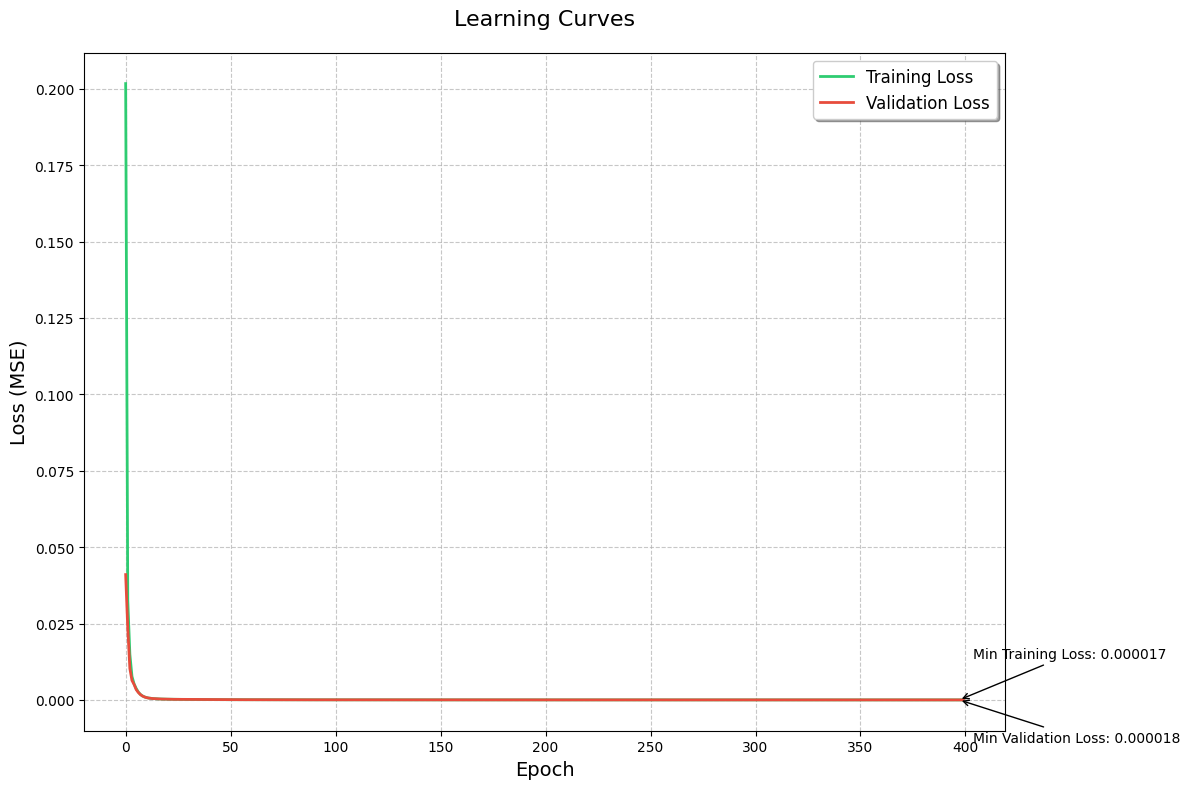

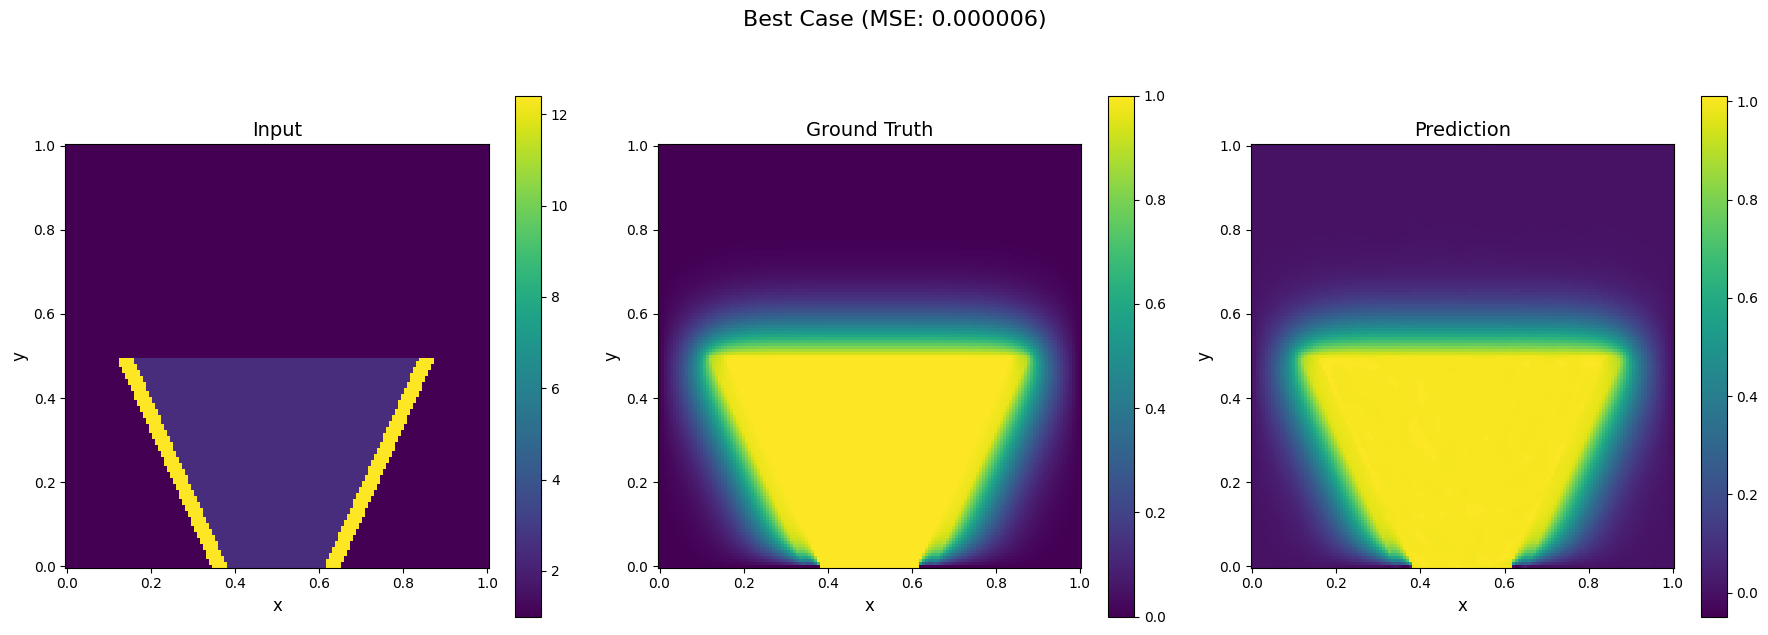

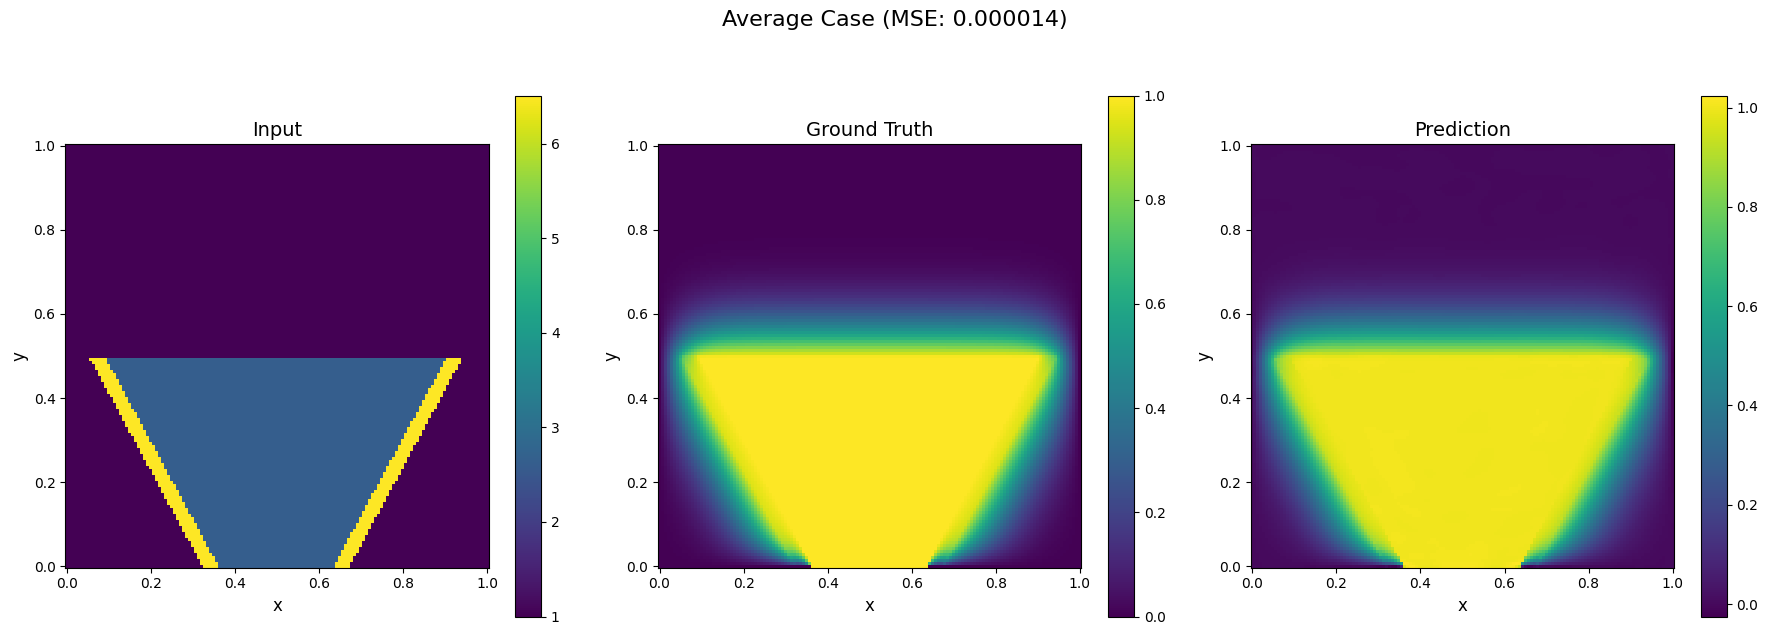

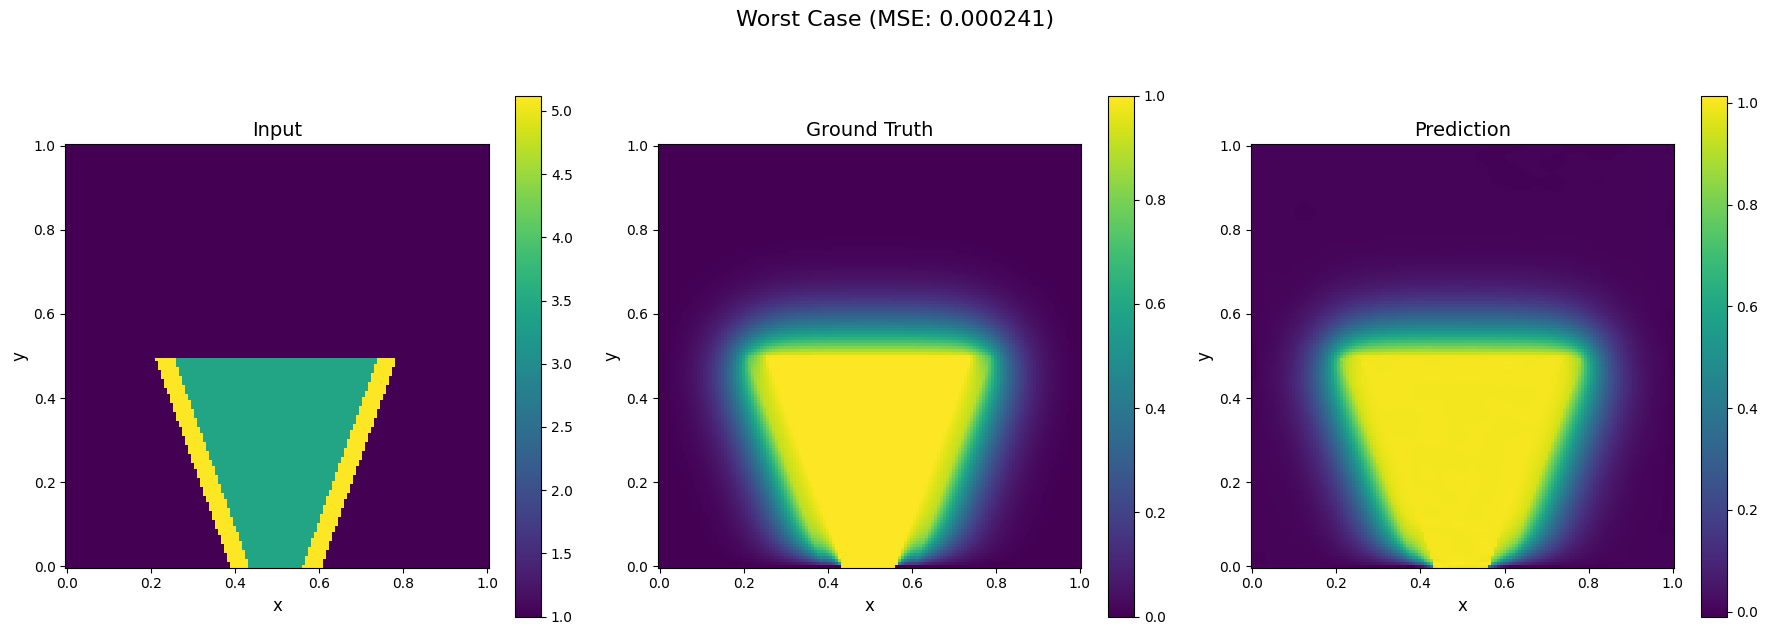

In [12]:
def main():
    # Data loading and preparation
    data = loadmat('/kaggle/input/cable-termination-dataset/cable_termination_dataset_1000.mat')
    x_data = torch.FloatTensor(data['input']).unsqueeze(-1)
    y_data = torch.FloatTensor(data['output']).unsqueeze(-1)

    # Calculate grid spacing
    n_points = x_data.shape[1]
    dx = dy = 1.0 / (n_points - 1)
    
    # Create stress mask
    stress_mask = (x_data > 2.0).bool()

    # Print shapes for verification
    print(f"Input data shape: {x_data.shape}")
    print(f"Output data shape: {y_data.shape}")
    print(f"Stress mask shape: {stress_mask.shape}")
    
    # Create dataset
    dataset = TensorDataset(x_data, y_data, x_data, stress_mask)
    
    # Split dataset
    n_total = len(dataset)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    
    train_dataset = Subset(dataset, range(n_train))
    val_dataset = Subset(dataset, range(n_train, n_train + n_val))
    test_dataset = Subset(dataset, range(n_train + n_val, n_total))

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=64, 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=64, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=64, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Set device to GPU
    device = torch.device('cuda')
    
    # Create model and move to GPU
    model = FNO2d(modes1=12, modes2=12, width=32).to(device)
    
    # Initialize training components
    metrics_calculator = CableTerminationMetrics(dx=dx, dy=dy, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    # Train model
    history = enhance_train_model(
        model, train_loader, val_loader, optimizer, scheduler, 
        device, metrics_calculator
    )
    
    # Generate analysis and evaluate
    output_dir = 'model_analysis_results'
    generate_analysis(model, test_loader, history, device, output_dir)
    
    print("\nEvaluating final model on test set...")
    test_metrics = evaluate_model(model, test_loader, metrics_calculator, device)
    
    print("\nFinal Training Metrics:")
    for metric, values in history.items():
        print(f"{metric}: {values[-1]:.4f}")
        
    print("\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

# Run the main function
if __name__ == "__main__":
    main()
else:
    print("Running in notebook mode...")
    main()

# First, create a module level function that wraps the training process
def run_training(rank, world_size, train_dataset, val_dataset, test_dataset, dx, dy):
    """Main training function that handles both single and multi-GPU training"""
    if world_size > 1:
        # Initialize process group
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group("nccl", rank=rank, world_size=world_size)
        
        # Create distributed samplers
        train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
        val_sampler = DistributedSampler(val_dataset, num_replicas=world_size, rank=rank)
        
        # Adjust batch size for distributed training
        batch_size = 64 // world_size
    else:
        train_sampler = None
        val_sampler = None
        batch_size = 64
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    # Set device
    device = torch.device(f'cuda:{rank}' if world_size > 1 else 'cuda')
    
    # Create model
    model = FNO2d(modes1=12, modes2=12, width=32).to(device)
    if world_size > 1:
        model = DDP(model, device_ids=[rank])
    
    # Initialize training components
    metrics_calculator = CableTerminationMetrics(dx=dx, dy=dy, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    # Train model
    history = enhance_train_model(
        model, train_loader, val_loader, optimizer, scheduler, 
        device, metrics_calculator,
        wandb_log=(rank == 0 or world_size == 1)
    )
    
    # Only process 0 handles evaluation and analysis
    if rank == 0 or world_size == 1:
        output_dir = 'model_analysis_results'
        generate_analysis(model, test_loader, history, device, output_dir)
        
        print("\nEvaluating final model on test set...")
        test_metrics = evaluate_model(model, test_loader, metrics_calculator, device)
        
        print("\nTraining Complete!")
        print("\nFinal Training Metrics:")
        for metric, values in history.items():
            print(f"{metric}: {values[-1]:.4f}")
            
        print("\nTest Set Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
    
    if world_size > 1:
        dist.destroy_process_group()
    
    return history if (rank == 0 or world_size == 1) else None
###############################
# Modified main execution block
###############################
if __name__ == "__main__":
    # Set up GPU optimization
    torch.backends.cudnn.benchmark = True
    
    # Data loading and preparation
    data = loadmat('/kaggle/input/cable-termination-dataset/cable_termination_dataset_1000.mat')
    x_data = torch.FloatTensor(data['input']).unsqueeze(-1)
    y_data = torch.FloatTensor(data['output']).unsqueeze(-1)

    # Calculate grid spacing
    n_points = x_data.shape[1]
    dx = dy = 1.0 / (n_points - 1)
    
    # Create stress mask
    stress_mask = (x_data > 2.0).bool()

    # Print shapes for verification
    print(f"Input data shape: {x_data.shape}")
    print(f"Output data shape: {y_data.shape}")
    print(f"Stress mask shape: {stress_mask.shape}")
    
    # Create complete dataset
    dataset = TensorDataset(x_data, y_data, x_data, stress_mask)
    
    # Calculate split sizes
    n_total = len(dataset)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    
    # Split dataset
    train_dataset = Subset(dataset, range(n_train))
    val_dataset = Subset(dataset, range(n_train, n_train + n_val))
    test_dataset = Subset(dataset, range(n_train + n_val, n_total))
    
    # Get number of available GPUs
    world_size = torch.cuda.device_count()
    print(f"\nFound {world_size} GPUs!")
    
    if world_size > 1:
        print("Initializing distributed training...")
        # Launch processes using spawn
        try:
            mp.set_start_method('spawn')
        except RuntimeError:
            pass
        
        processes = []
        for rank in range(world_size):
            p = mp.Process(target=run_training, 
                         args=(rank, world_size, train_dataset, val_dataset, test_dataset, dx, dy))
            p.start()
            processes.append(p)
            
        for p in processes:
            p.join()
            
    else:
        print("Only one GPU found. Running single GPU training...")
        run_training(0, 1, train_dataset, val_dataset, test_dataset, dx, dy)